In [13]:
import numpy as np
from numpy import sqrt
np.set_printoptions(precision=3, suppress=True)
import matplotlib.pyplot as plt

In [38]:
class GM():
    # Following Appendix A of BSRL1.
    # But I use nshell as the sum of the numbers of A and B shells. 

    # I should allow for the twist to be neglected and not neglected for small angles to see what happens to the matrix eigenvalues

    # k should be a 2d vector

    # The kth A shell has 6k sites, and similarly the kth B shell has 6k sites.
    # Each site needs a two-dimensional hamiltonian for the two sublattices within a layer.
    # So in total the dimension of the matrix must be 2*6*(nAshell * (nAshell+1))/2 + 2*6*(nBshell * (nBshell+1))/2
    # dim = 6*(nAshell * (nAshell+1)) + 6*(nBshell * (nBshell+1))
    # mat = np.zeros((dim, dim), dtype=complex) # dtype complex?
    
    q1 = np.array([0, 1])
    q2 = np.array([-sqrt(3)/2, -1/2])
    q3 = np.array([sqrt(3)/2, -1/2])

    @staticmethod
    def rotate_60i(v, i):
        c = np.cos(i*np.pi/3)
        s = np.sin(i*np.pi/3)
        return np.array([c*v[0] - s*v[1], s*v[0] + c*v[1]])

    @staticmethod
    def dotsigma(v):
        sigmax = np.array([[0, 1], [1, 0]])
        sigmay = np.array([[0, -1j], [1j, 0]])
        return v[0] * sigmax + v[1] * sigmay
    
    @staticmethod
    def Tj(j, w0, w1):
        # The T matrices in BSRL are hermitian.
        sigma0 = np.identity(2)
        sigmax = np.array([[0, 1], [1, 0]])
        sigmay = np.array([[0, -1j], [1j, 0]])
        return w0 * sigma0 + w1 * (np.cos(2*np.pi*(j-1)/3) * sigmax + np.sin(2*np.pi*(j-1)/3) * sigmay)

    # In the following site indexing scheme, {n, m, j} are all 1-based, because that's how the paper does it.
    @staticmethod
    def QA_site(n, m, j):
        # Finds the site of an A hopping location in the nth shell. 
        # I let j range from 1 to n and I use m that ranges from 1 to 6 so that the 
        # index of the site among all 6n sites in the nth shell is n(m-1) + j. 
        return GM.rotate_60i((n-1) * (GM.q1 - GM.q2) + (j-1) * (GM.q2 - GM.q3) + GM.q1, m-1)

    @staticmethod
    def QB_site(n, m, j):
        return GM.rotate_60i(GM.QA_site(n, 1, j) + GM.q1, m-1)
    
    @staticmethod
    def get_site_index_A(n, m, j):
        # Returns the 1-based index of site A_{n,m,j} in the block matrix. 
        # So corresponding indices in the full numpy matrix will be twice-2 and twice-1. 
        # E.g. n=1, m, j should return (m-1) + j.  
        #      n=2, m, j should return (6 for n=1 A shell) + (6 for n=1 B shell) + 2*(m-1) + j
        # In general, n, m, j should return 6 * (n * (n-1)) + n * (m-1) + j
        return 6 * (n * (n-1)) + n * (m-1) + j

    @staticmethod
    def get_site_index_B(n, m, j):
        # Returns the 1-based index of site B_{n,m,j} in the block matrix. 
        # So corresponding indices in the full numpy matrix will be twice-2 and twice-1. 
        # E.g. n=1, m, j should return 6 + (m-1) + j.  
        #      n=2, m, j should return (6 for n=1 A shell) + (6 for n=1 B shell) + (12 for n=2 A shell) + 2*(m-1) + j
        # In general, n, m, j should return 6 * (n * (n-1)) + 6 * n + n * (m-1) + j
        return 6 * (n * (n-1)) + 6 * n + n * (m-1) + j

    @staticmethod
    def create_site_plot(nshell, fontsize=10):
        # A color: RGB = 250 70 22
        # B color: RGB = 0 33 165
        # colorA = (250/255, 70/255, 22/255)
        # colorB = (0/255, 33/255, 165/255)
        colorA = np.array((1.0, 0.647, 0.0))
        colorB = 0.7*np.array((0.392, 0.584, 0.929))


        import matplotlib.pyplot as plt
        nBshell = nshell//2
        nAshell = nshell - nBshell
        fig, ax = plt.subplots(dpi=300) # figsize=(3, 3))

        
        hops = []

        # create An to An hops:
        for n in range(1, nAshell + 1):
            for m in range(1, 7):
                site_1 = GM.QA_site(n, m, n)
                if m == 6:
                    site_2 = GM.QA_site(n, 1, 1)
                else:
                    site_2 = GM.QA_site(n, m+1, 1)
                hops.append((site_1, site_2))


        # create An to Bn hops:
        for n in range(1, nBshell + 1):
            for m in range(1, 7):
                for j in range(1, n+1):
                    site_A = GM.QA_site(n, m, j)
                    site_B = GM.QB_site(n, m, j)
                    hops.append((site_A, site_B))


        # create Bn-1 to An hops:
        for n in range(2, nAshell + 1):
            for m in range(1, 7): 
                for j in range(1, n): 
                    site_B = GM.QB_site(n-1, m, j)
                    site_A = GM.QA_site(n, m, j)
                    hops.append((site_B, site_A))
                for j in range(2, n+1):
                    site_B = GM.QB_site(n-1, m, j-1)
                    site_A = GM.QA_site(n, m, j)
                    hops.append((site_B, site_A))

        for hop in hops:
            ax.plot([hop[0][0], hop[1][0]], [hop[0][1], hop[1][1]], c='0.5', linestyle='-')


        # Drawing dots and labels at sites
        for n in range(1, nAshell + 1):
            for m in range(1, 7):
                for j in range(1, n+1):
                    loc = GM.QA_site(n, m, j)
                    ax.plot(loc[0], loc[1], 'o', color=colorA)
                    ax.text(loc[0], loc[1], f"$A_{{{n},{m},{j}}}$", fontsize=fontsize, verticalalignment='center', horizontalalignment='center')
        
        for n in range(1, nBshell + 1):
            for m in range(1, 7):
                for j in range(1, n+1):
                    loc = GM.QB_site(n, m, j)
                    ax.plot(loc[0], loc[1], 'o', color=colorB)
                    ax.text(loc[0], loc[1], f"$B_{{{n},{m},{j}}}$", fontsize=fontsize, verticalalignment='center', horizontalalignment='center')

        ax.plot(0, 0, 'o', color='k')
        ax.text(0, 0, "$\\Gamma_M$", fontsize=fontsize)# , verticalalignment='center', horizontalalignment='center')
        ax.plot(0, 1, 'o', color='k')
        ax.text(0, 1, "$K_M$", fontsize=fontsize)# , verticalalignment='center', horizontalalignment='center')
        ax.plot(sqrt(3)/4, 3/4, 'o', color='k')
        ax.text(sqrt(3)/4, 3/4, "$M_M$", fontsize=fontsize)# , verticalalignment='center', horizontalalignment='center')

        ax.set_aspect('equal')

        # x_tick_labels = ax.get_xticklabels()
        # if x_tick_labels:  # Check if there are tick labels
            # x_tick_fontsize = x_tick_labels[0].get_fontsize()
            # print(f"X-axis tick font size: {x_tick_fontsize}")

        plt.show()

    @staticmethod
    def get_gammaM_matrix(k, w0, w1, nshell):
        nBshell = nshell//2
        nAshell = nshell - nBshell
        dim = 6*(nAshell * (nAshell+1)) + 6*(nBshell * (nBshell+1))
        mat = np.zeros((dim, dim), dtype=complex)

        T1 = GM.Tj(1, w0, w1)
        T2 = GM.Tj(2, w0, w1)
        T3 = GM.Tj(3, w0, w1)

        # set up H_kAn terms:
        for n in range(1, nAshell + 1):
            for m in range(1, 7):
                for j in range(1, n+1):
                    site_index = GM.get_site_index_A(n, m, j)
                    s = 2*site_index - 2
                    submat = GM.dotsigma(k - GM.QA_site(n, m, j))
                    mat[s:s+2, s:s+2] = submat

        # set up H_kBn terms:
        for n in range(1, nBshell + 1):
            for m in range(1, 7):
                for j in range(1, n+1):
                    site_index = GM.get_site_index_B(n, m, j)
                    s = 2*site_index - 2
                    submat = GM.dotsigma(k - GM.QB_site(n, m, j))
                    mat[s:s+2, s:s+2] = submat
        
        # set up H_An_An terms:
        m_to_T = {1: T2, 2: T1, 3: T3, 4: T2, 5: T1, 6: T3}
        for n in range(1, nAshell + 1):
            for m in range(1, 7):
                site_index_1 = GM.get_site_index_A(n, m, n)
                if m == 6:
                    site_index_2 = GM.get_site_index_A(n, 1, 1)
                else:
                    site_index_2 = GM.get_site_index_A(n, m+1, 1)
                s1 = 2*site_index_1 - 2
                s2 = 2*site_index_2 - 2
                submat = m_to_T[m]
                mat[s1:s1+2, s2:s2+2] = submat
                mat[s2:s2+2, s1:s1+2] = submat


        # set up H_An_Bn terms:
        m_to_T = {1: T1, 2: T3, 3: T2, 4: T1, 5: T3, 6: T2}
        for n in range(1, nBshell + 1):
            for m in range(1, 7):
                for j in range(1, n+1):
                    site_index_A = GM.get_site_index_A(n, m, j)
                    site_index_B = GM.get_site_index_B(n, m, j)
                    sA = 2*site_index_A - 2
                    sB = 2*site_index_B - 2
                    submat = m_to_T[m]
                    mat[sA:sA+2, sB:sB+2] = submat
                    mat[sB:sB+2, sA:sA+2] = submat 

        # A1 B1 A2 B2 A3 B3 -> there are 2 H_Bn-1_An terms
        # A1 B1 A2 B2 A3    -> there are 2 H_Bn-1_An terms
        # so number of H_Bn-1_An terms = nAshell - 1

        # set up H_Bn-1_An terms: 
        m_to_T_1 = {1: T2, 2: T1, 3: T3, 4: T2, 5: T1, 6: T3}
        m_to_T_2 = {1: T3, 2: T2, 3: T1, 4: T3, 5: T2, 6: T1}
        for n in range(2, nAshell + 1):
            for m in range(1, 7): 
                for j in range(1, n): 
                    site_index_B = GM.get_site_index_B(n-1, m, j)
                    site_index_A = GM.get_site_index_A(n, m, j)
                    sB = 2*site_index_B - 2
                    sA = 2*site_index_A - 2
                    submat = m_to_T_1[m]
                    mat[sB:sB+2, sA:sA+2] = submat
                    mat[sA:sA+2, sB:sB+2] = submat

                for j in range(2, n+1):
                    site_index_B = GM.get_site_index_B(n-1, m, j-1)
                    site_index_A = GM.get_site_index_A(n, m, j)
                    sB = 2*site_index_B - 2
                    sA = 2*site_index_A - 2
                    submat = m_to_T_2[m]
                    mat[sB:sB+2, sA:sA+2] = submat
                    mat[sA:sA+2, sB:sB+2] = submat
        return mat

    @staticmethod
    def gammaM_BZ(N, proportion=1):
        # Generates a list of points within the MBZ centered at gammaM.
        # Creates a point at the center, six at the corners,
        # and has N points between the center and each corner, including the corner and excluding the center.
        # The hexagonal BZ is oriented with pointy ends up and down, following the convention in BSRL1.abs
        # proportion > 1 scales the region so that it covers more than just the MBZ. proportion < 1 zooms in on Gamma_M

        # First, generate the points in a sextant. Then, make five more copies. 
        # Starting with the eastern sextant. 

        assert N >= 1

        q1N = np.array([0, 1]) / N * proportion
        q3N = np.array([sqrt(3)/2, -1/2]) / N * proportion

        east_points = []
        for i in range(1, N+1):
            for j in range(i):
                east_points.append(i*q3N + j*q1N)


        all_points = [np.array([0, 0])]
        # Now making the other copies.
        def rotate_60ccw(v):
            c = np.cos(np.pi/3)
            s = np.sin(np.pi/3)
            return np.array([c*v[0] - s*v[1], s*v[0] + c*v[1]])

        for point in east_points:
            all_points.append(point)
            for i in range(5):
                all_points.append(rotate_60ccw(all_points[-1]))
        
        return all_points

    @staticmethod
    def BZ_path(N):
        # Generates a list of points from KM to GammaM to MM to KM.
        # Makes N points per unit length, where unit length is the distance from KM to GammaM.
        # The hexagonal BZ is oriented with pointy ends up and down, following the convention in BSRL1.
        assert N >= 1

        KM = np.array([0, 1])
        GammaM = np.array([0, 0])
        MM = np.array([sqrt(3)/4, 3/4])

        N2 = int(N*sqrt(3)/2)
        N3 = N//2

        path = []
        for i in range(N):
            path.append(KM + (GammaM - KM) * i/N)
        for i in range(N2):
            path.append(GammaM + (MM - GammaM) * i/N2)
        for i in range(N3):
            path.append(MM + (KM - MM) * i/N3)
        
        return path

    @staticmethod
    def plot_path_eigvals(N, w0, w1, nshell, ax=None, Elimits=None, bands=None, label=None, color='blue'):
        # N is the N used when creating the eigenvalue lists along the path
        # w0, w1 are the parameters in the Hamiltonian
        # nshell is the number of shells of hopping sites
        # Elimits is a tuple (Emin, Emax) that sets the y-axis limits
        # bands is a two-tuple (num_bands_above, num_bands_below) that sets the number of bands to plot above and below the Fermi level

        import matplotlib.pyplot as plt
        if ax is None:
            fig, ax = plt.subplots(dpi=150)

        path = GM.BZ_path(N)
        all_eigvals = []
        for k in path:
            all_eigvals.append(sorted(np.linalg.eigvalsh(GM.get_gammaM_matrix(k, w0, w1, nshell))))
            
        total_num_bands = len(all_eigvals[0])
        if bands:
            which_eigvals_to_plot = range(total_num_bands//2 - bands[1], total_num_bands//2 + bands[0])
        else: 
            which_eigvals_to_plot = range(total_num_bands)
        eigvals_to_plot = np.array(all_eigvals)[:, which_eigvals_to_plot]

        N2 = int(N*sqrt(3)/2)
        N3 = N//2

        if Elimits:
            ax.set_ylim(Elimits)

        for i in range(len(eigvals_to_plot[0])):
            ax.plot(eigvals_to_plot[:, i], color=color, label = label)
        
        k_labels = ["$K_M$", "$\\Gamma_M$", "$M_M$", "$K_M$"]
        k_points = [0, N, N+N2, N+N2+N3]

        ax.set_xticks(k_points)
        ax.set_xticklabels(k_labels)
        ax.set_xlabel("$k$")
        ax.set_ylabel("$E$")
        
        # Add dashed vertical lines for labeled points
        for k in k_points:
            ax.axvline(k, color='gray', linestyle='dashed', linewidth=0.8)

        # ax.title.set_text(f"Eigenvalues along path in MBZ for $w_0 = {w0:.3f}$, $w_1 = {w1:.3f}$, $n_{{\\text{{shell}}}} = {nshell}$")

        plt.show()


    @staticmethod
    def plot_path_eigvals_colormap(N, w0, w1, nshell_range, Elimits=None, bands=None, colormap='viridis'):
        """
        Plots eigenvalues for multiple shells on the same plot, using a colormap for line colors.

        Parameters:
            N (int): Number of k-points along the path in the BZ.
            w0 (float): Parameter in the Hamiltonian.
            w1 (float): Parameter in the Hamiltonian.
            nshell_range (list or range): Range of shells to plot.
            Elimits (tuple): (Emin, Emax) tuple to set the y-axis limits.
            bands (tuple): (num_bands_above, num_bands_below) to specify bands to plot.
            colormap (str): Name of the matplotlib colormap to use.
        """
        fig, ax = plt.subplots(dpi=300)
        cmap = get_cmap(colormap)
        
        for nshell in nshell_range:
            path = GM.BZ_path(N)
            all_eigvals = []
            for k in path:
                all_eigvals.append(sorted(np.linalg.eigvalsh(GM.get_gammaM_matrix(k, w0, w1, nshell))))

            total_num_bands = len(all_eigvals[0])
            if bands:
                which_eigvals_to_plot = range(total_num_bands//2 - bands[1], total_num_bands//2 + bands[0])
            else: 
                which_eigvals_to_plot = range(total_num_bands)
            eigvals_to_plot = np.array(all_eigvals)[:, which_eigvals_to_plot]

            # Normalize nshell for colormap indexing
            color = cmap((nshell - min(nshell_range)) / (max(nshell_range) - min(nshell_range)))

            for i in range(len(eigvals_to_plot[0])):
                ax.plot(eigvals_to_plot[:, i], color=color, label=f"{nshell} shells" if i == 0 else "")

        N2 = int(N * sqrt(3) / 2)
        N3 = N // 2

        if Elimits:
            ax.set_ylim(Elimits)

        k_labels = ["$K_M$", "$\\Gamma_M$", "$M_M$", "$K_M$"]
        k_points = [0, N, N + N2, N + N2 + N3]

        ax.set_xticks(k_points)
        ax.set_xticklabels(k_labels, fontsize='large')
        ax.set_xlabel("$k$")
        ax.set_ylabel("$E$")

        # Add dashed vertical lines for labeled points
        for k in k_points:
            ax.axvline(k, color='gray', linestyle='dashed', linewidth=0.8)

        # Add a colorbar
        sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=min(nshell_range), vmax=max(nshell_range)))
        sm.set_array([])
        # cbar = plt.colorbar(sm, ax=ax)
        # cbar.set_label('Shell Index')

        plt.title(f"Eigenvalues along path in MBZ for $w_0 = {w0:.4f}$, $w_1 = {w1:.4f}$")
        plt.legend(loc='upper right', fontsize='small', ncol=1)
        plt.show()



/var/folders/lm/7h466wts1h1c4ptw5tfpglvm0000gn/T/ipykernel_20299/2795705197.py:365: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.



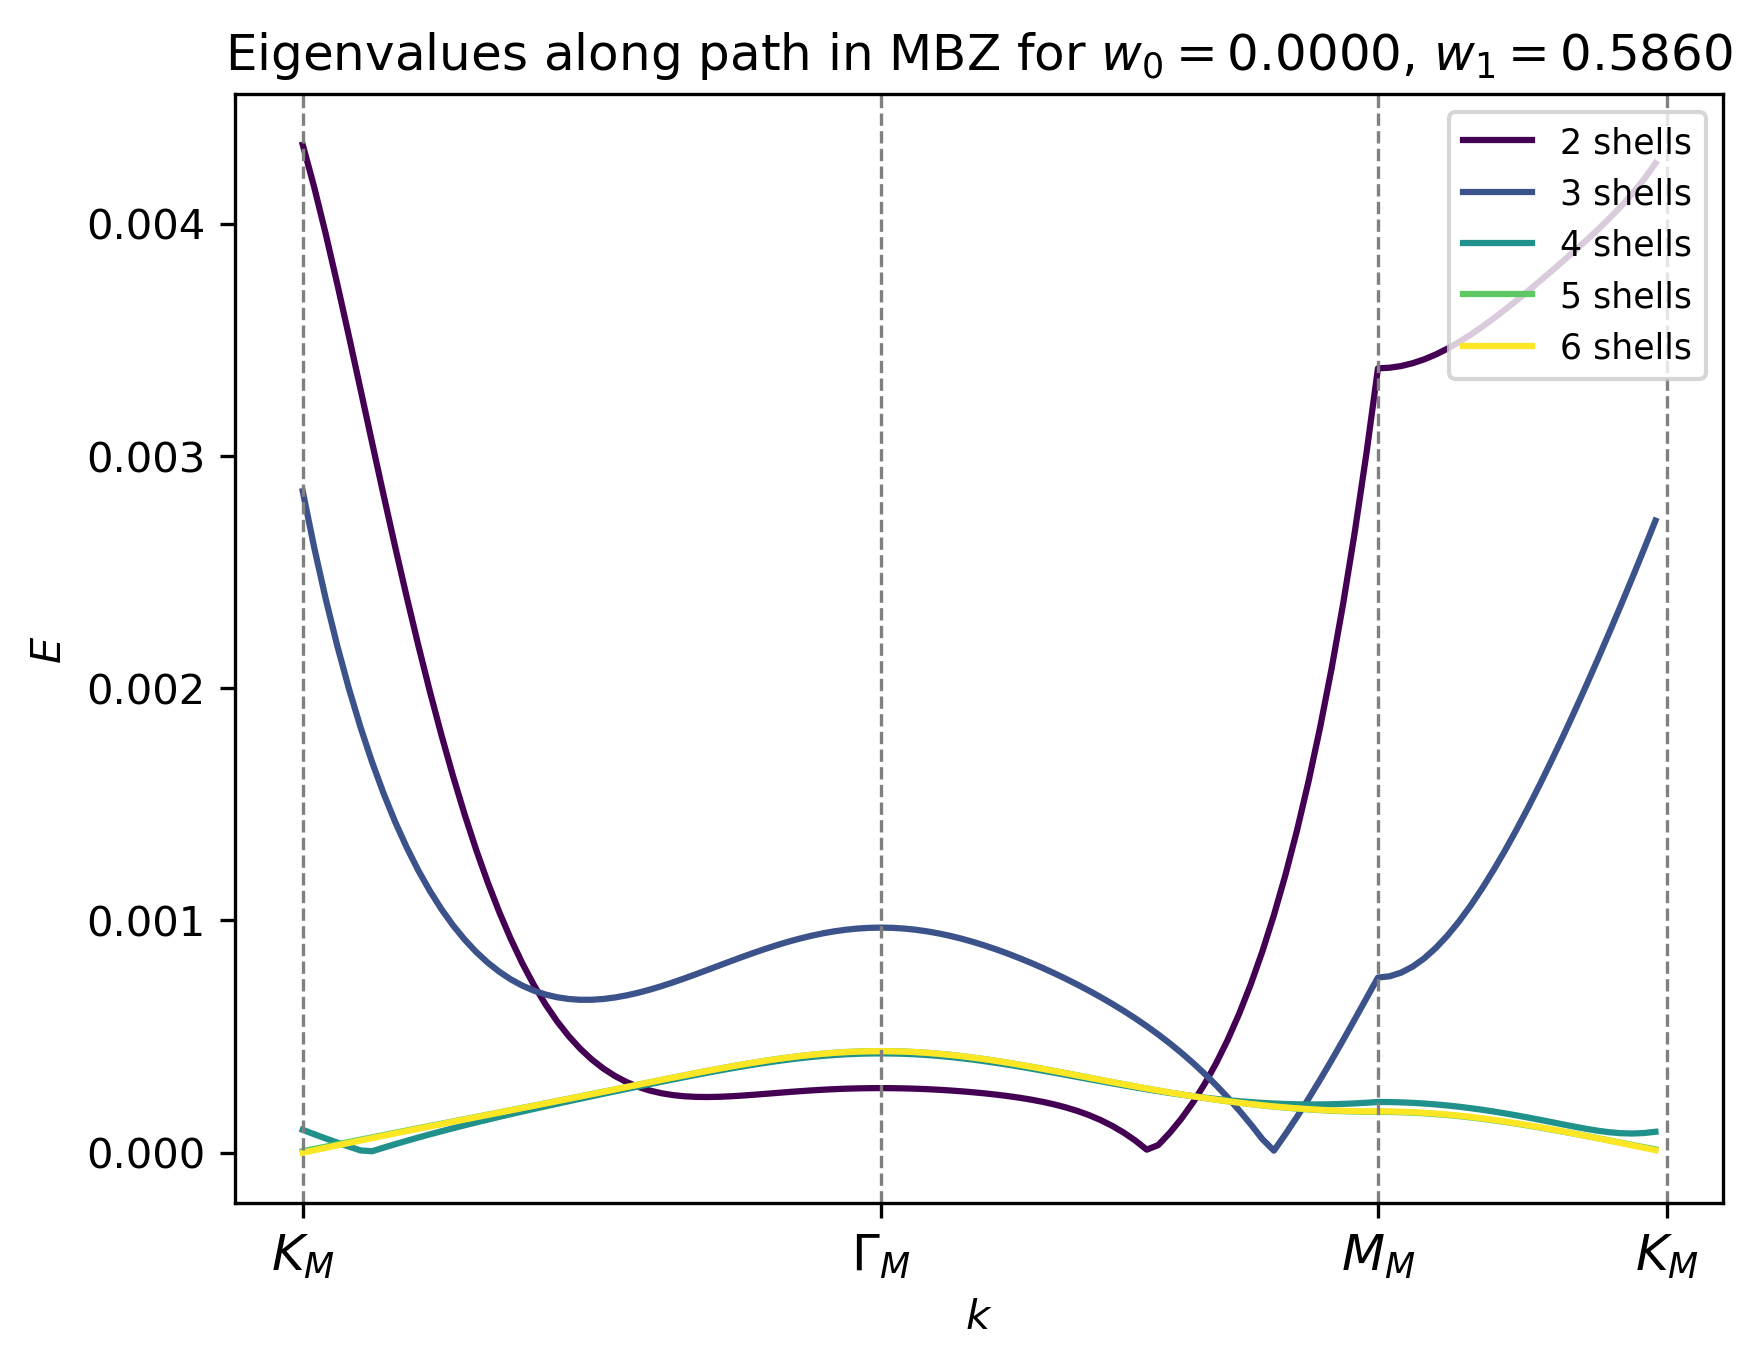

In [39]:
from matplotlib.cm import get_cmap

GM.plot_path_eigvals_colormap(50, 0, 0.586, [2, 3, 4, 5, 6], Elimits=None, bands=(1, 0), colormap='viridis')

/var/folders/lm/7h466wts1h1c4ptw5tfpglvm0000gn/T/ipykernel_20299/2795705197.py:365: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.



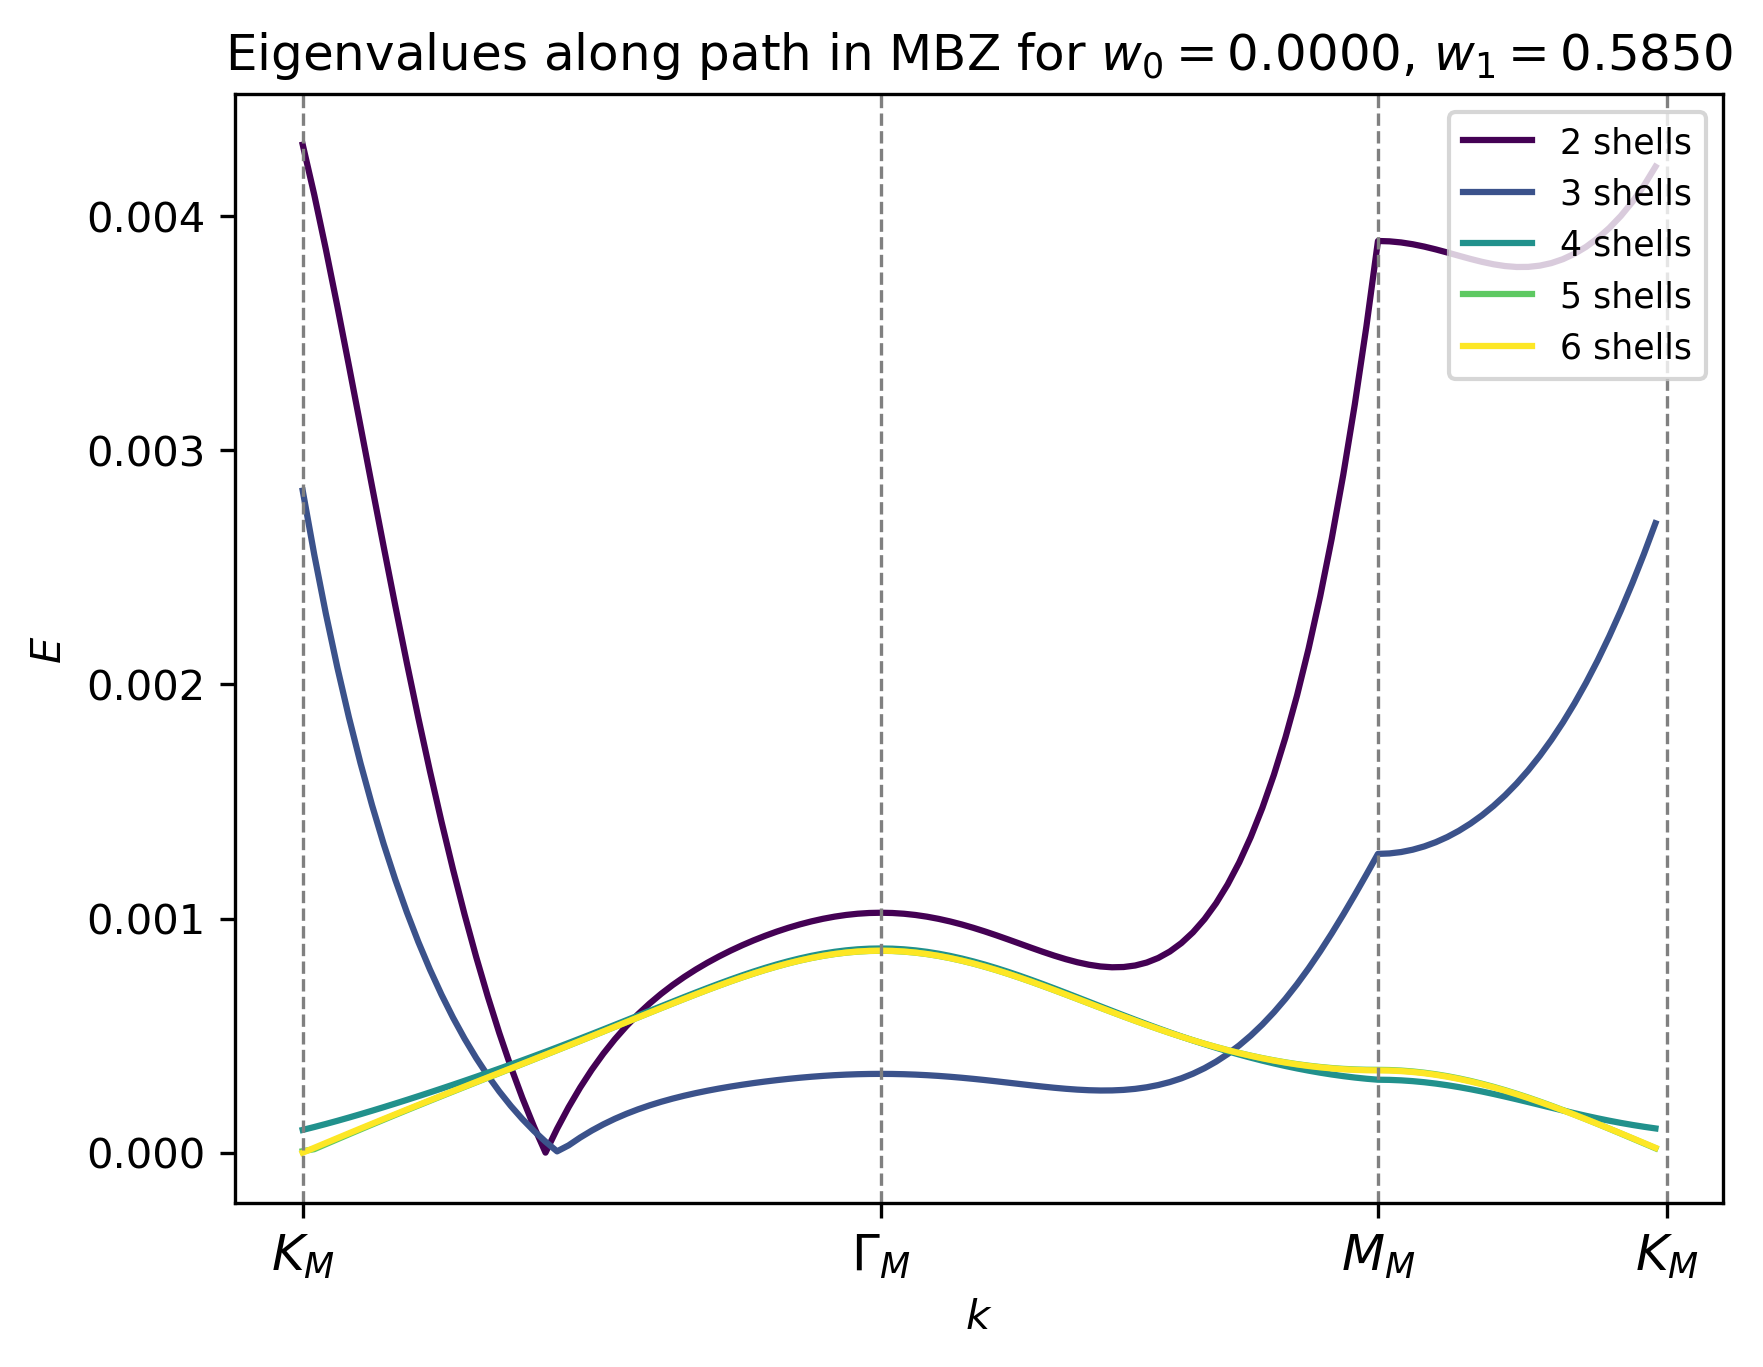

/var/folders/lm/7h466wts1h1c4ptw5tfpglvm0000gn/T/ipykernel_20299/2795705197.py:365: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.



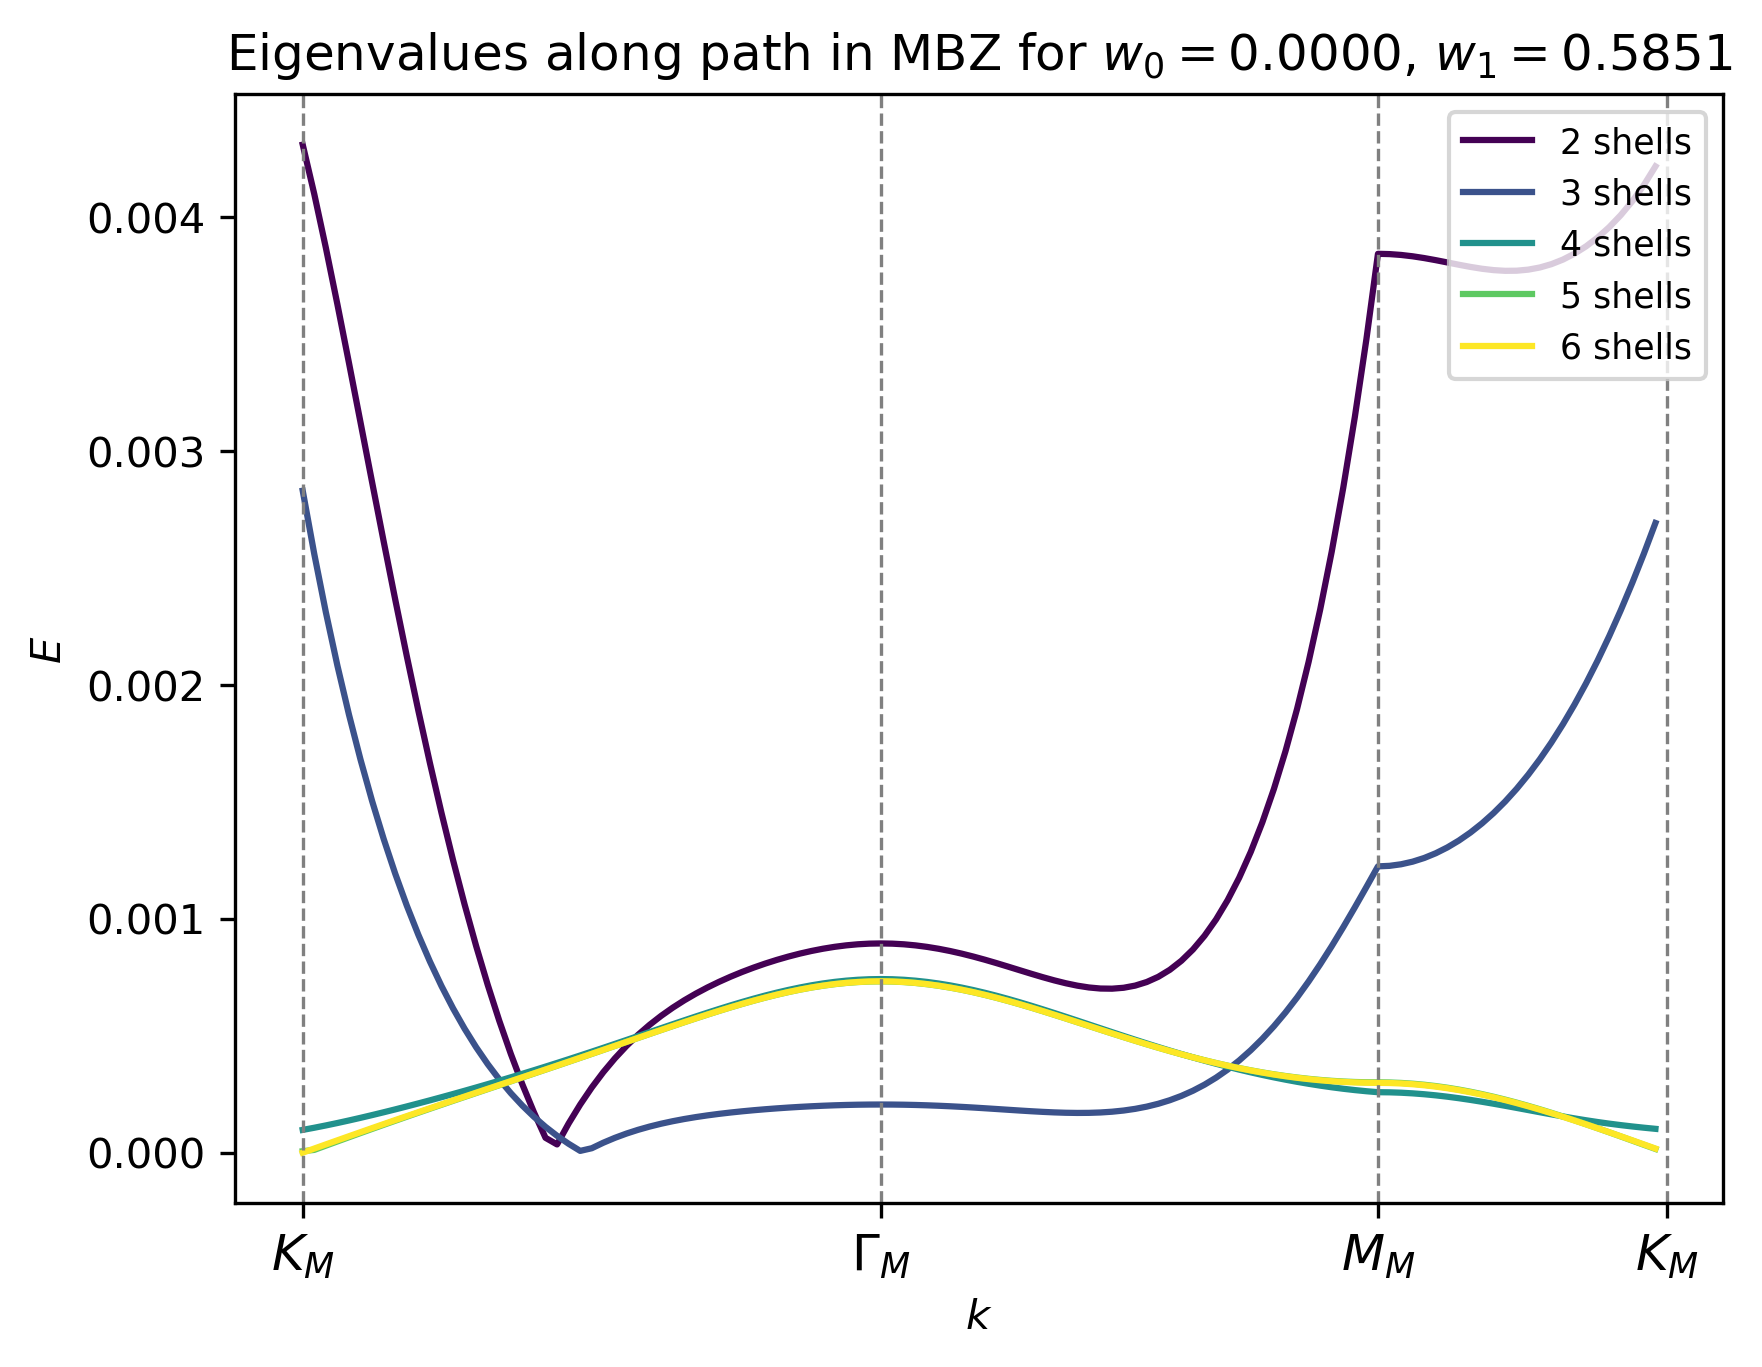

/var/folders/lm/7h466wts1h1c4ptw5tfpglvm0000gn/T/ipykernel_20299/2795705197.py:365: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.



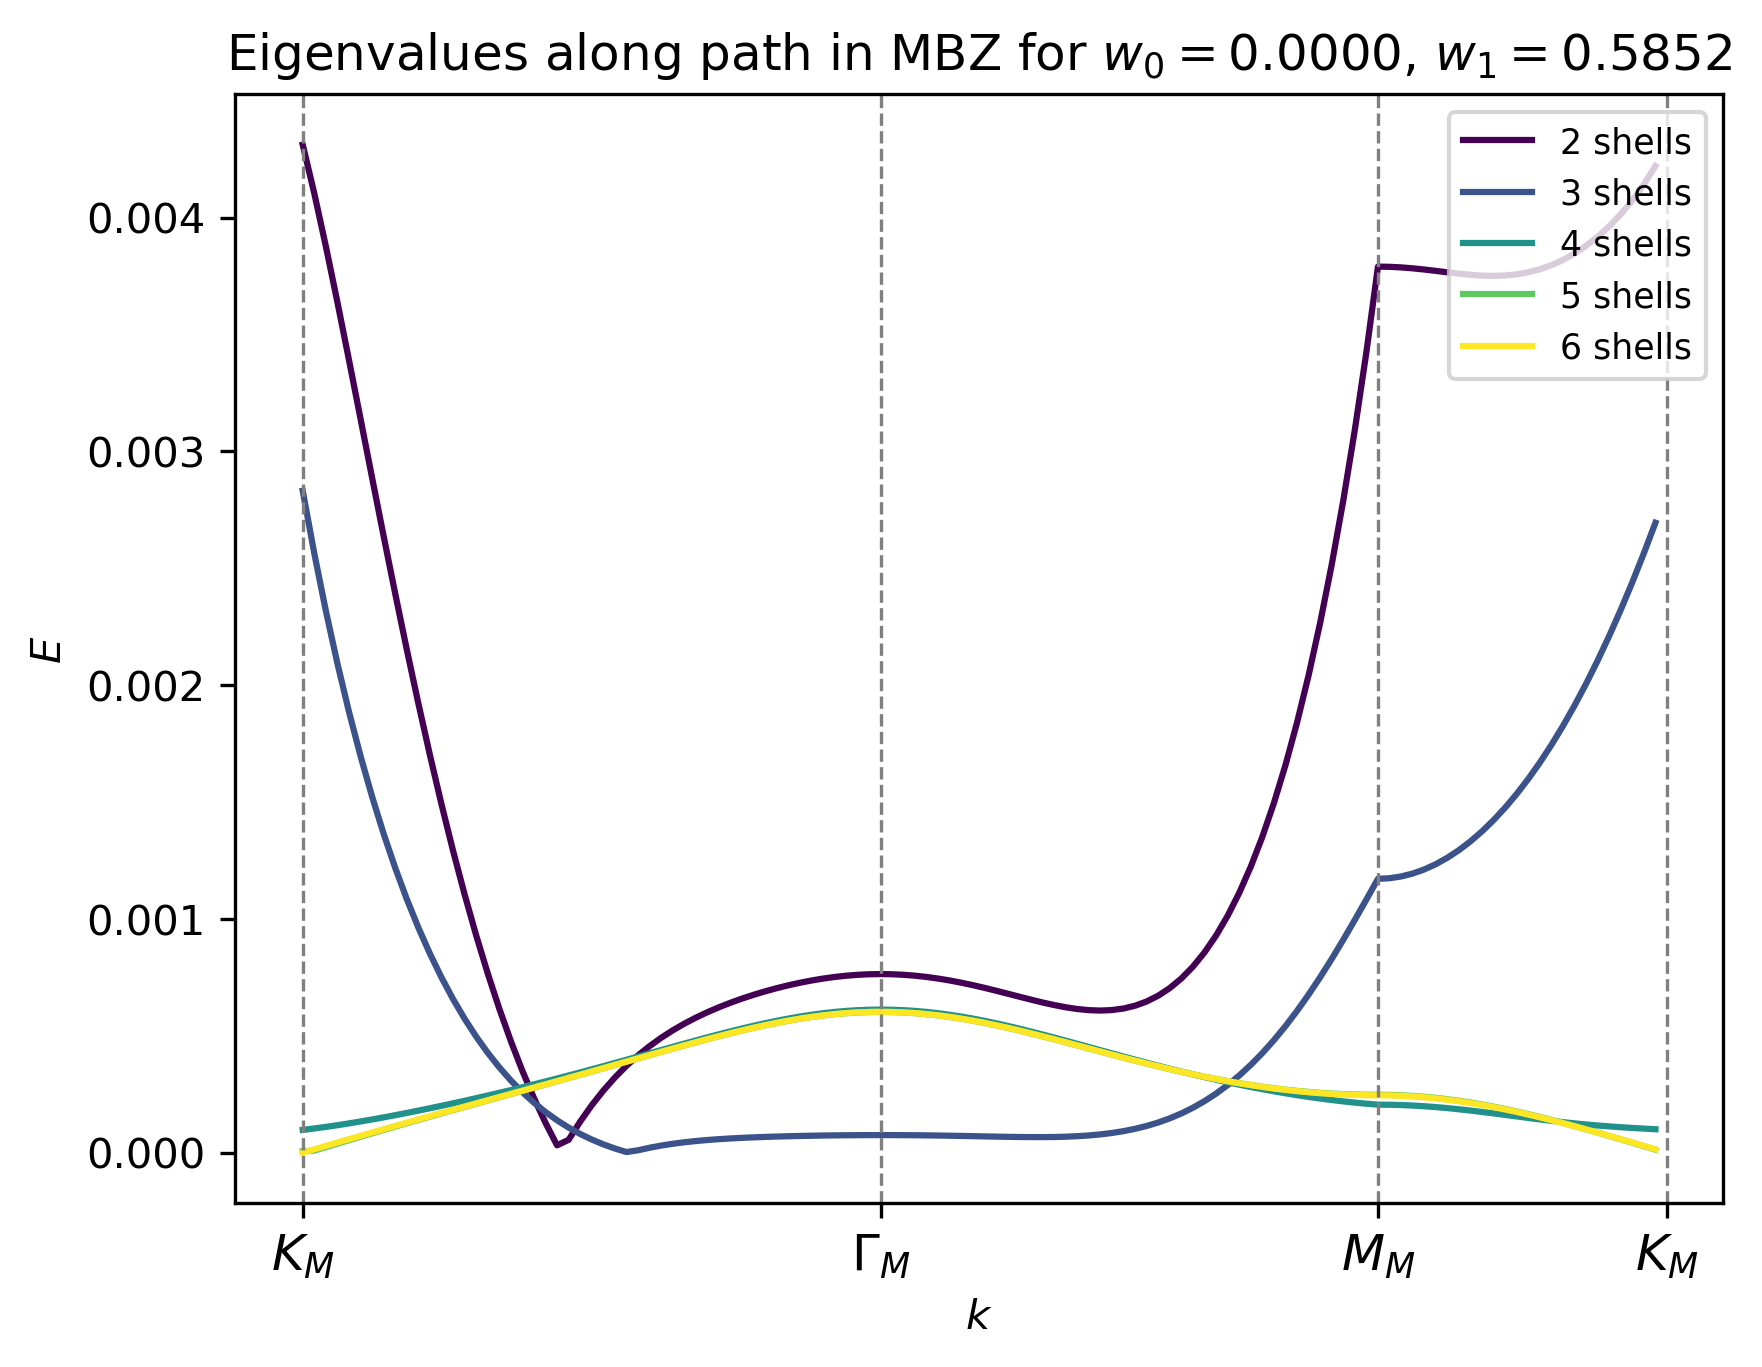

/var/folders/lm/7h466wts1h1c4ptw5tfpglvm0000gn/T/ipykernel_20299/2795705197.py:365: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.



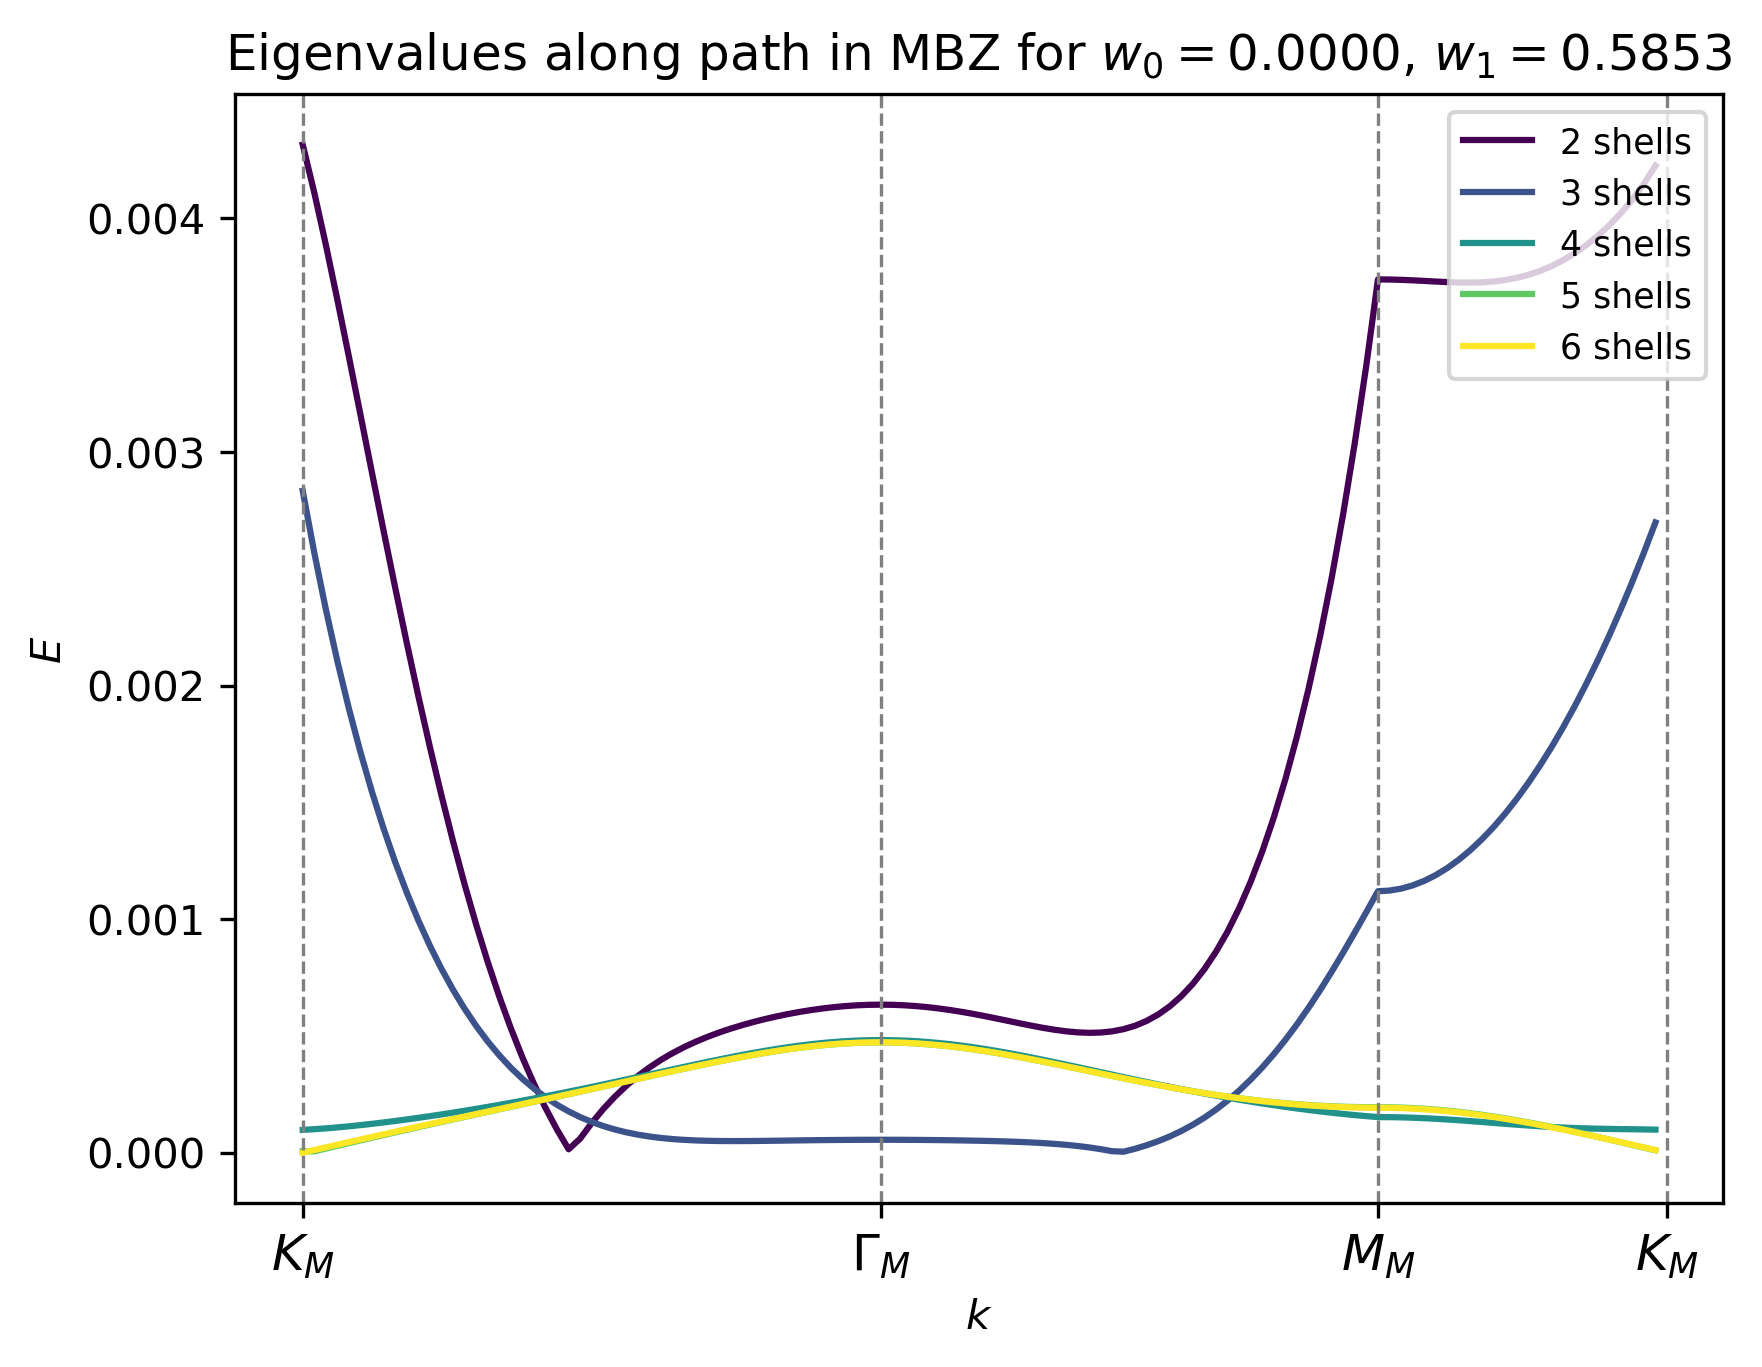

/var/folders/lm/7h466wts1h1c4ptw5tfpglvm0000gn/T/ipykernel_20299/2795705197.py:365: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.



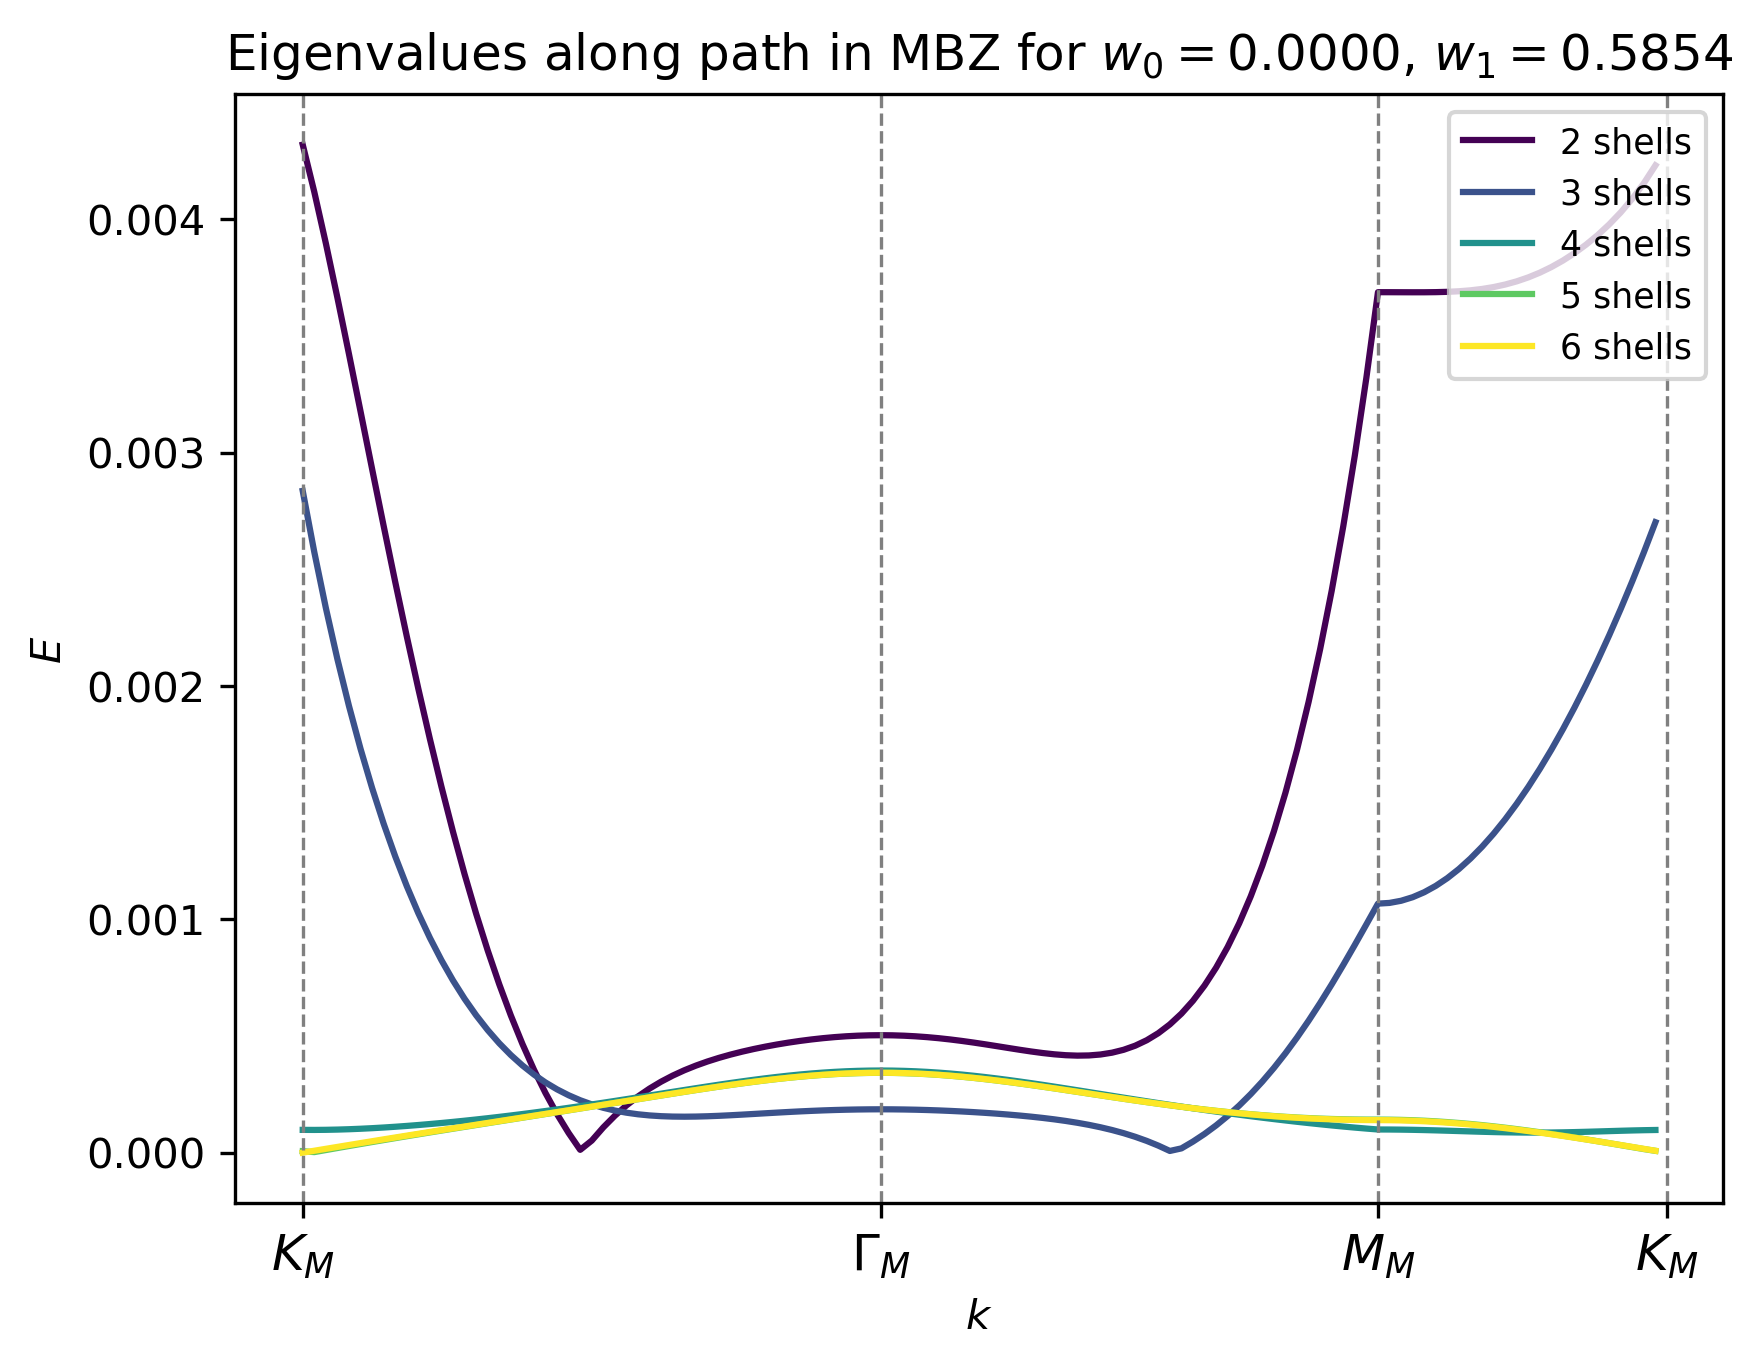

/var/folders/lm/7h466wts1h1c4ptw5tfpglvm0000gn/T/ipykernel_20299/2795705197.py:365: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.



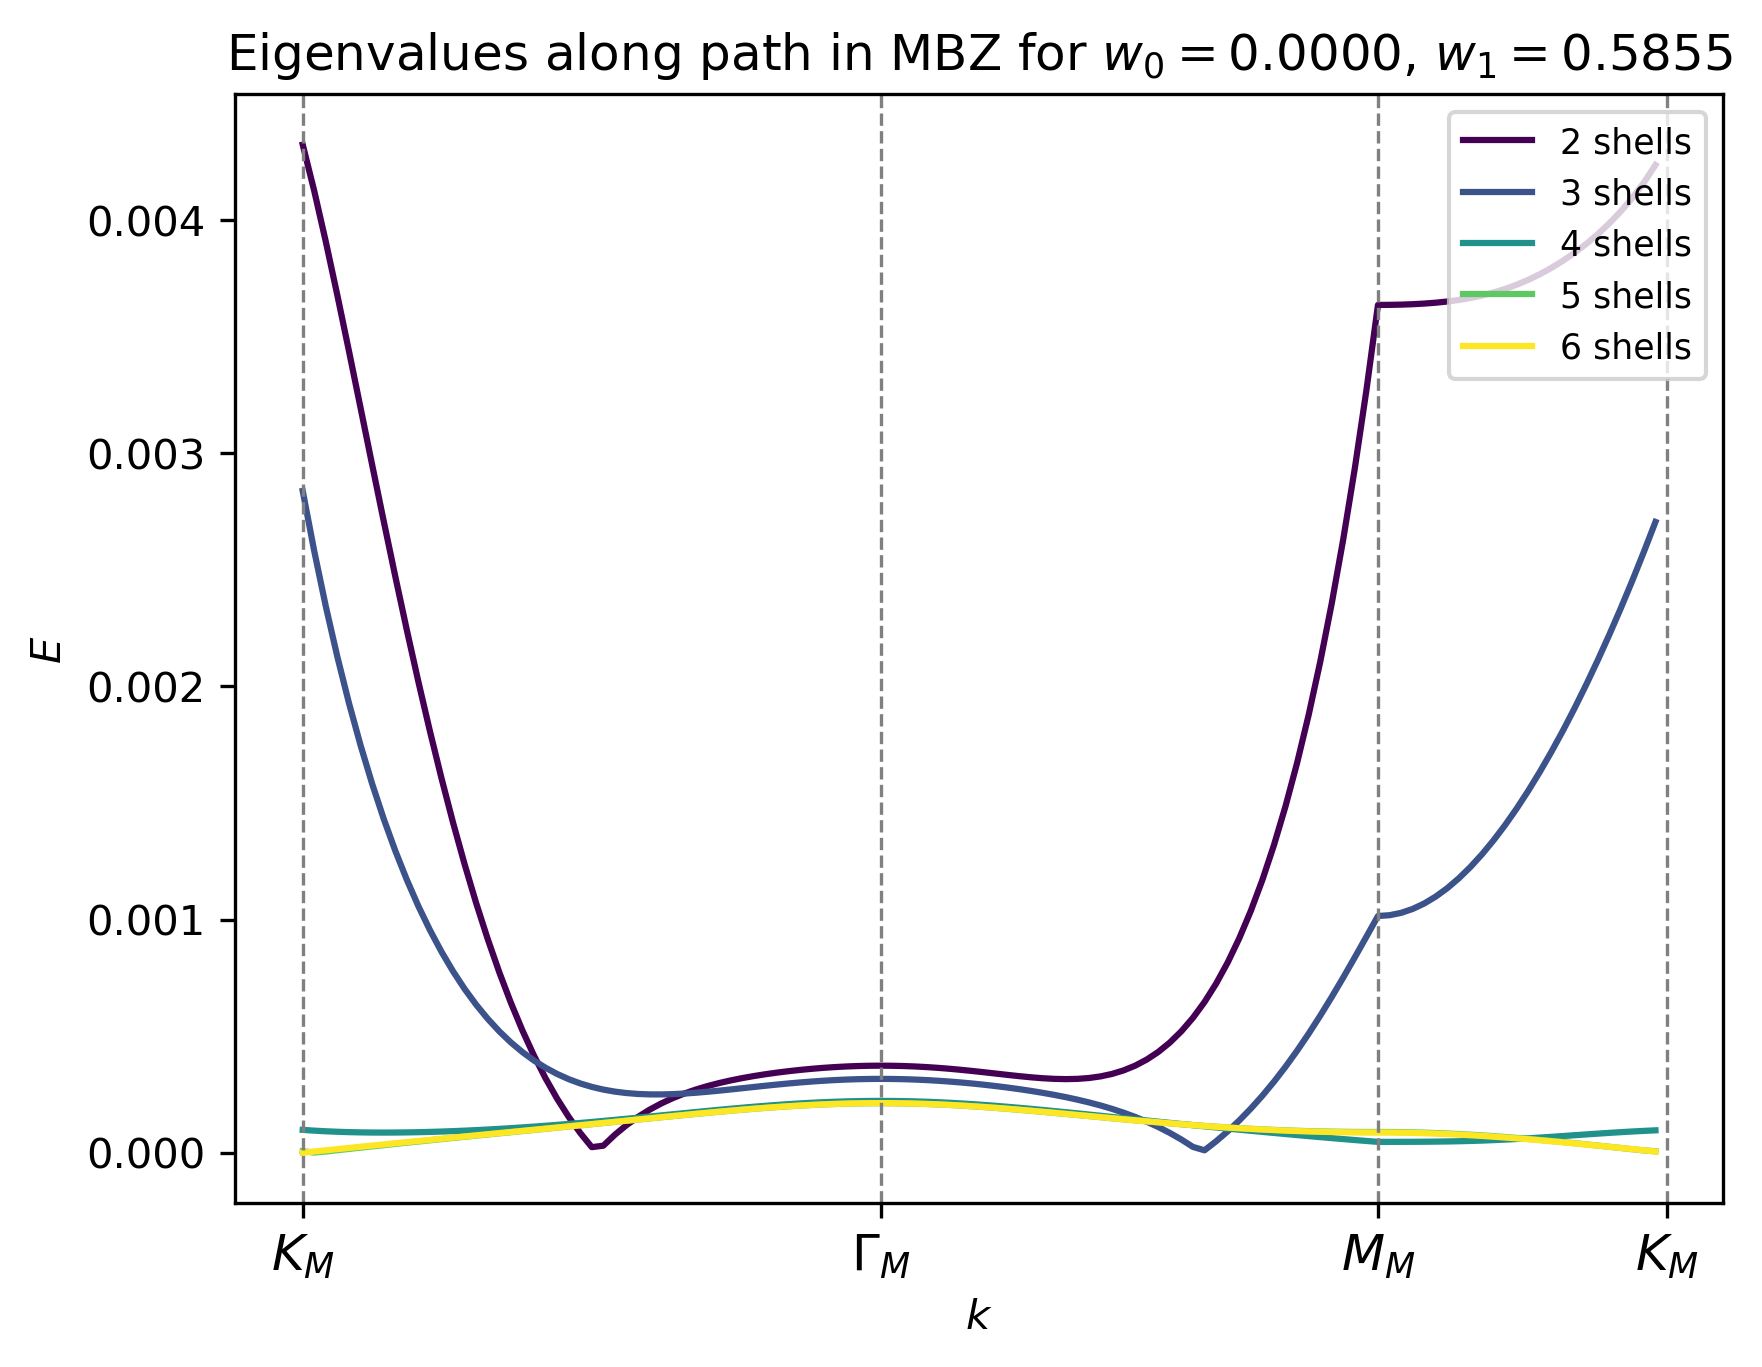

/var/folders/lm/7h466wts1h1c4ptw5tfpglvm0000gn/T/ipykernel_20299/2795705197.py:365: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.



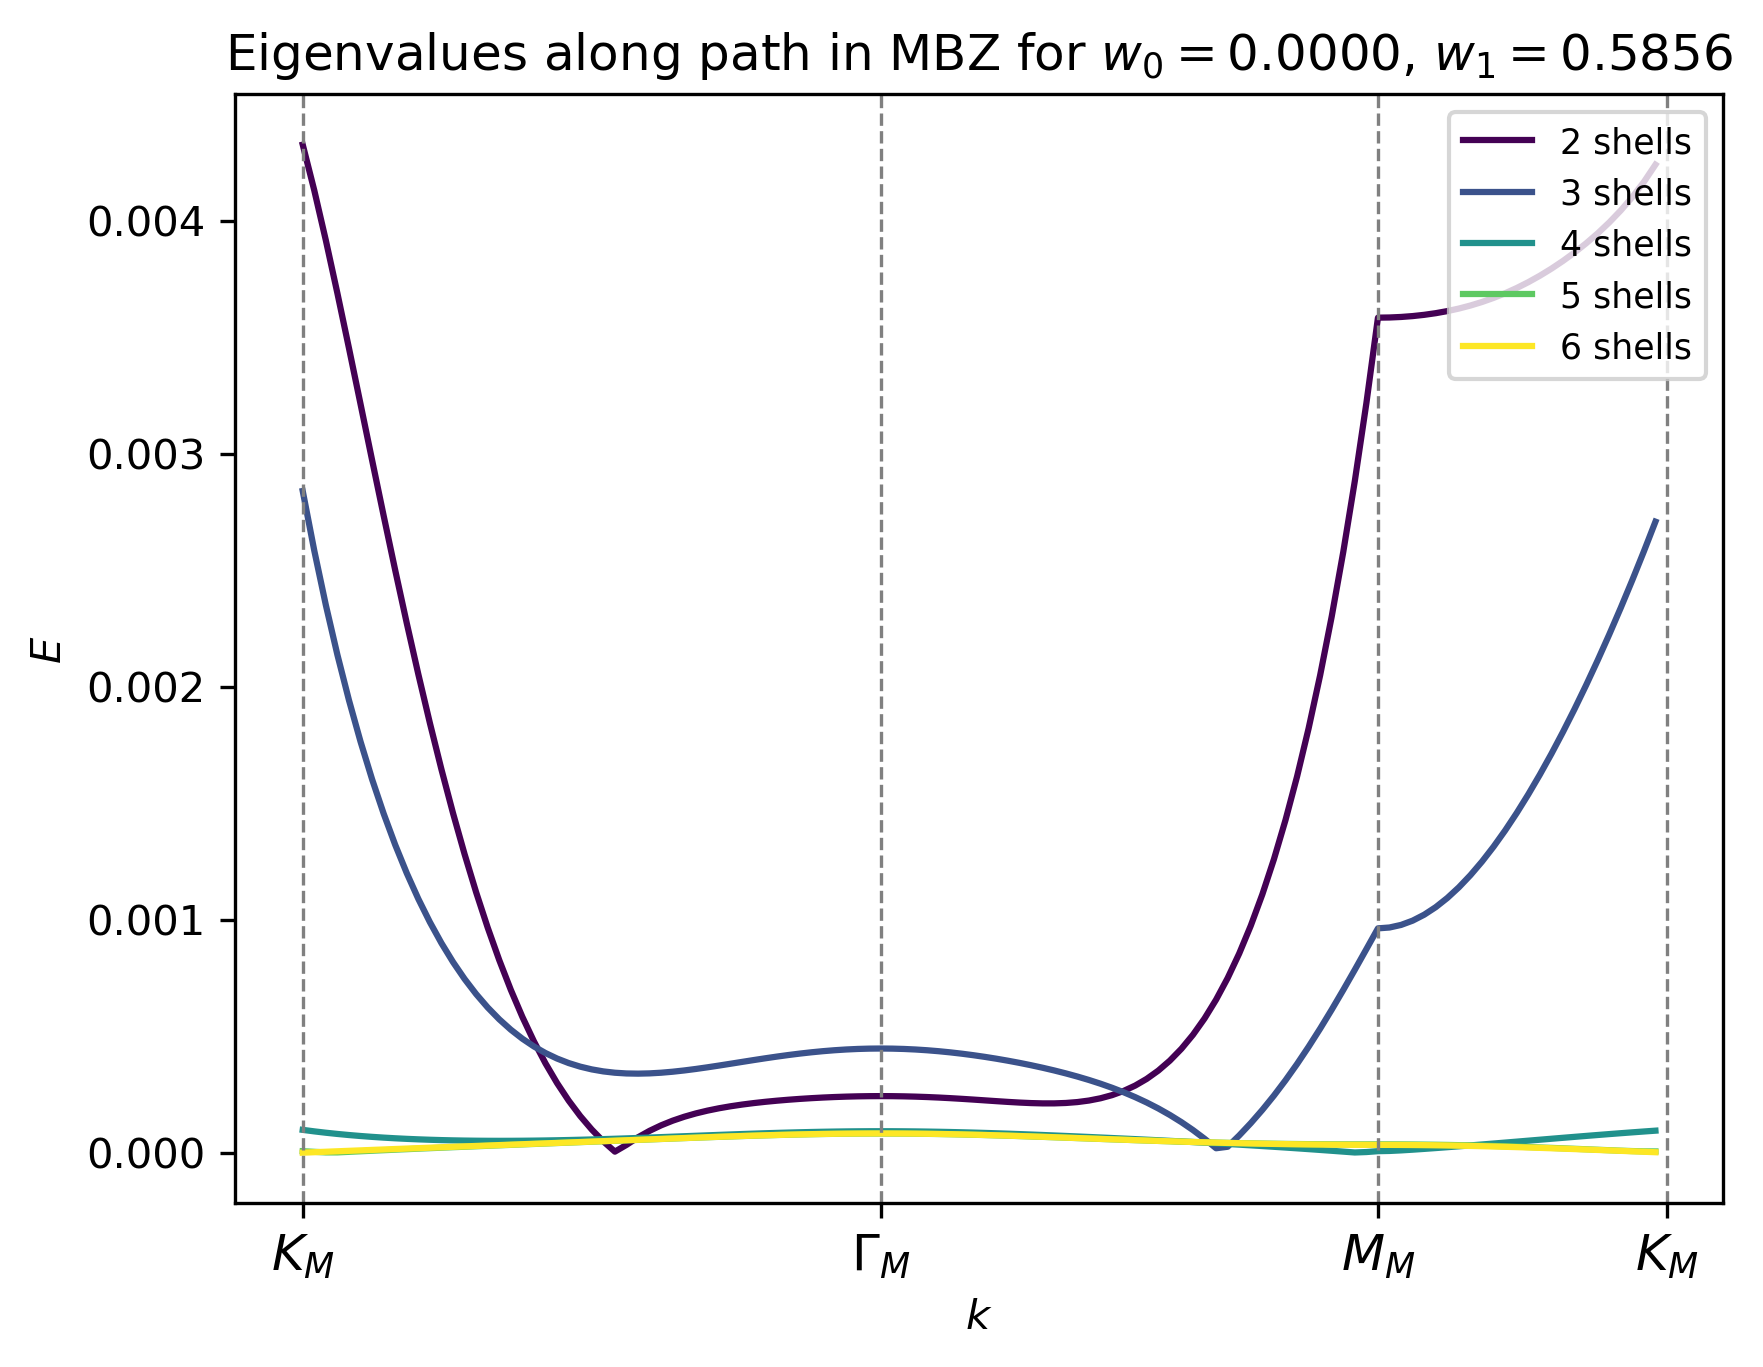

/var/folders/lm/7h466wts1h1c4ptw5tfpglvm0000gn/T/ipykernel_20299/2795705197.py:365: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.



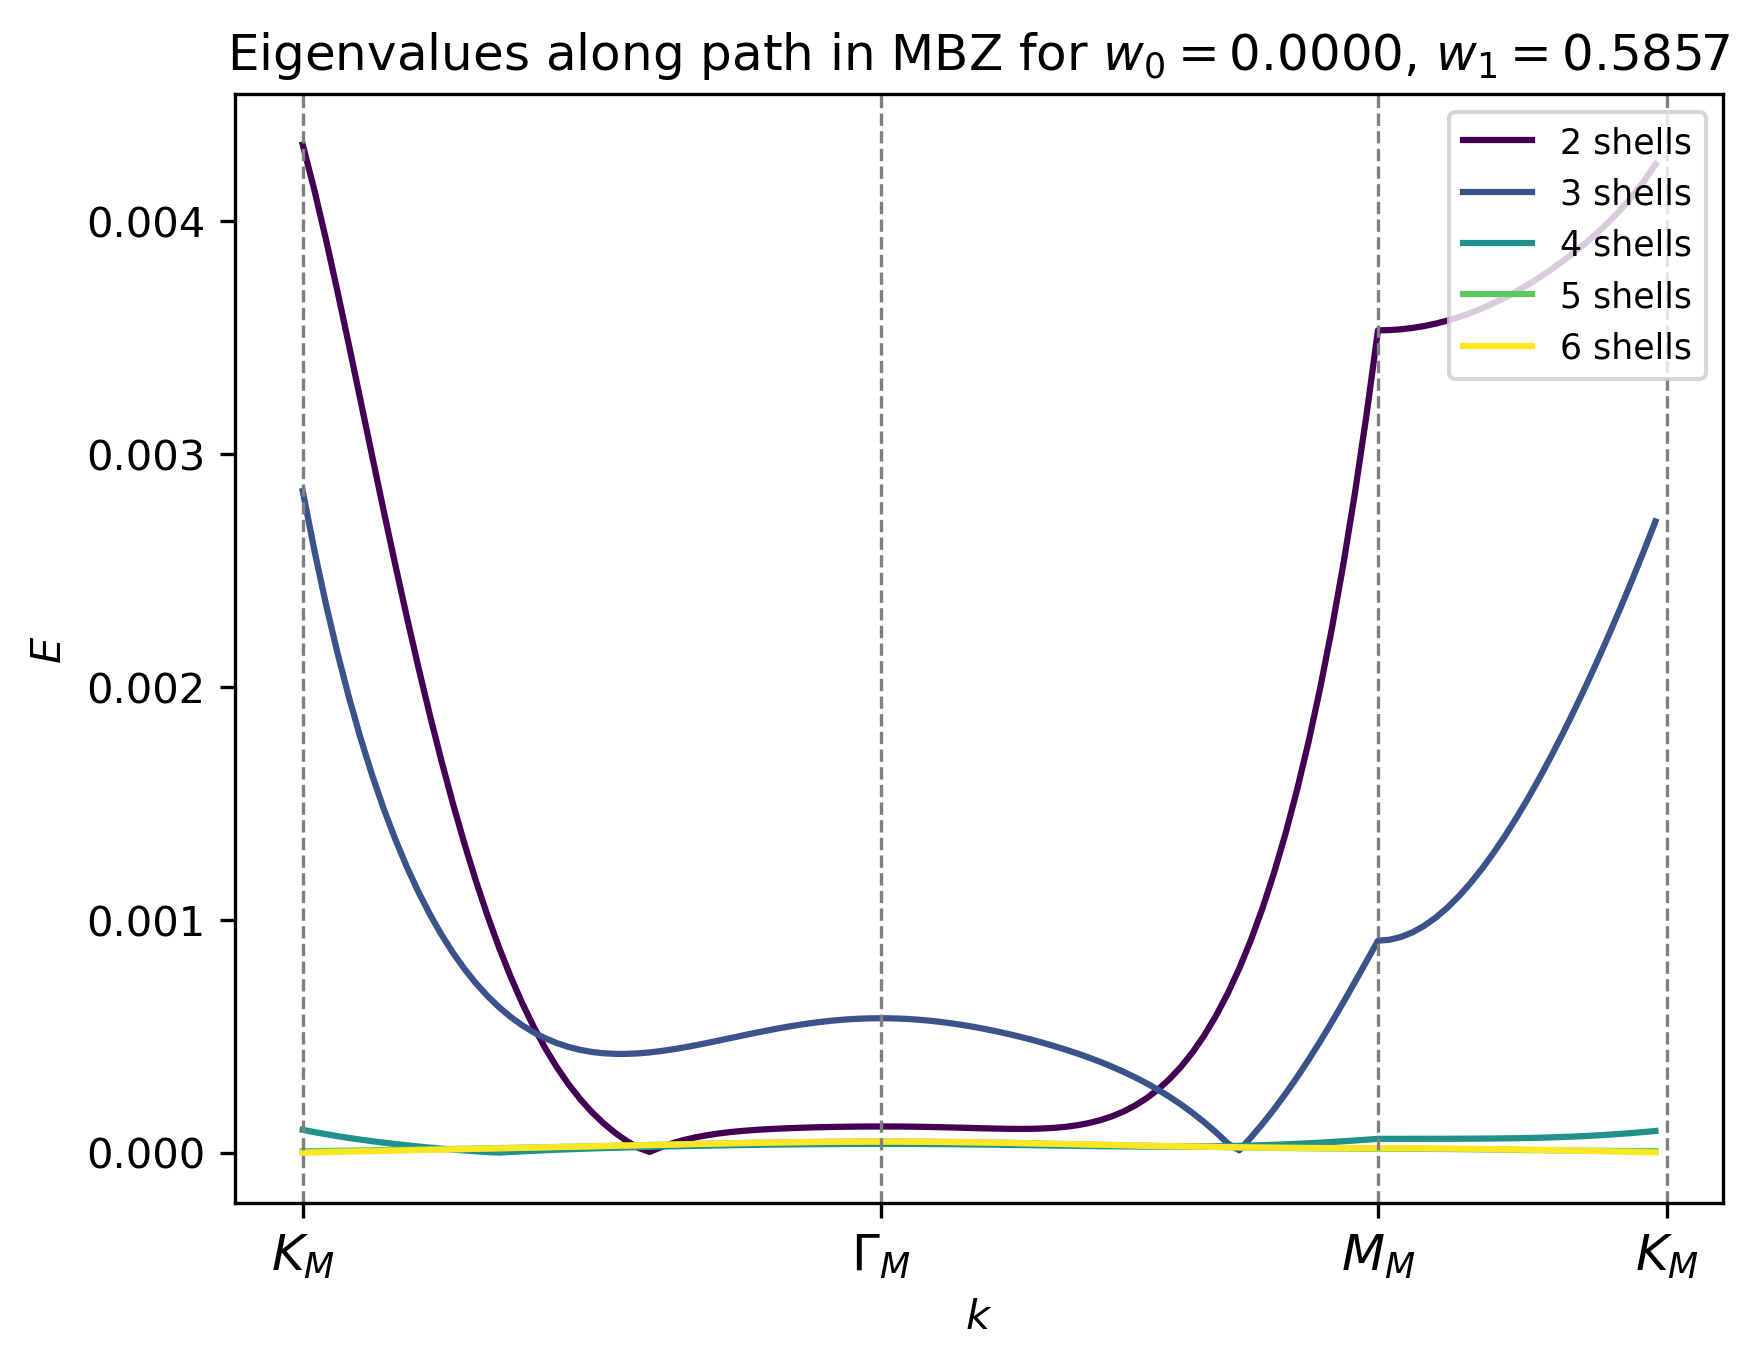

/var/folders/lm/7h466wts1h1c4ptw5tfpglvm0000gn/T/ipykernel_20299/2795705197.py:365: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.



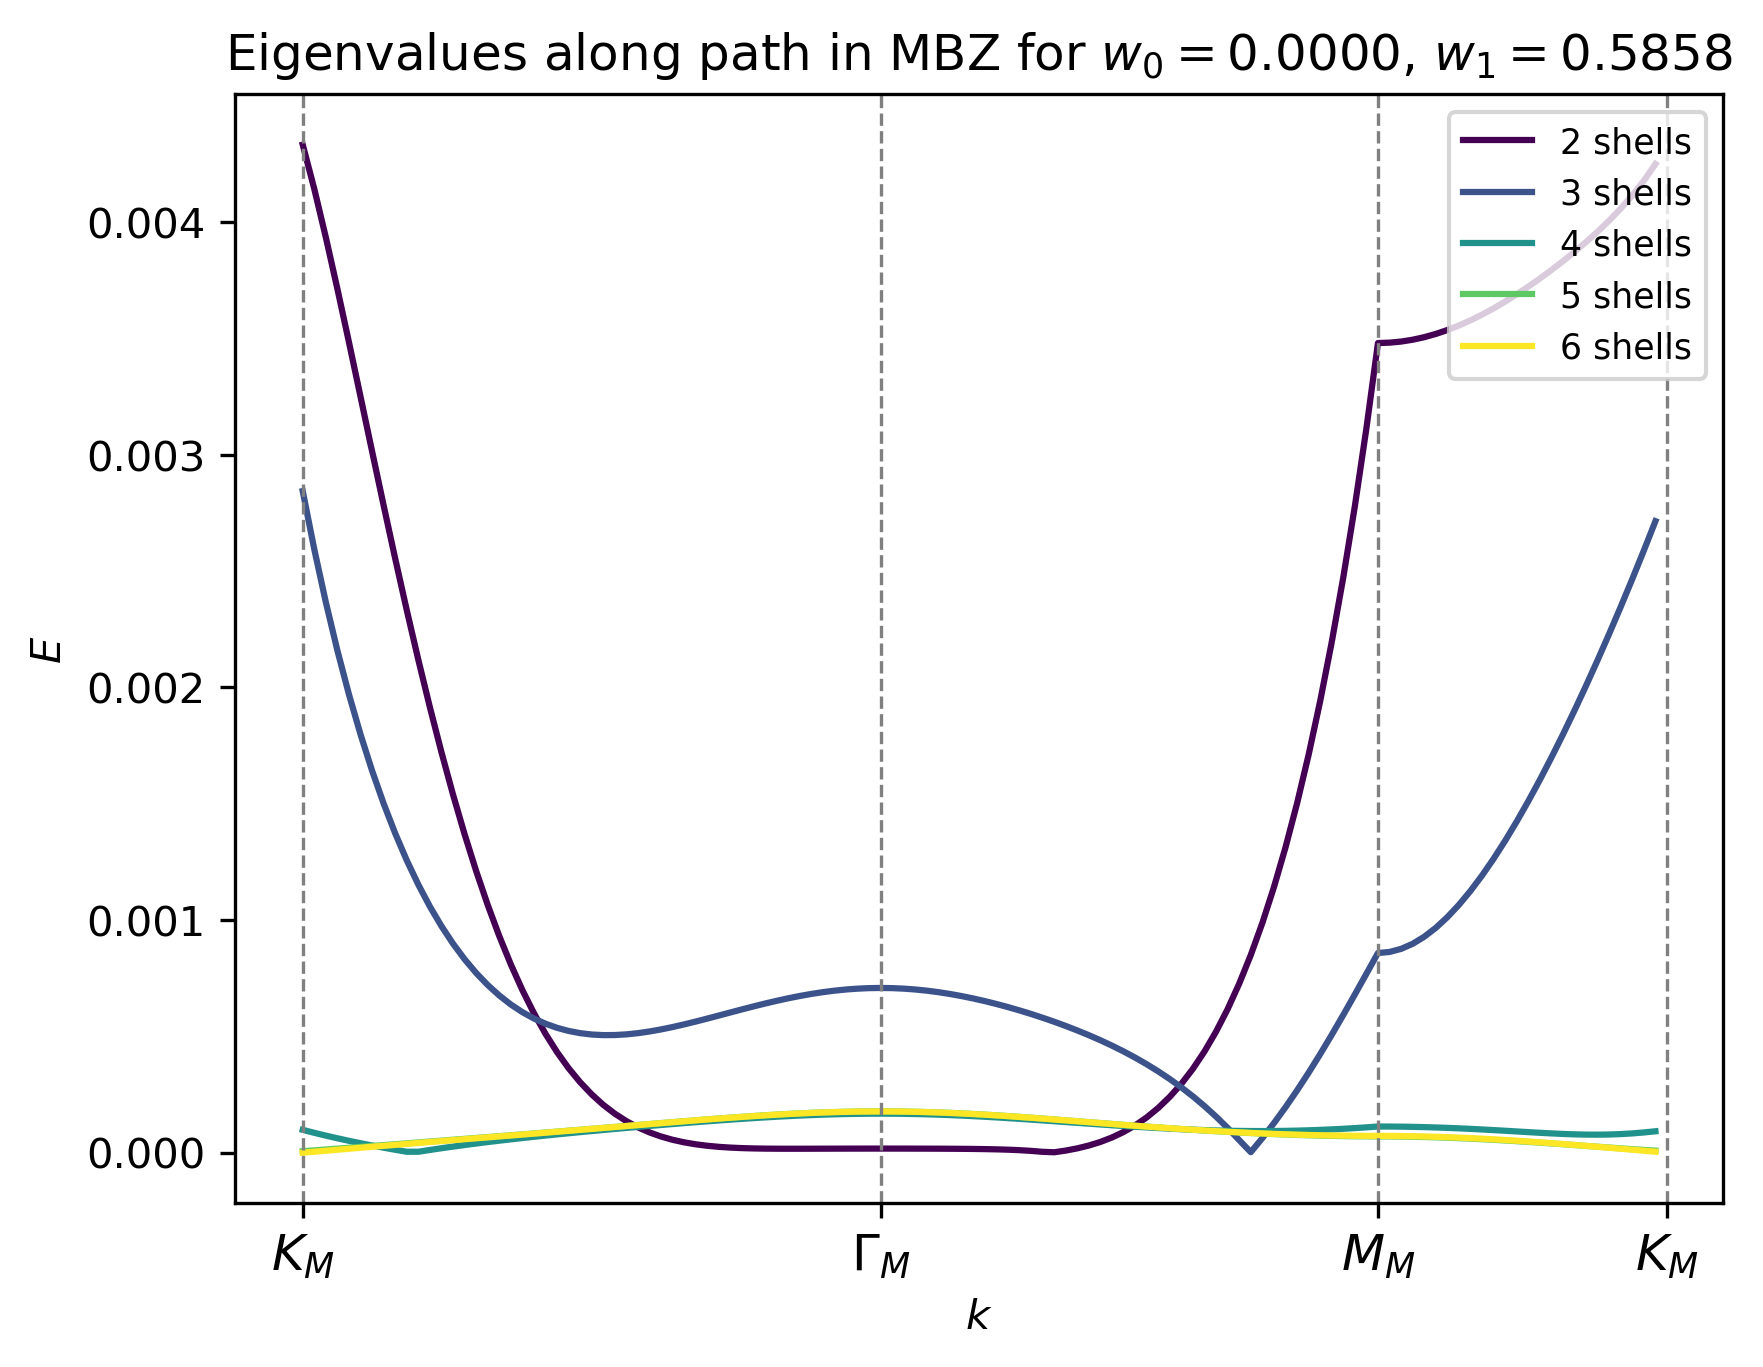

/var/folders/lm/7h466wts1h1c4ptw5tfpglvm0000gn/T/ipykernel_20299/2795705197.py:365: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.



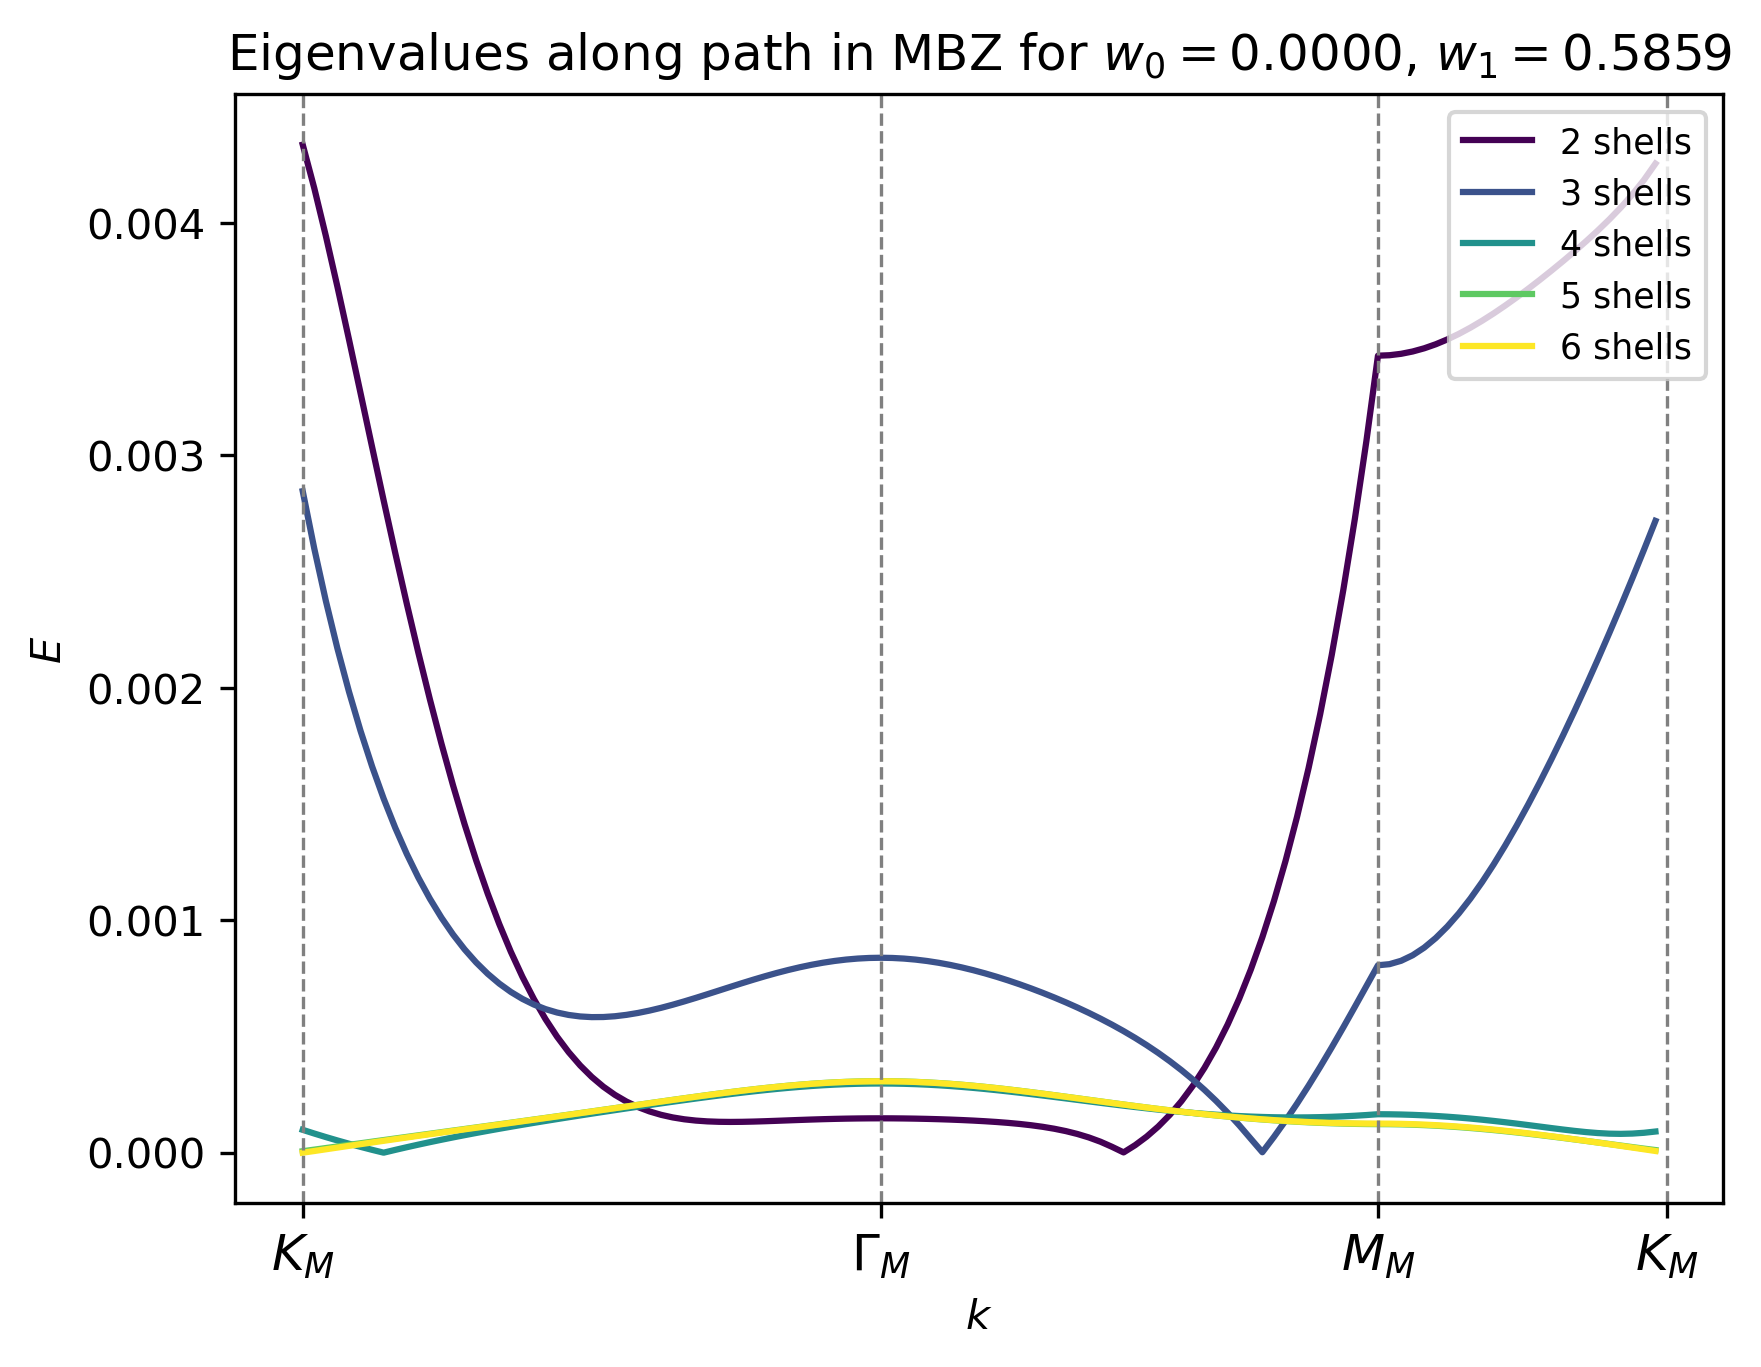

/var/folders/lm/7h466wts1h1c4ptw5tfpglvm0000gn/T/ipykernel_20299/2795705197.py:365: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.



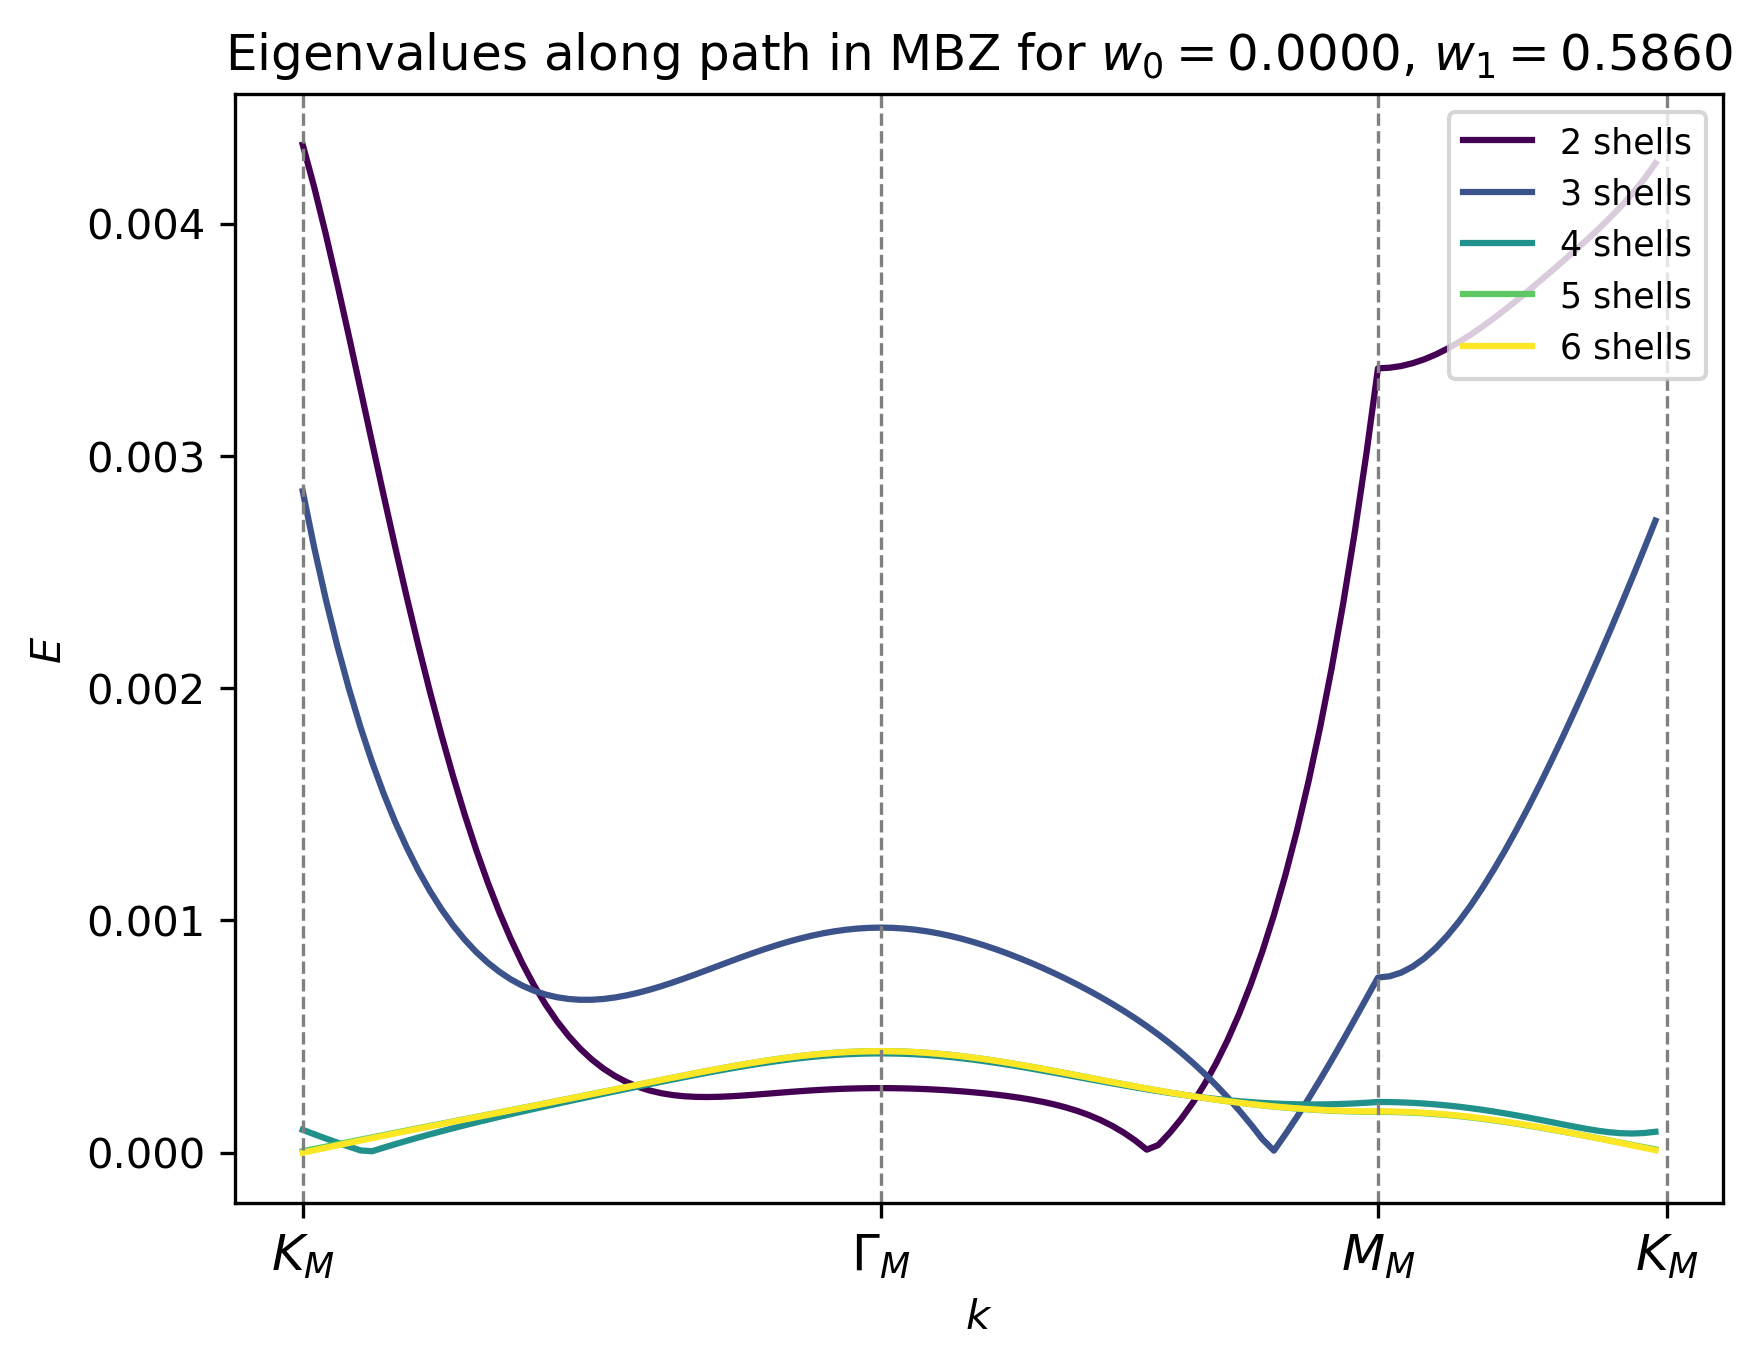

In [42]:
from matplotlib.cm import get_cmap

for energy in [0.585 + 0.0001*i for i in range(11)]:
    GM.plot_path_eigvals_colormap(50, 0, energy, [2, 3, 4, 5, 6], Elimits=None, bands=(1, 0), colormap='viridis')

/var/folders/lm/7h466wts1h1c4ptw5tfpglvm0000gn/T/ipykernel_20299/2795705197.py:365: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.



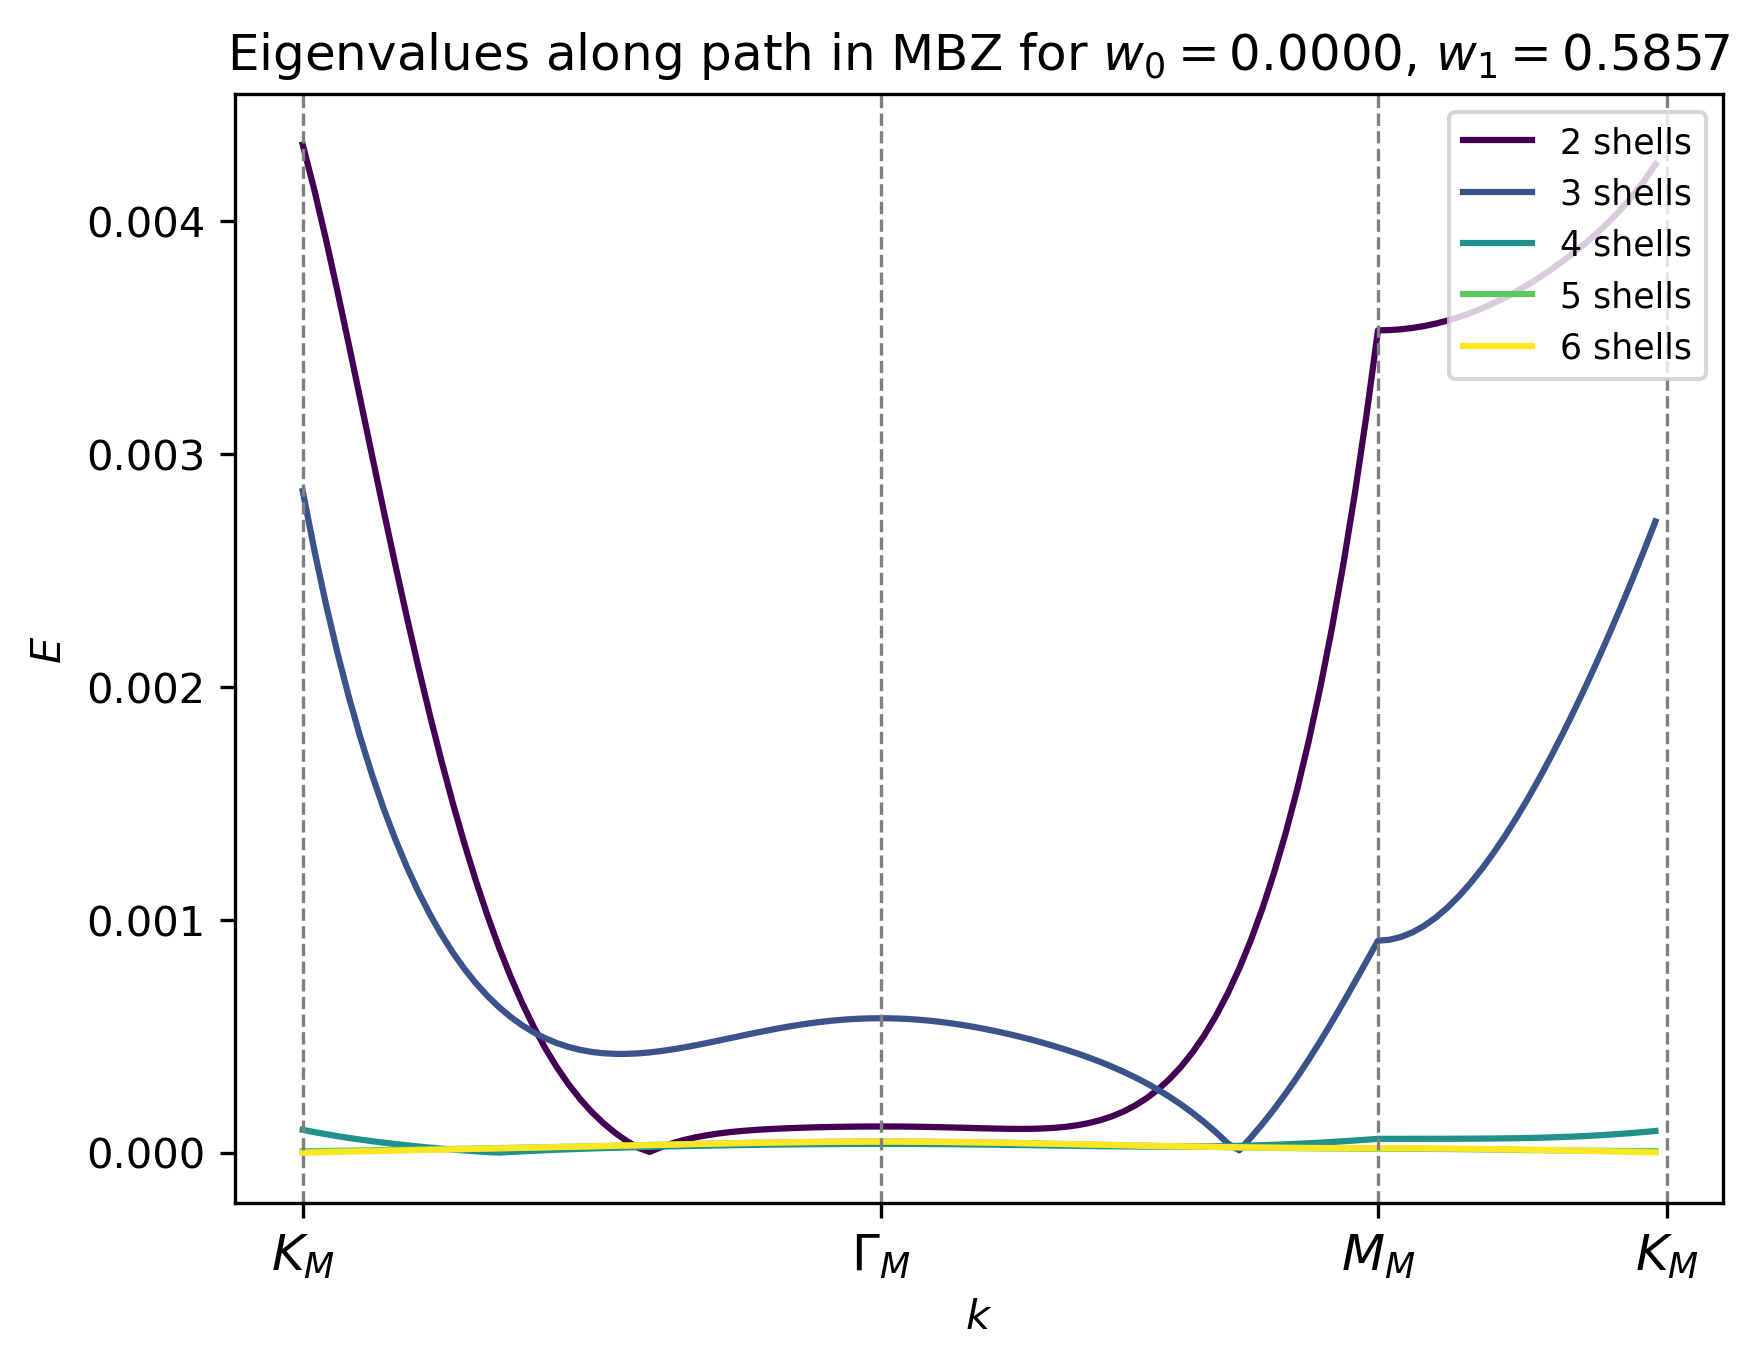

In [43]:
# from matplotlib.cm import get_cmap

GM.plot_path_eigvals_colormap(50, 0, 0.5857, [2, 3, 4, 5, 6], Elimits=None, bands=(1, 0), colormap='viridis')

/var/folders/lm/7h466wts1h1c4ptw5tfpglvm0000gn/T/ipykernel_20299/2795705197.py:365: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.



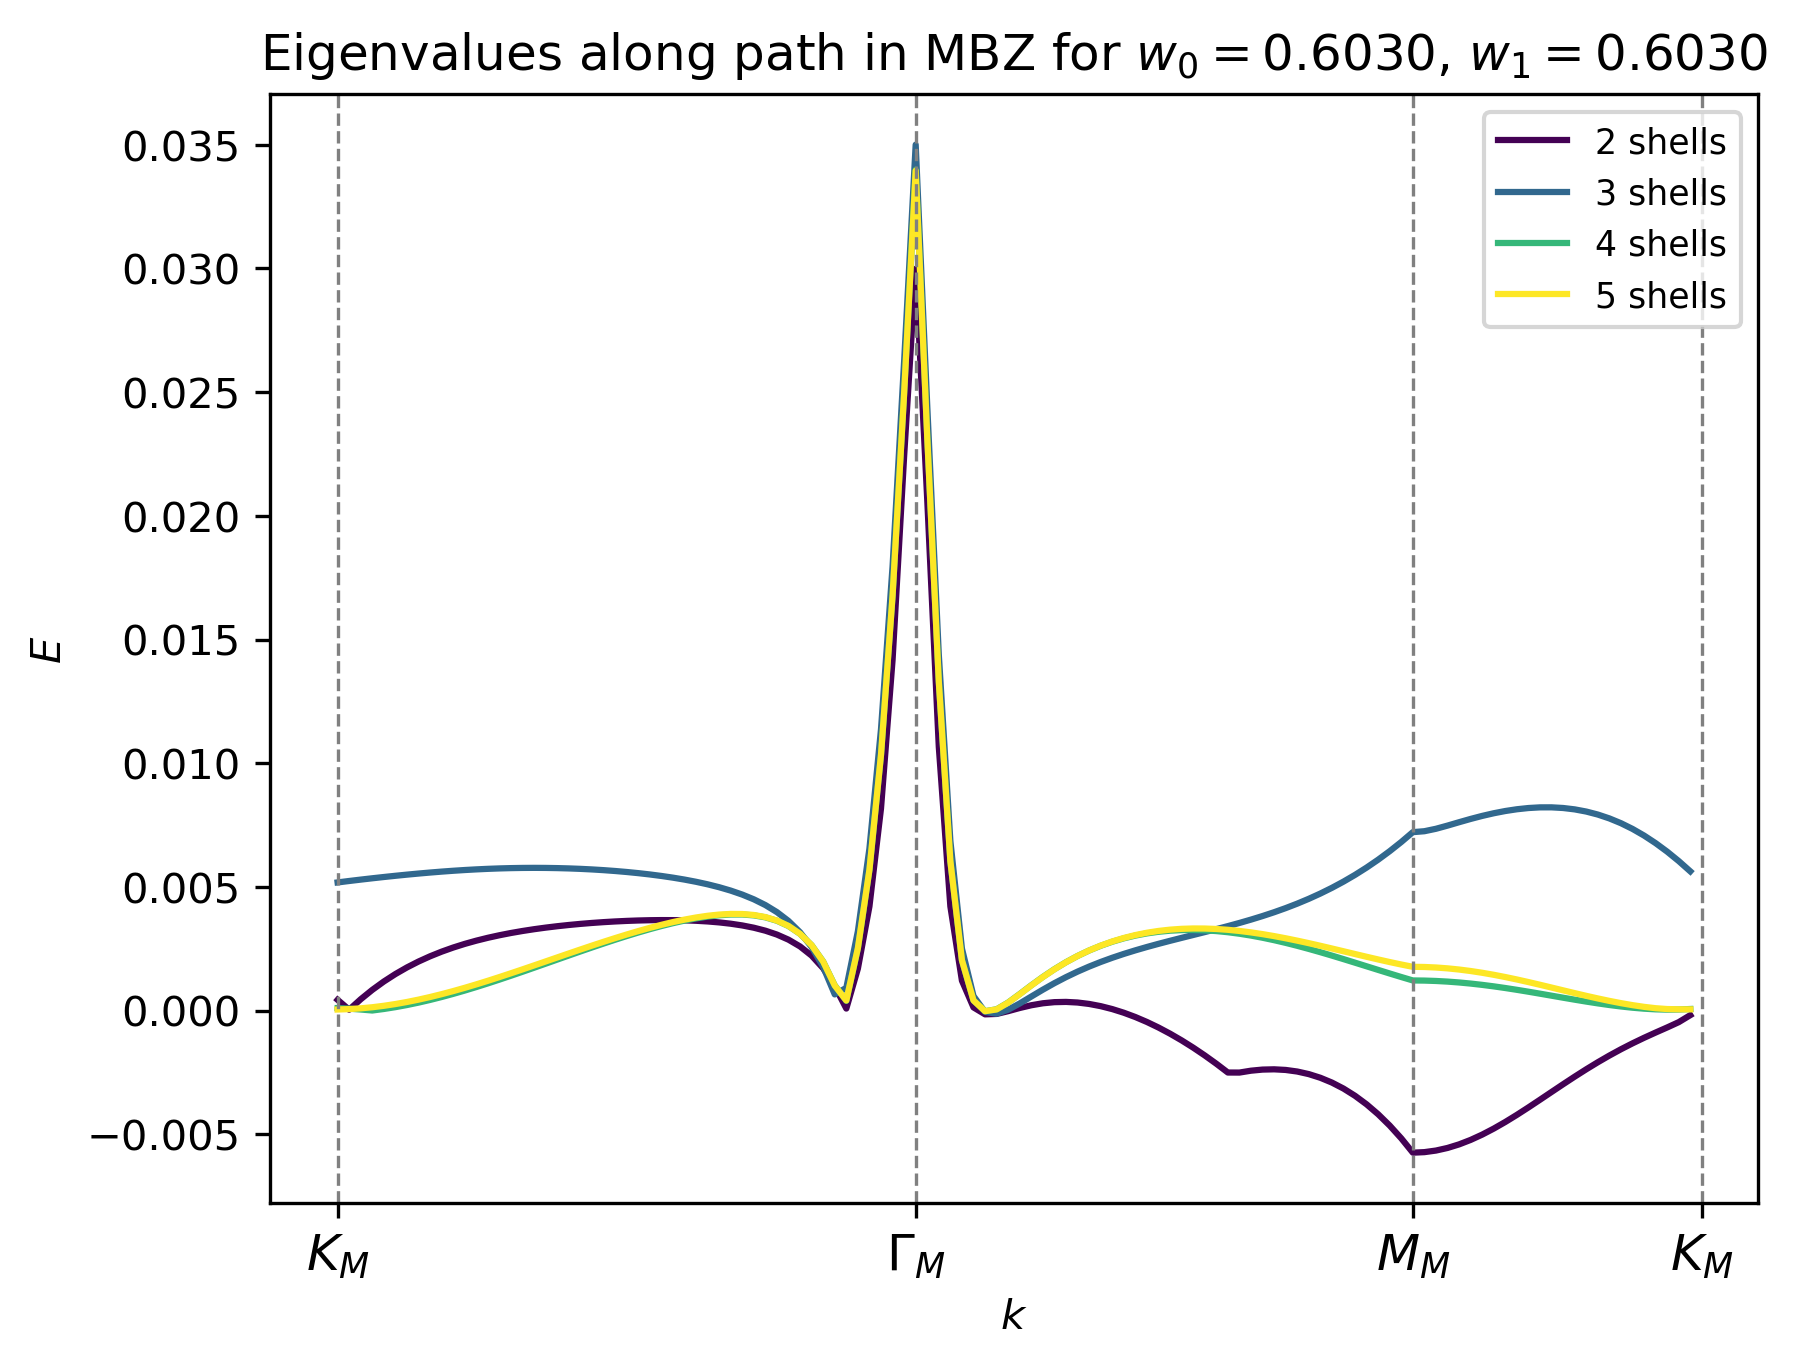

/var/folders/lm/7h466wts1h1c4ptw5tfpglvm0000gn/T/ipykernel_20299/2795705197.py:365: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.



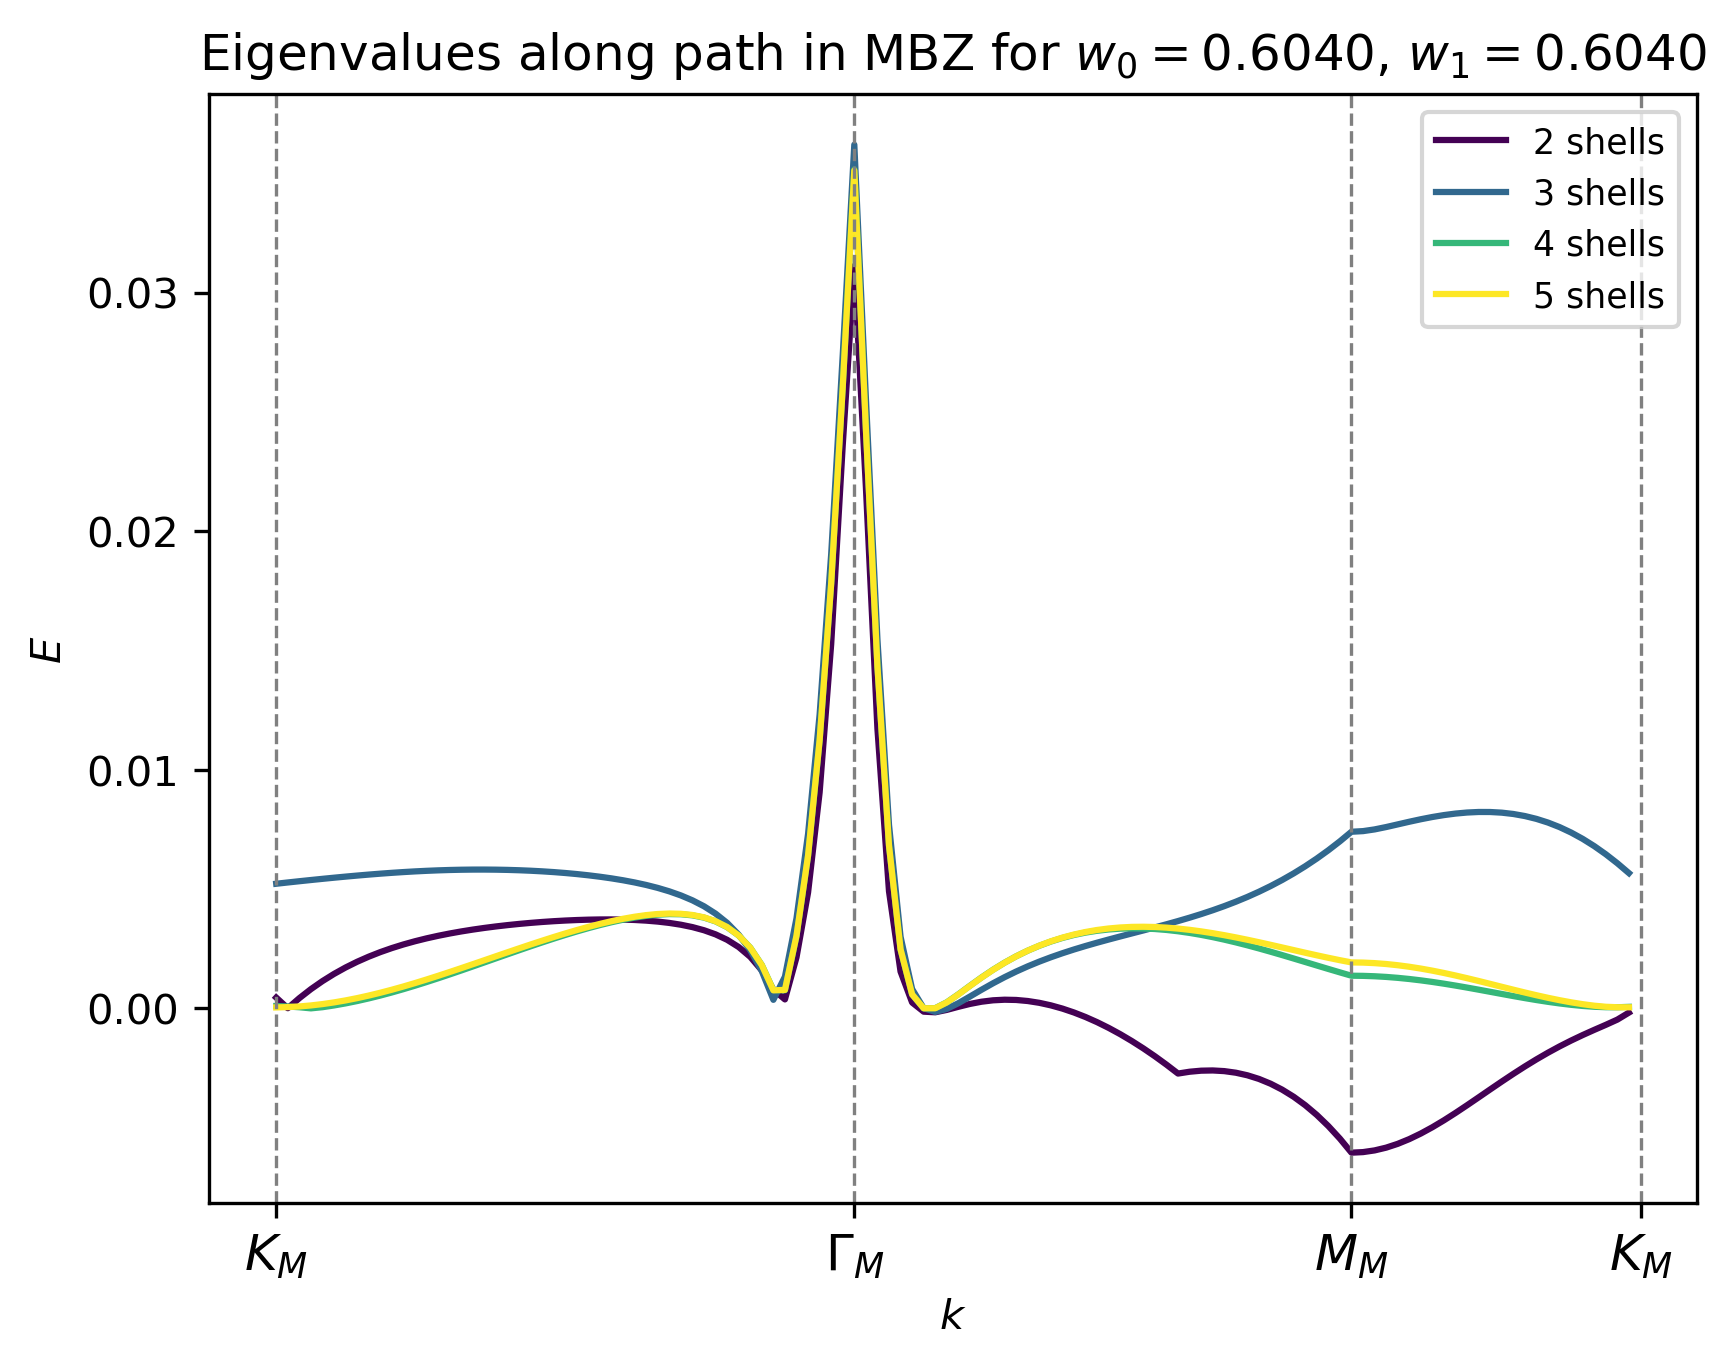

/var/folders/lm/7h466wts1h1c4ptw5tfpglvm0000gn/T/ipykernel_20299/2795705197.py:365: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.



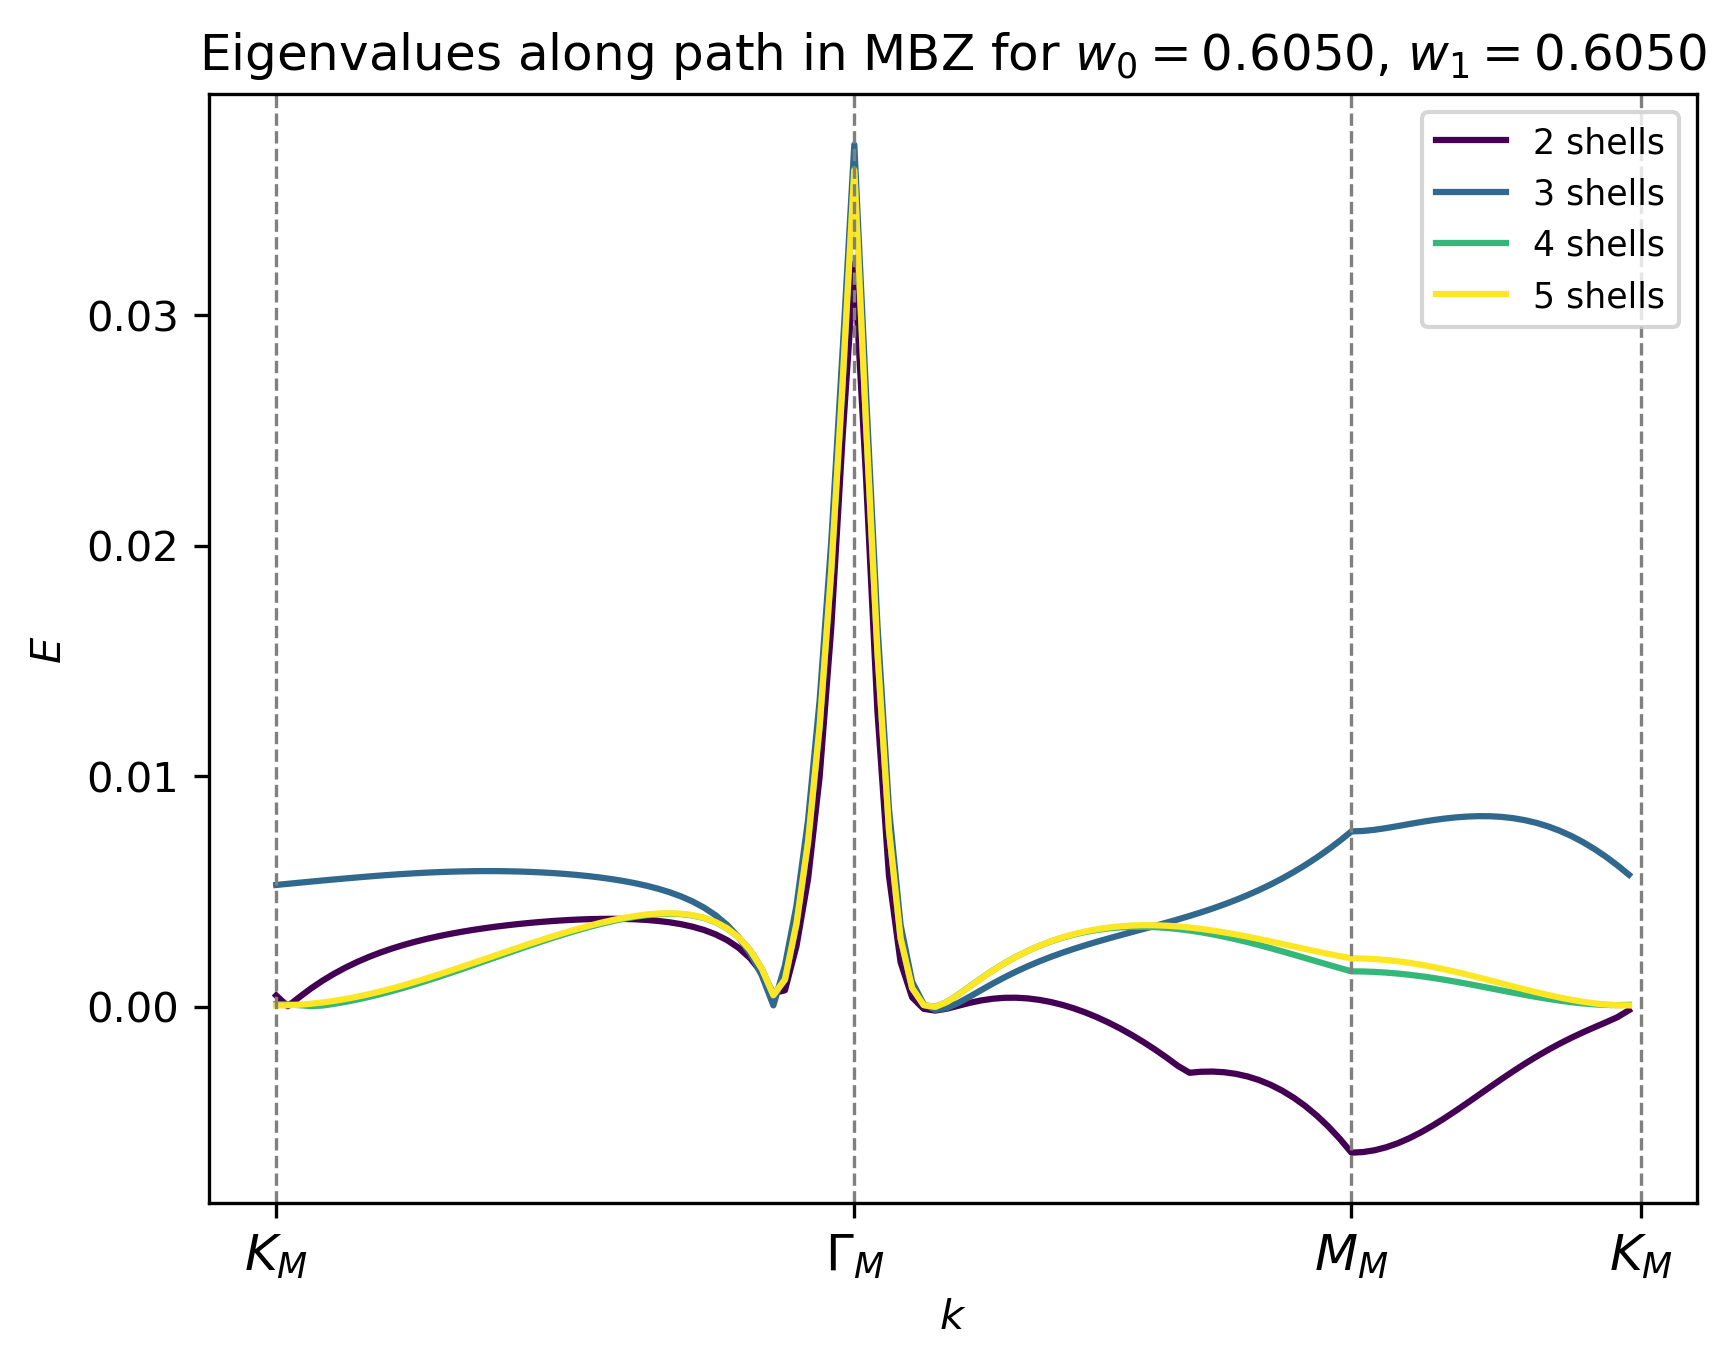

/var/folders/lm/7h466wts1h1c4ptw5tfpglvm0000gn/T/ipykernel_20299/2795705197.py:365: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.



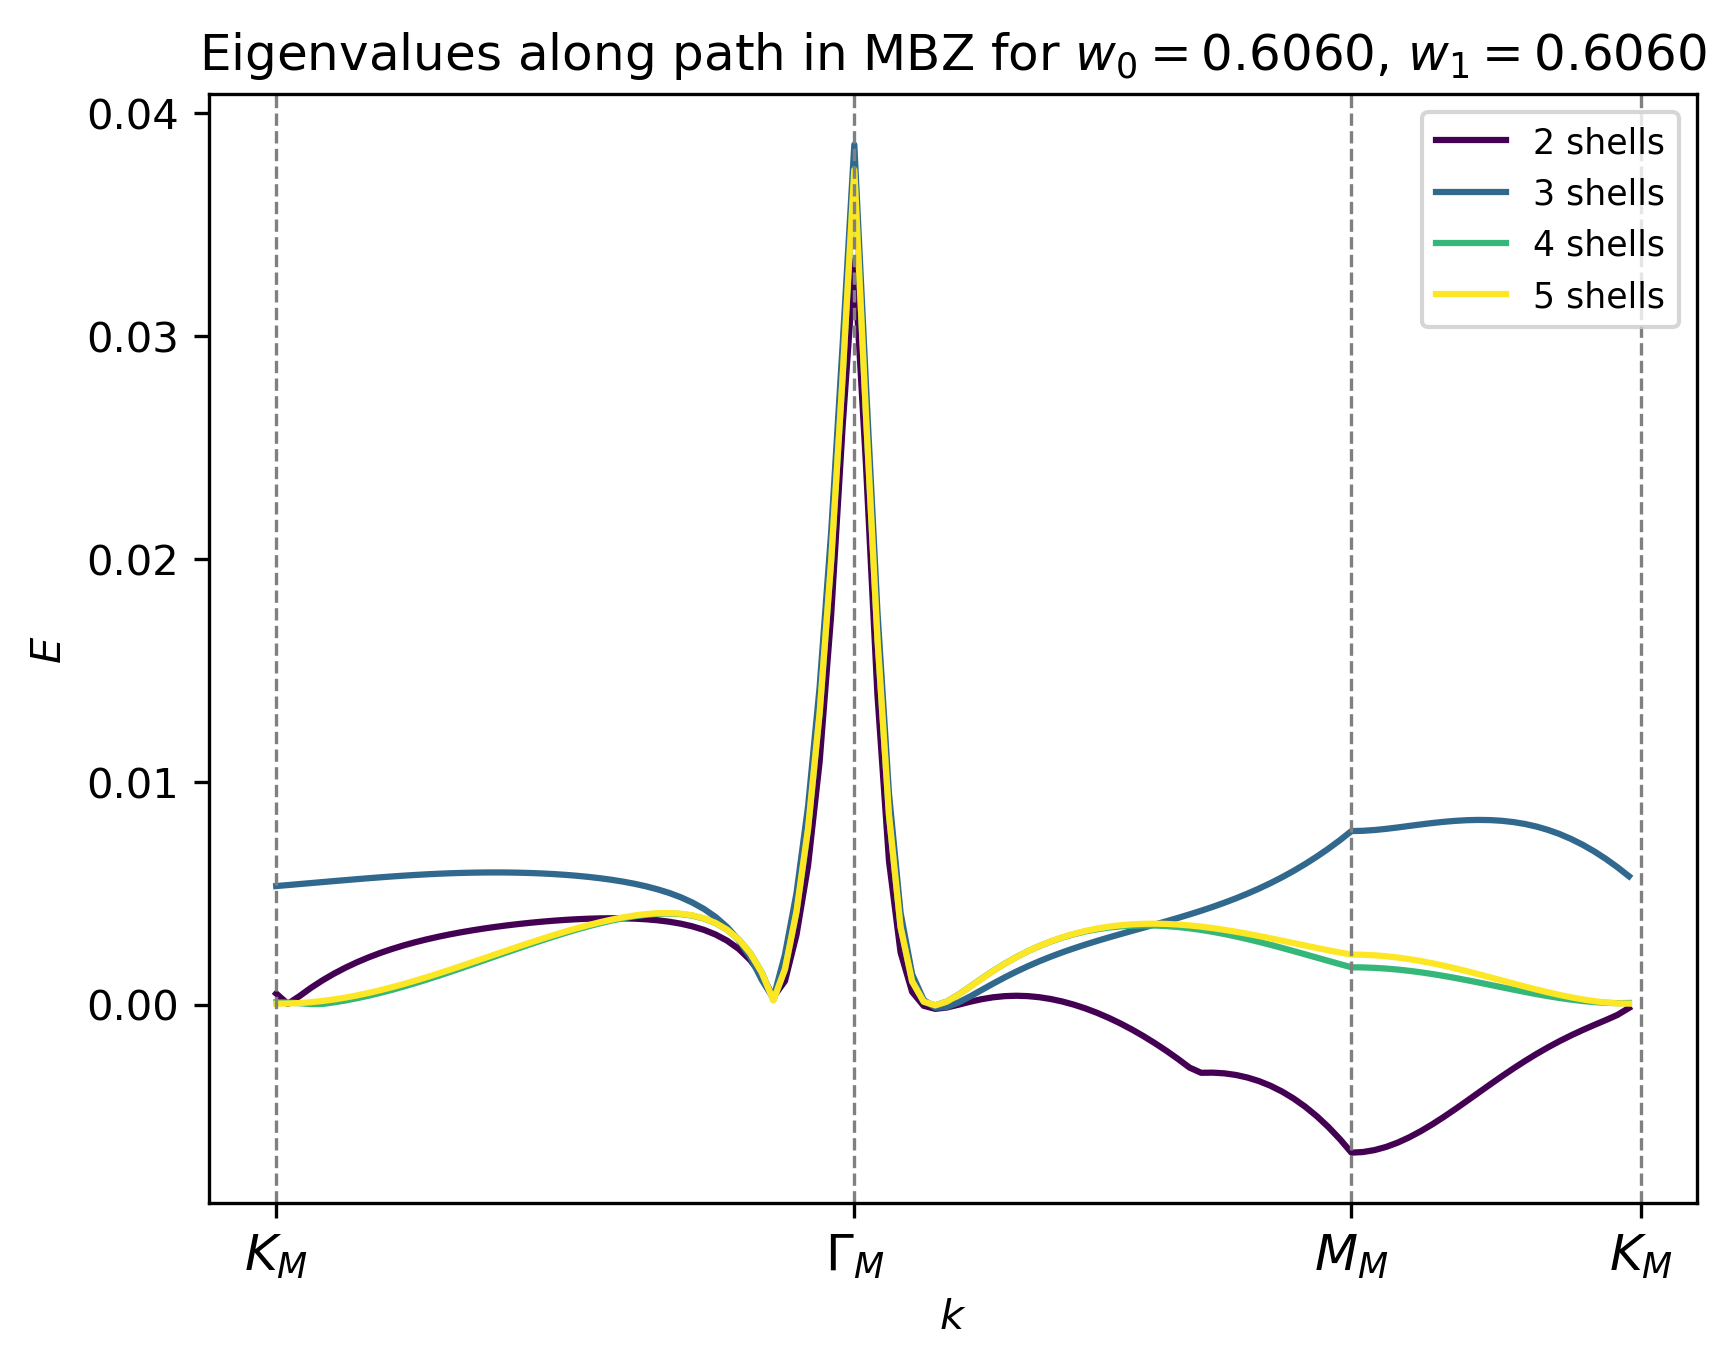

/var/folders/lm/7h466wts1h1c4ptw5tfpglvm0000gn/T/ipykernel_20299/2795705197.py:365: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.



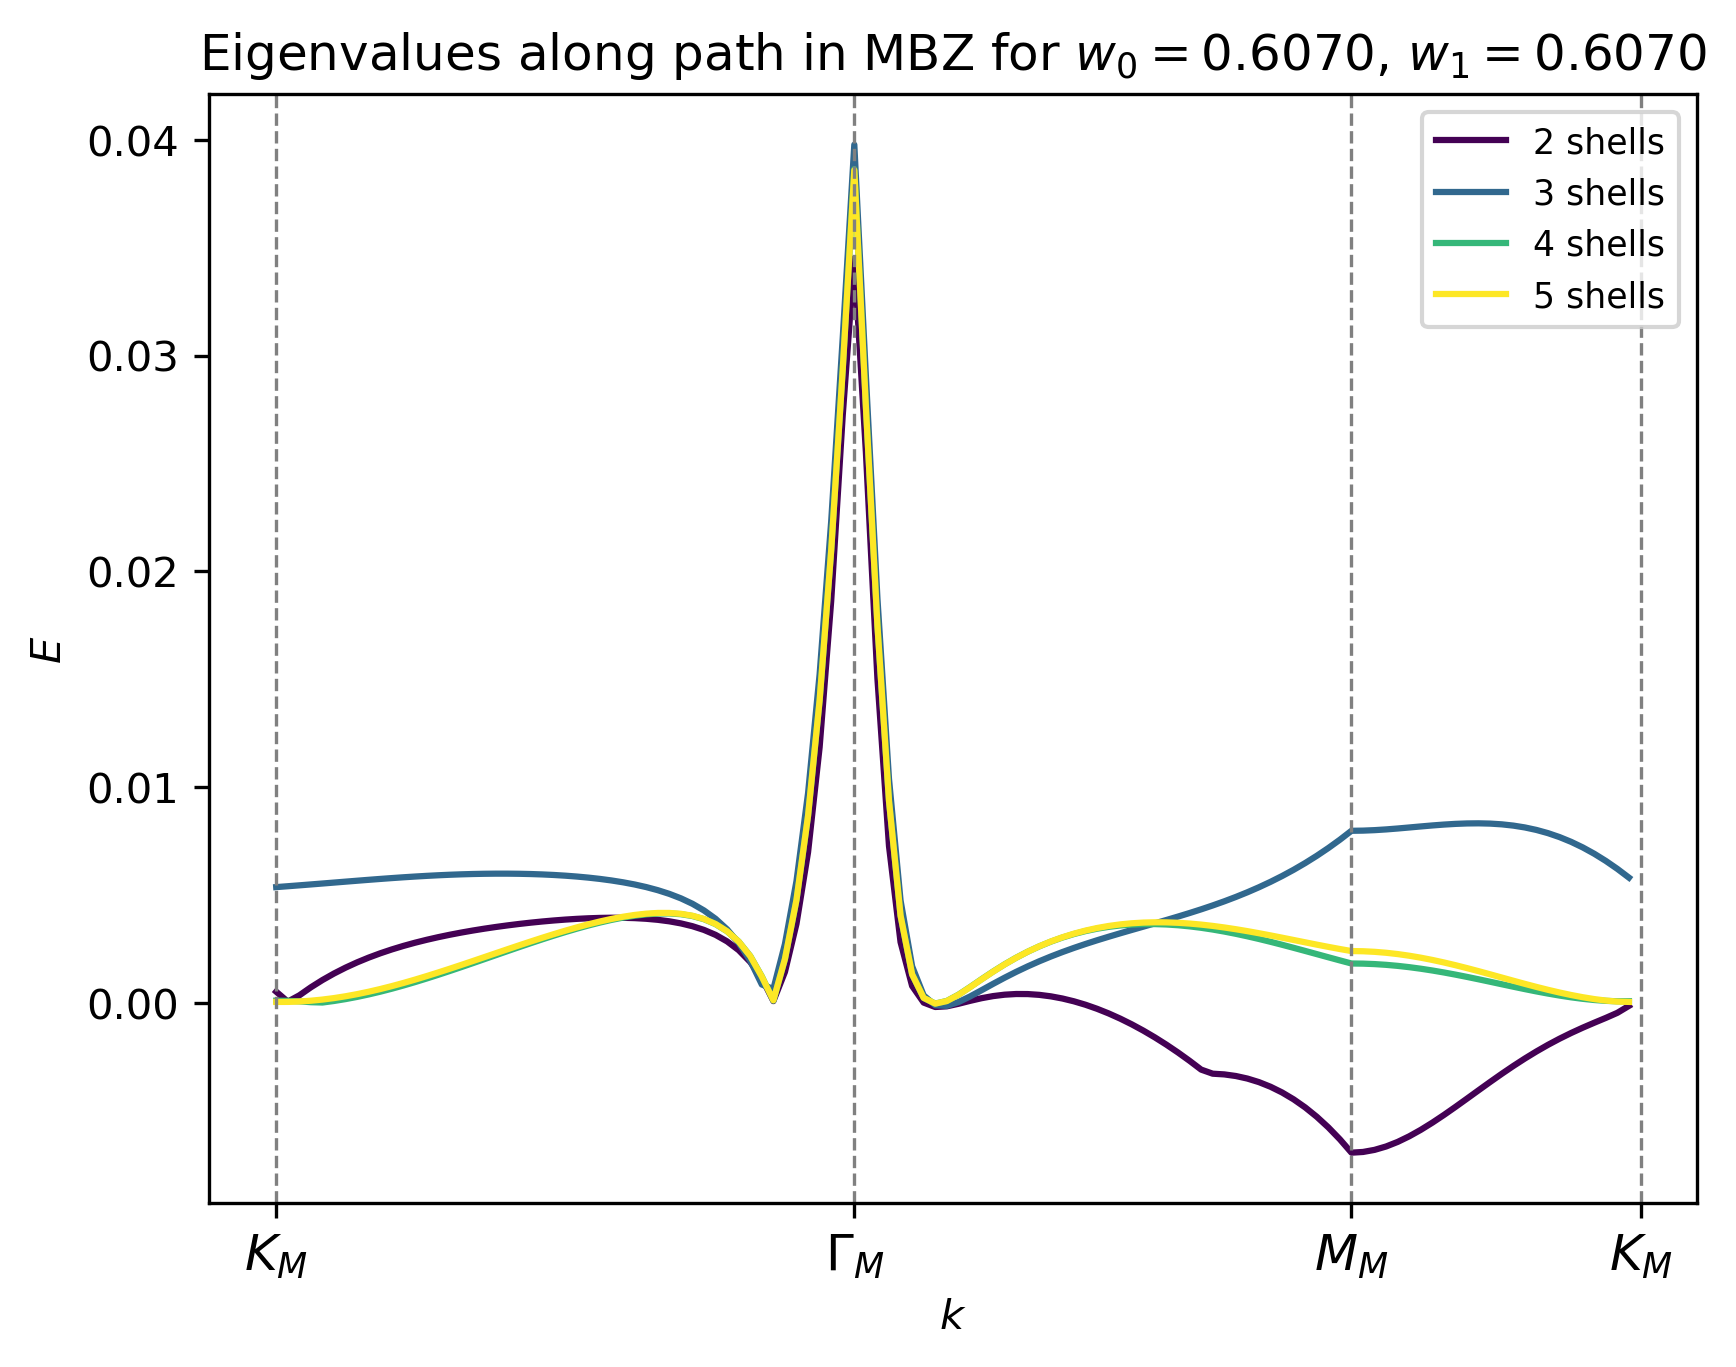

/var/folders/lm/7h466wts1h1c4ptw5tfpglvm0000gn/T/ipykernel_20299/2795705197.py:365: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.



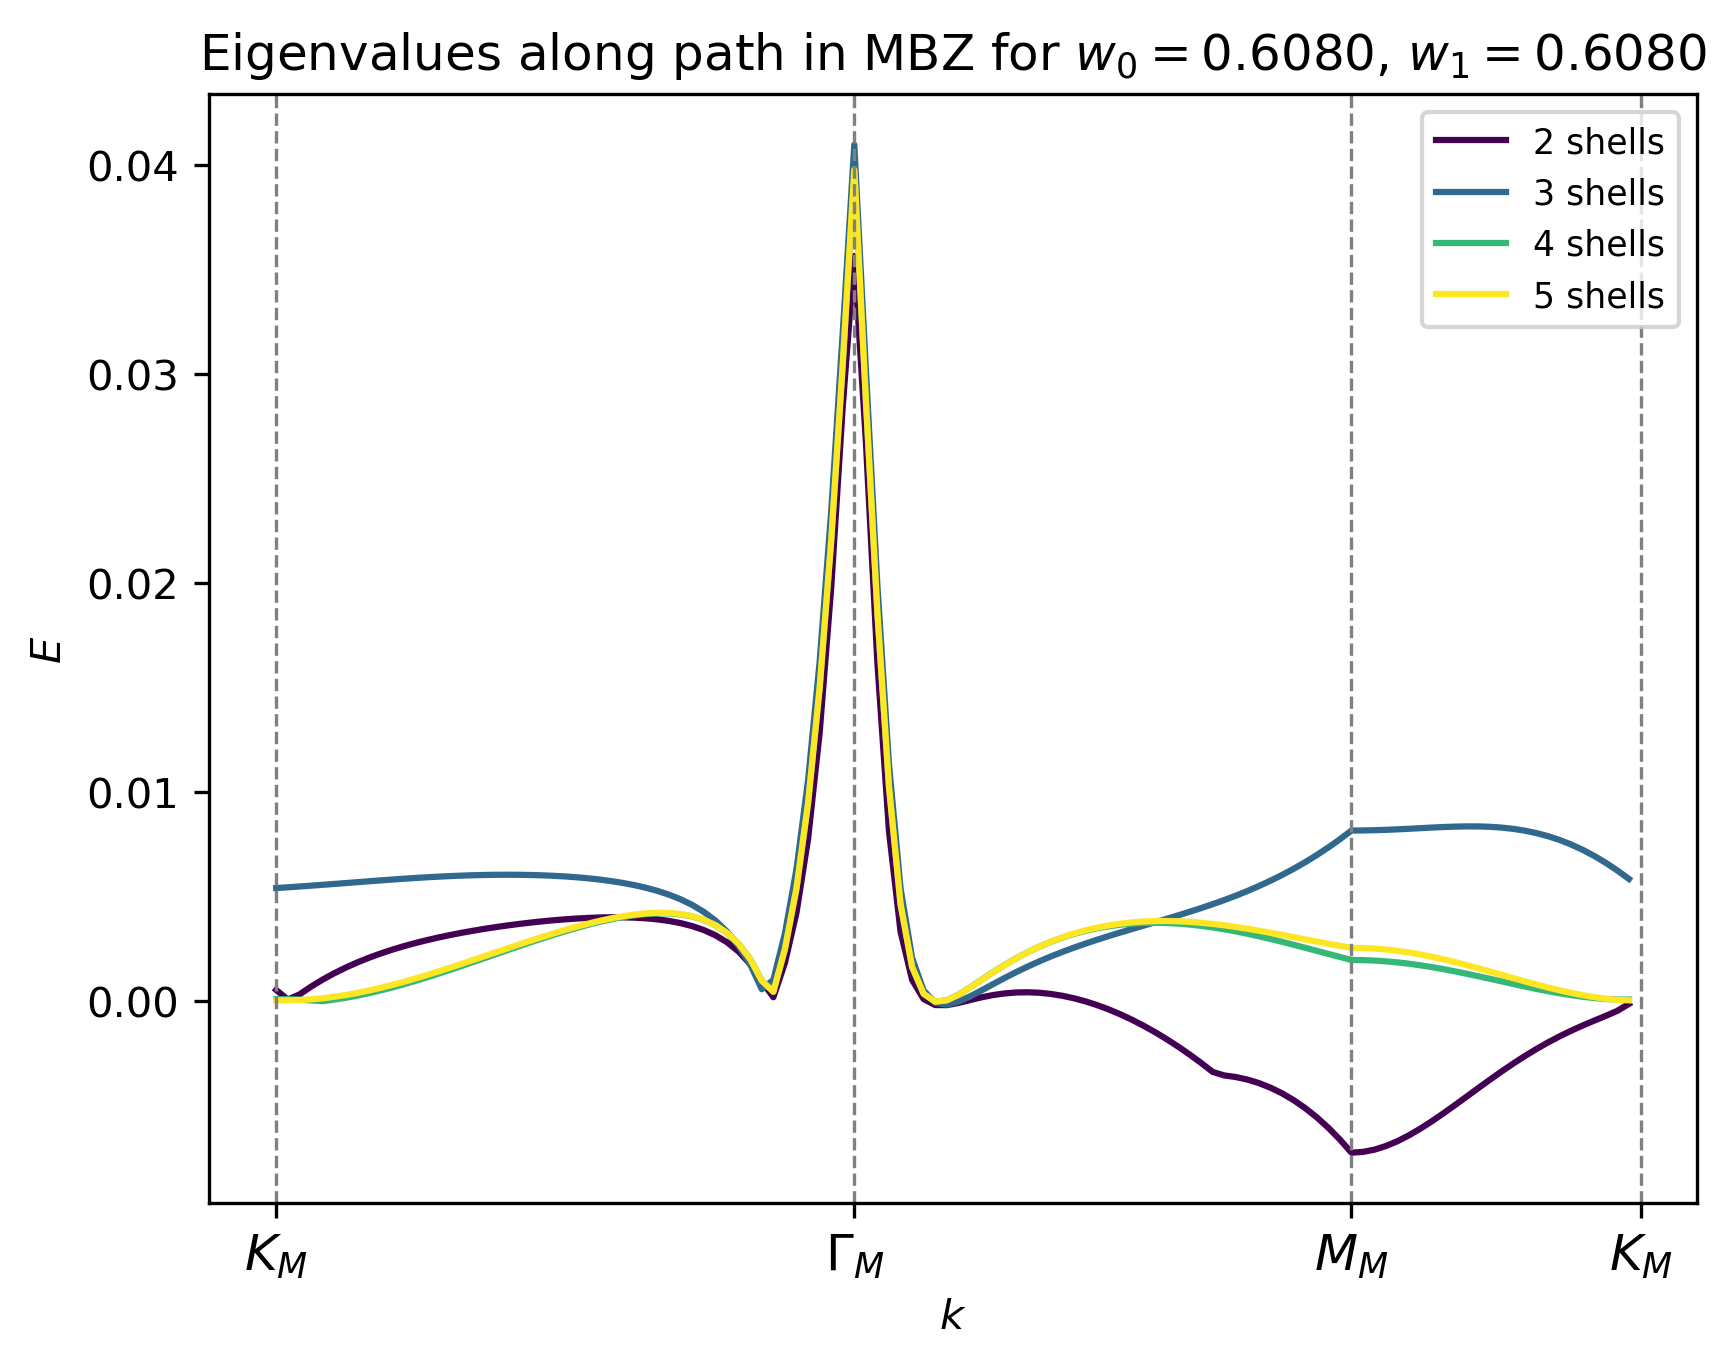

/var/folders/lm/7h466wts1h1c4ptw5tfpglvm0000gn/T/ipykernel_20299/2795705197.py:365: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.



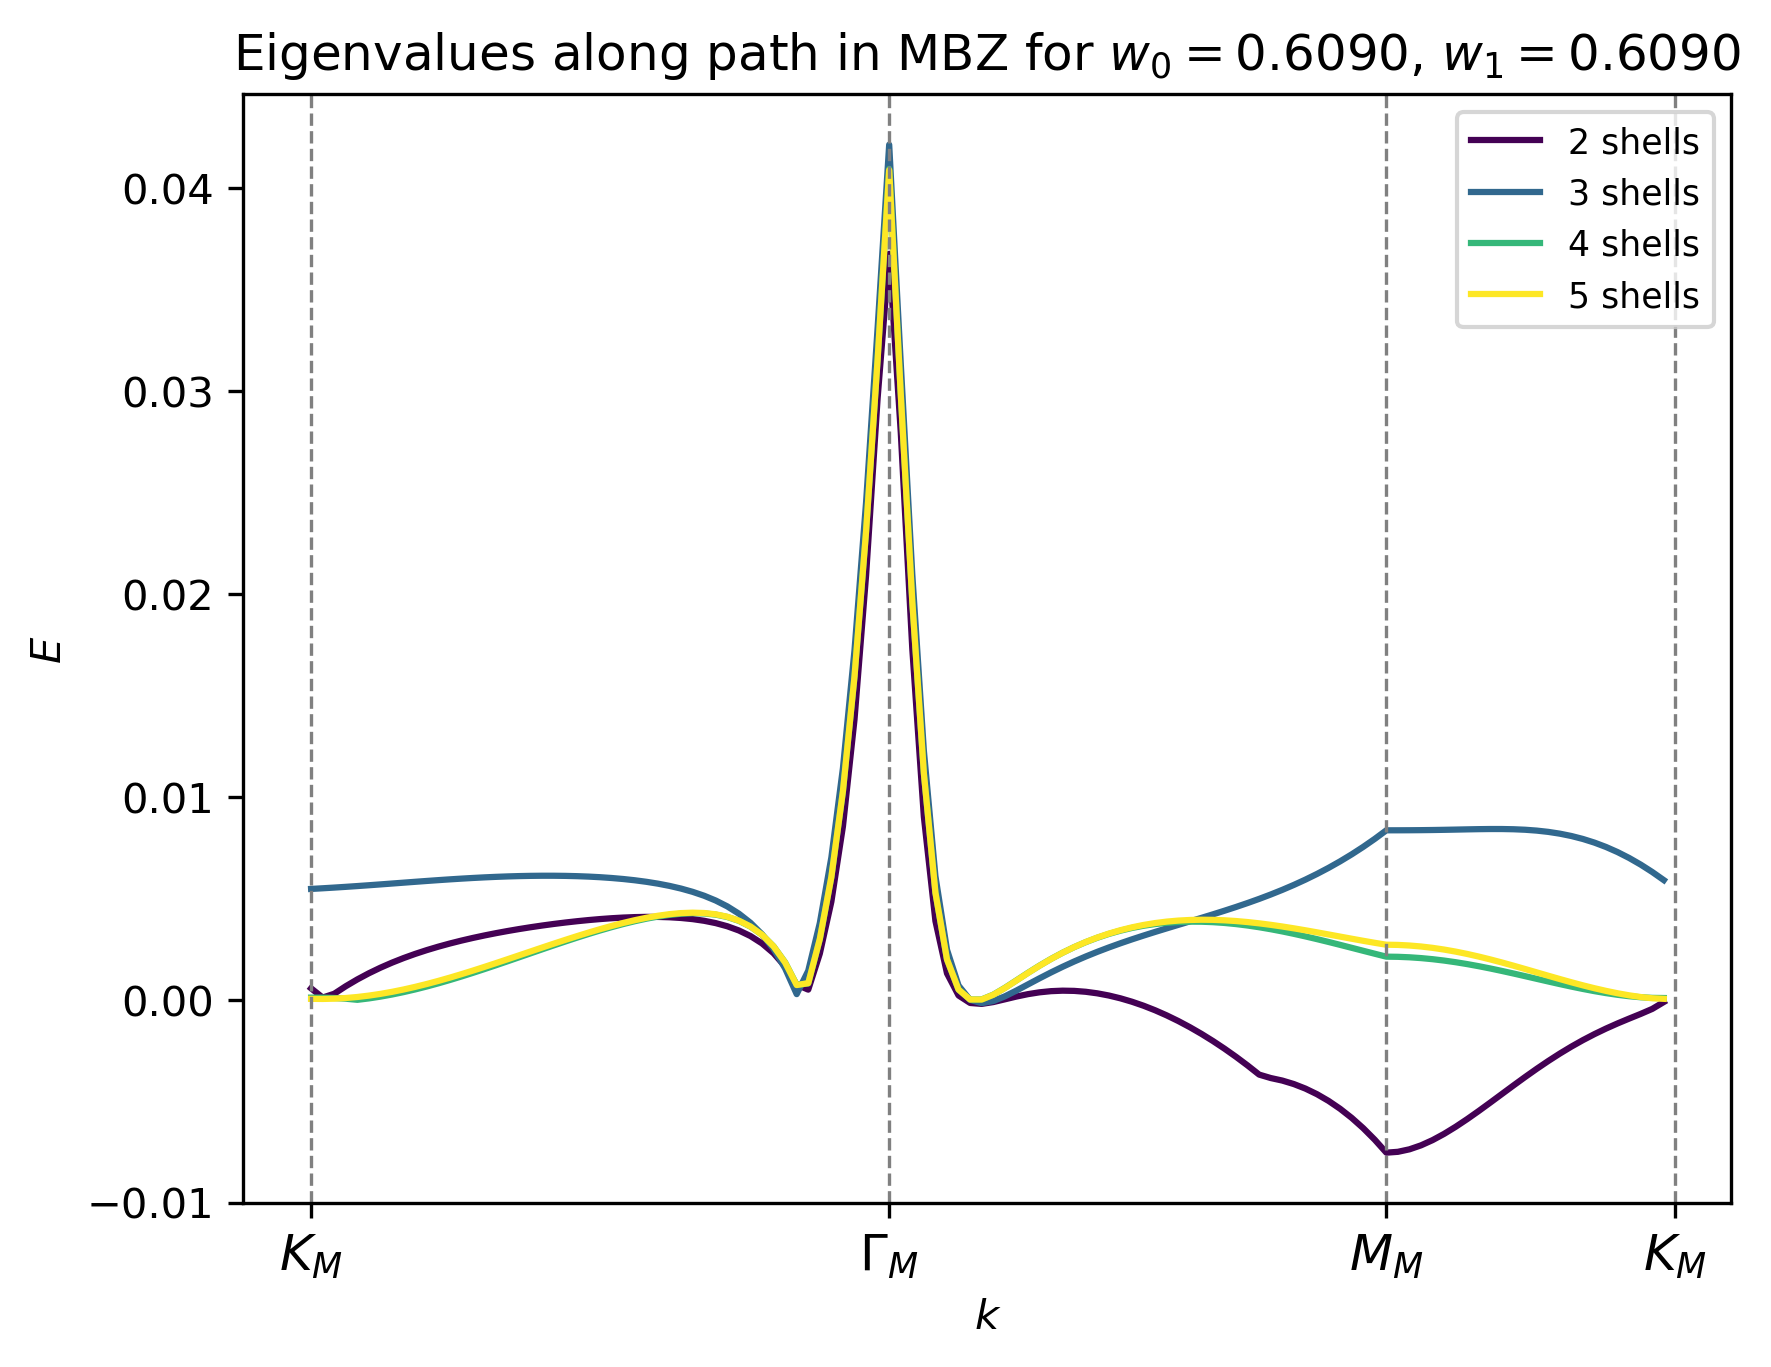

/var/folders/lm/7h466wts1h1c4ptw5tfpglvm0000gn/T/ipykernel_20299/2795705197.py:365: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.



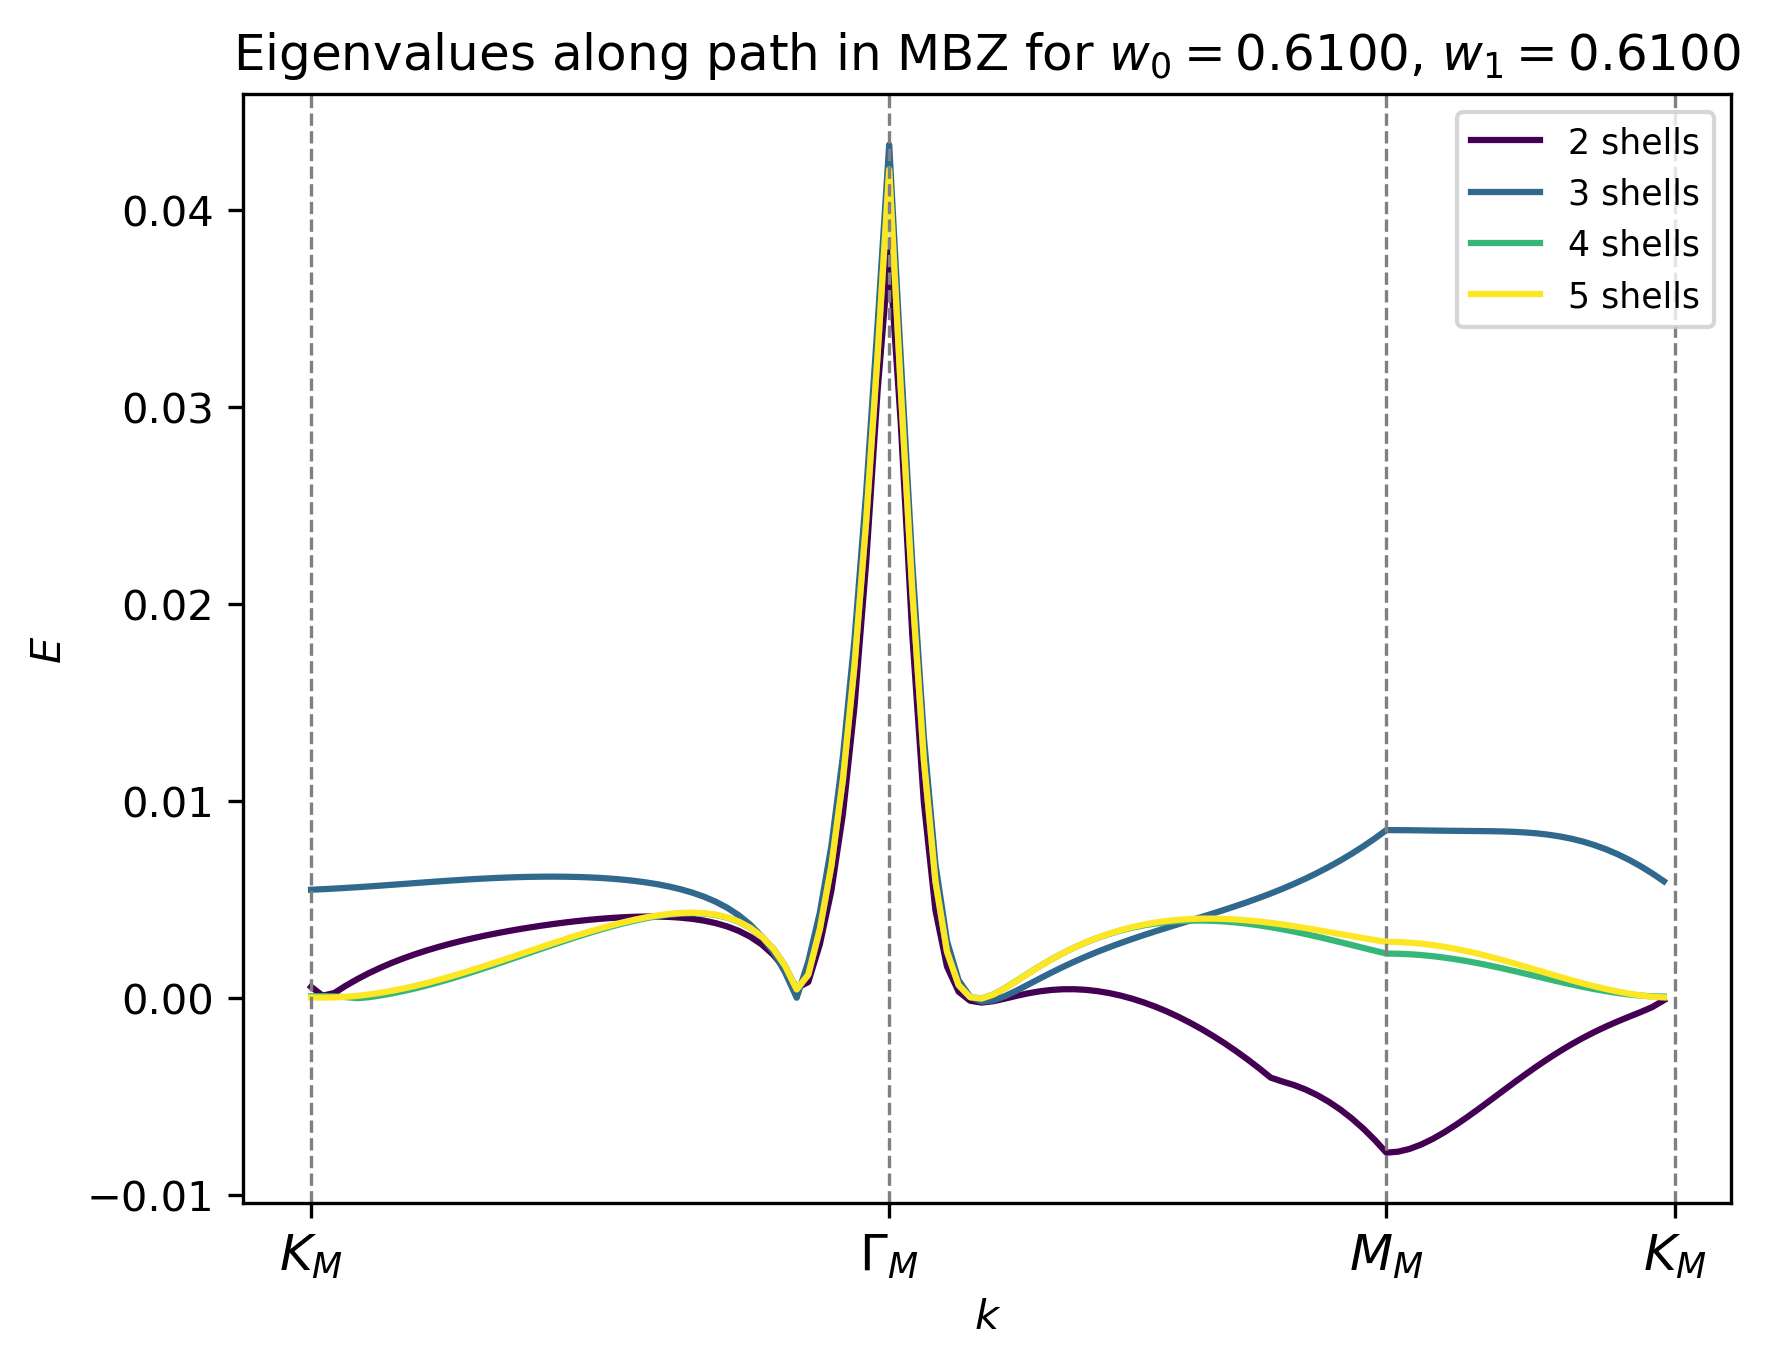

/var/folders/lm/7h466wts1h1c4ptw5tfpglvm0000gn/T/ipykernel_20299/2795705197.py:365: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.



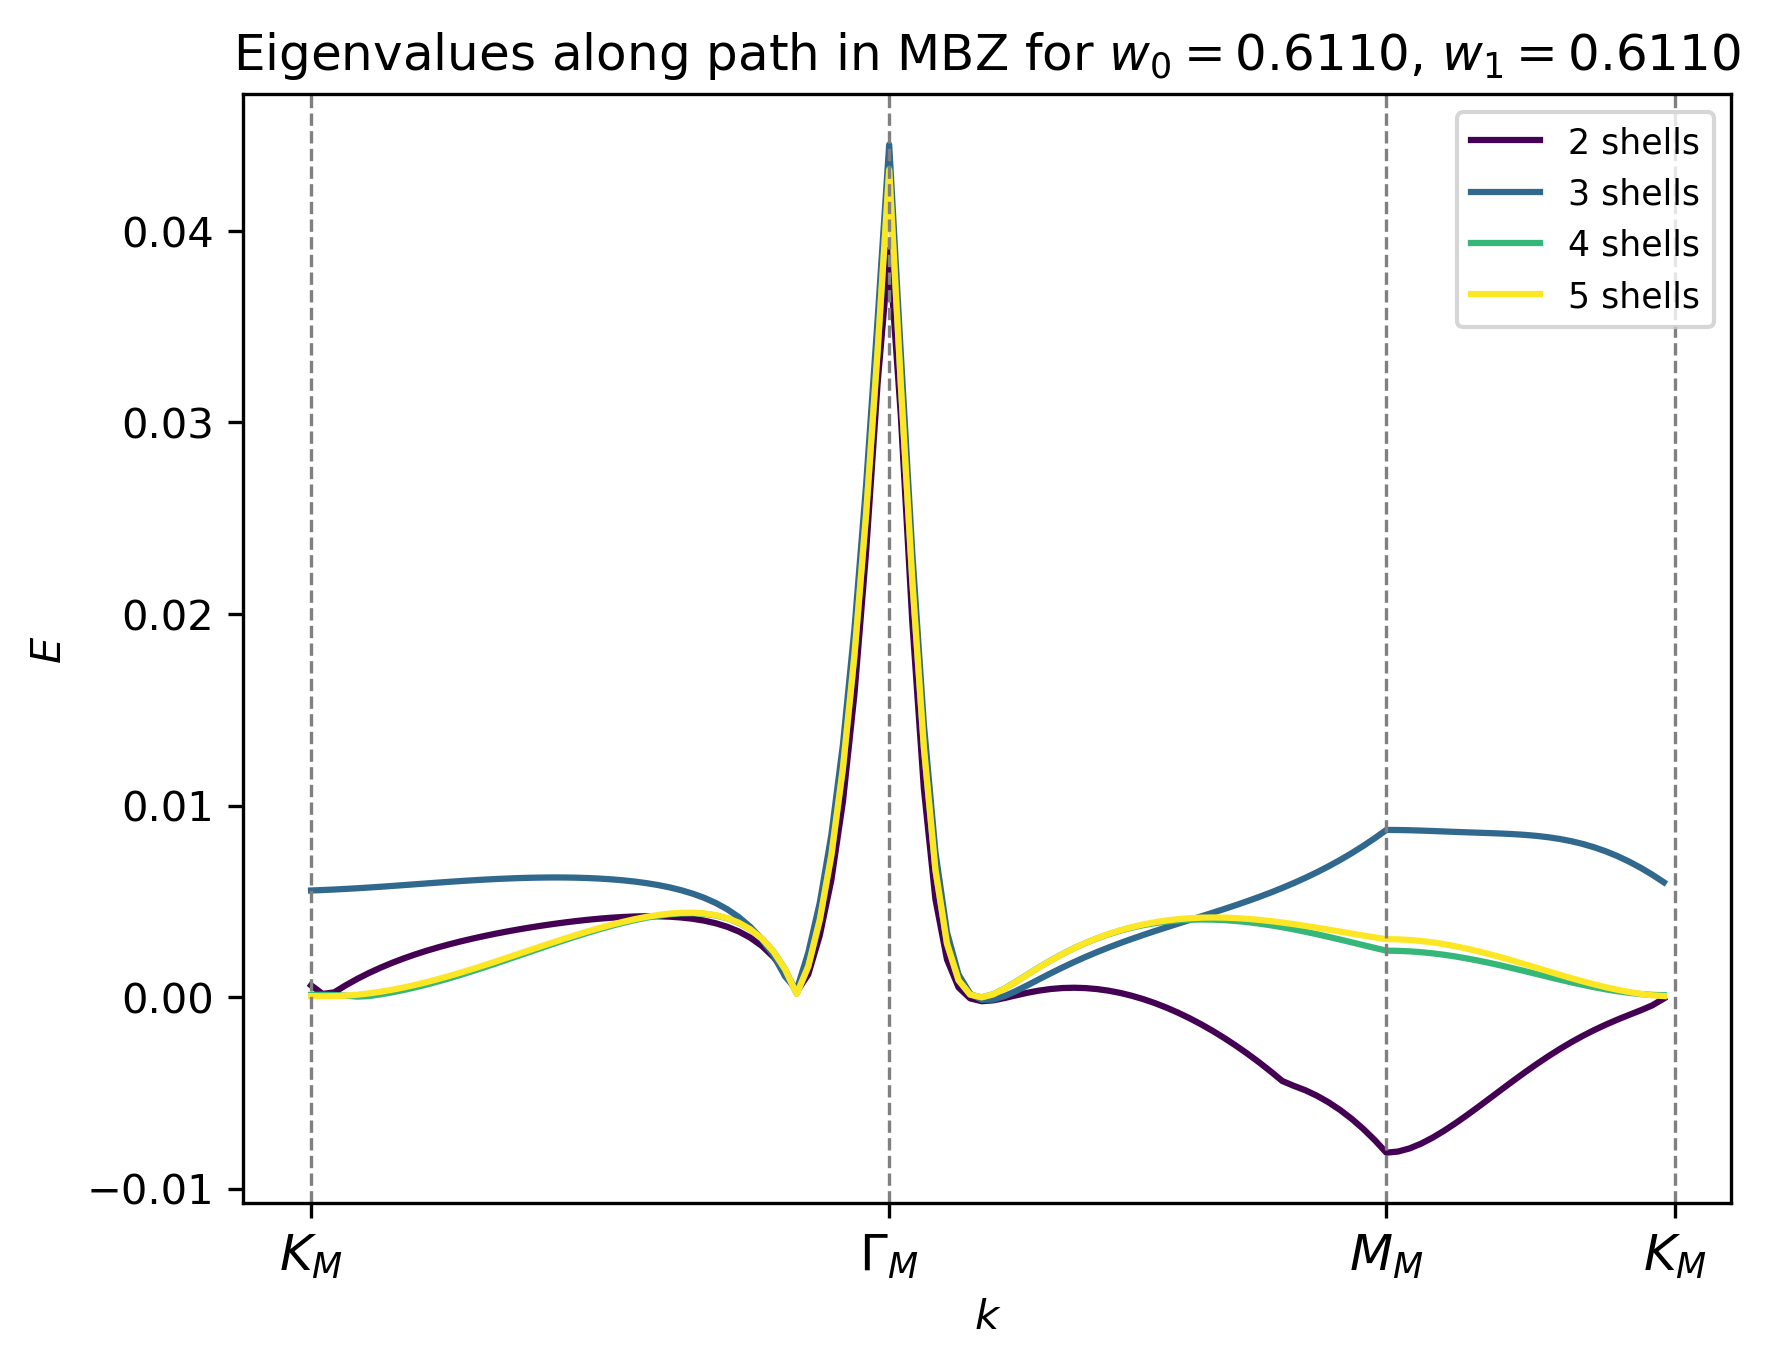

/var/folders/lm/7h466wts1h1c4ptw5tfpglvm0000gn/T/ipykernel_20299/2795705197.py:365: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.



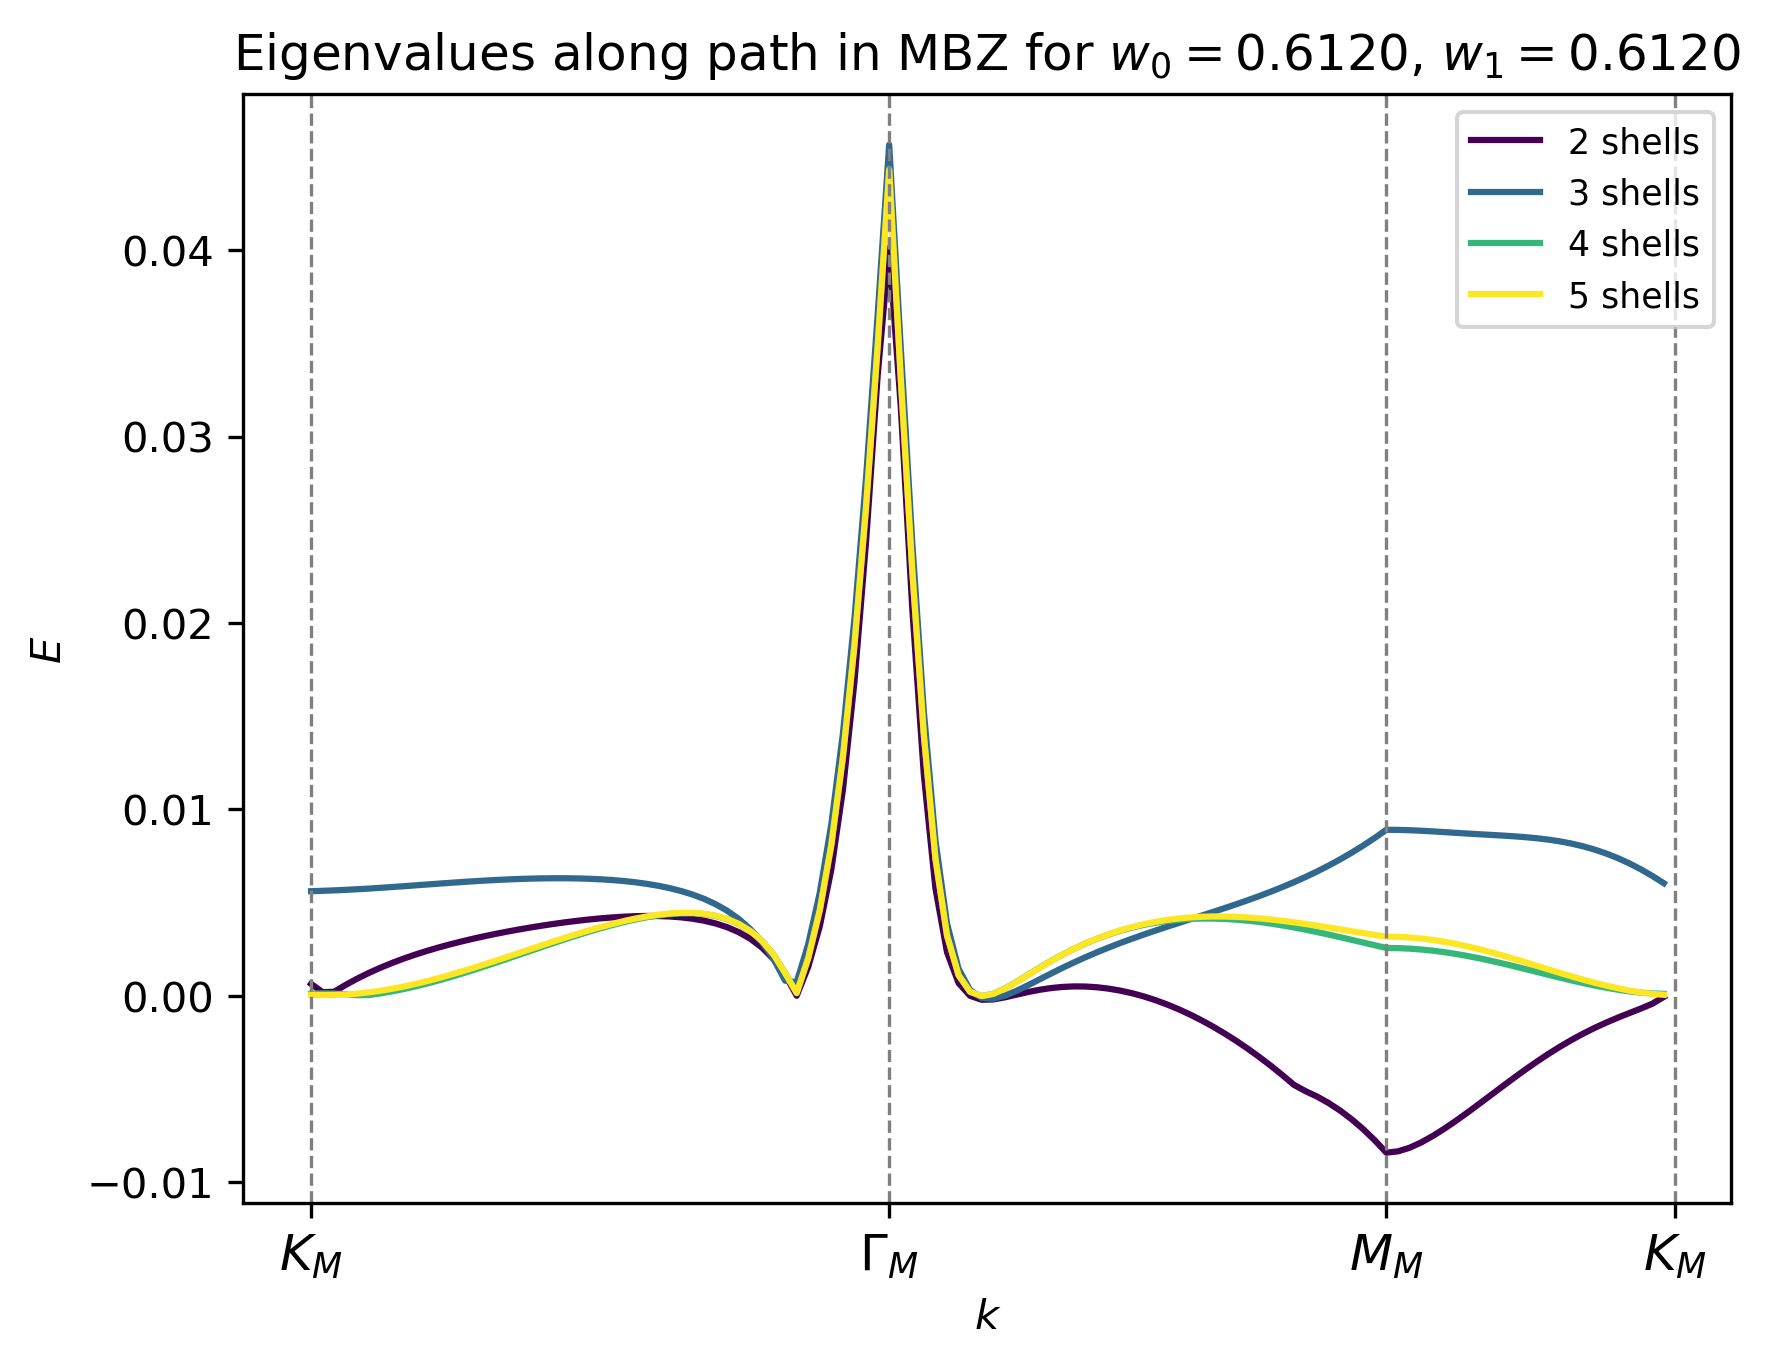

/var/folders/lm/7h466wts1h1c4ptw5tfpglvm0000gn/T/ipykernel_20299/2795705197.py:365: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.



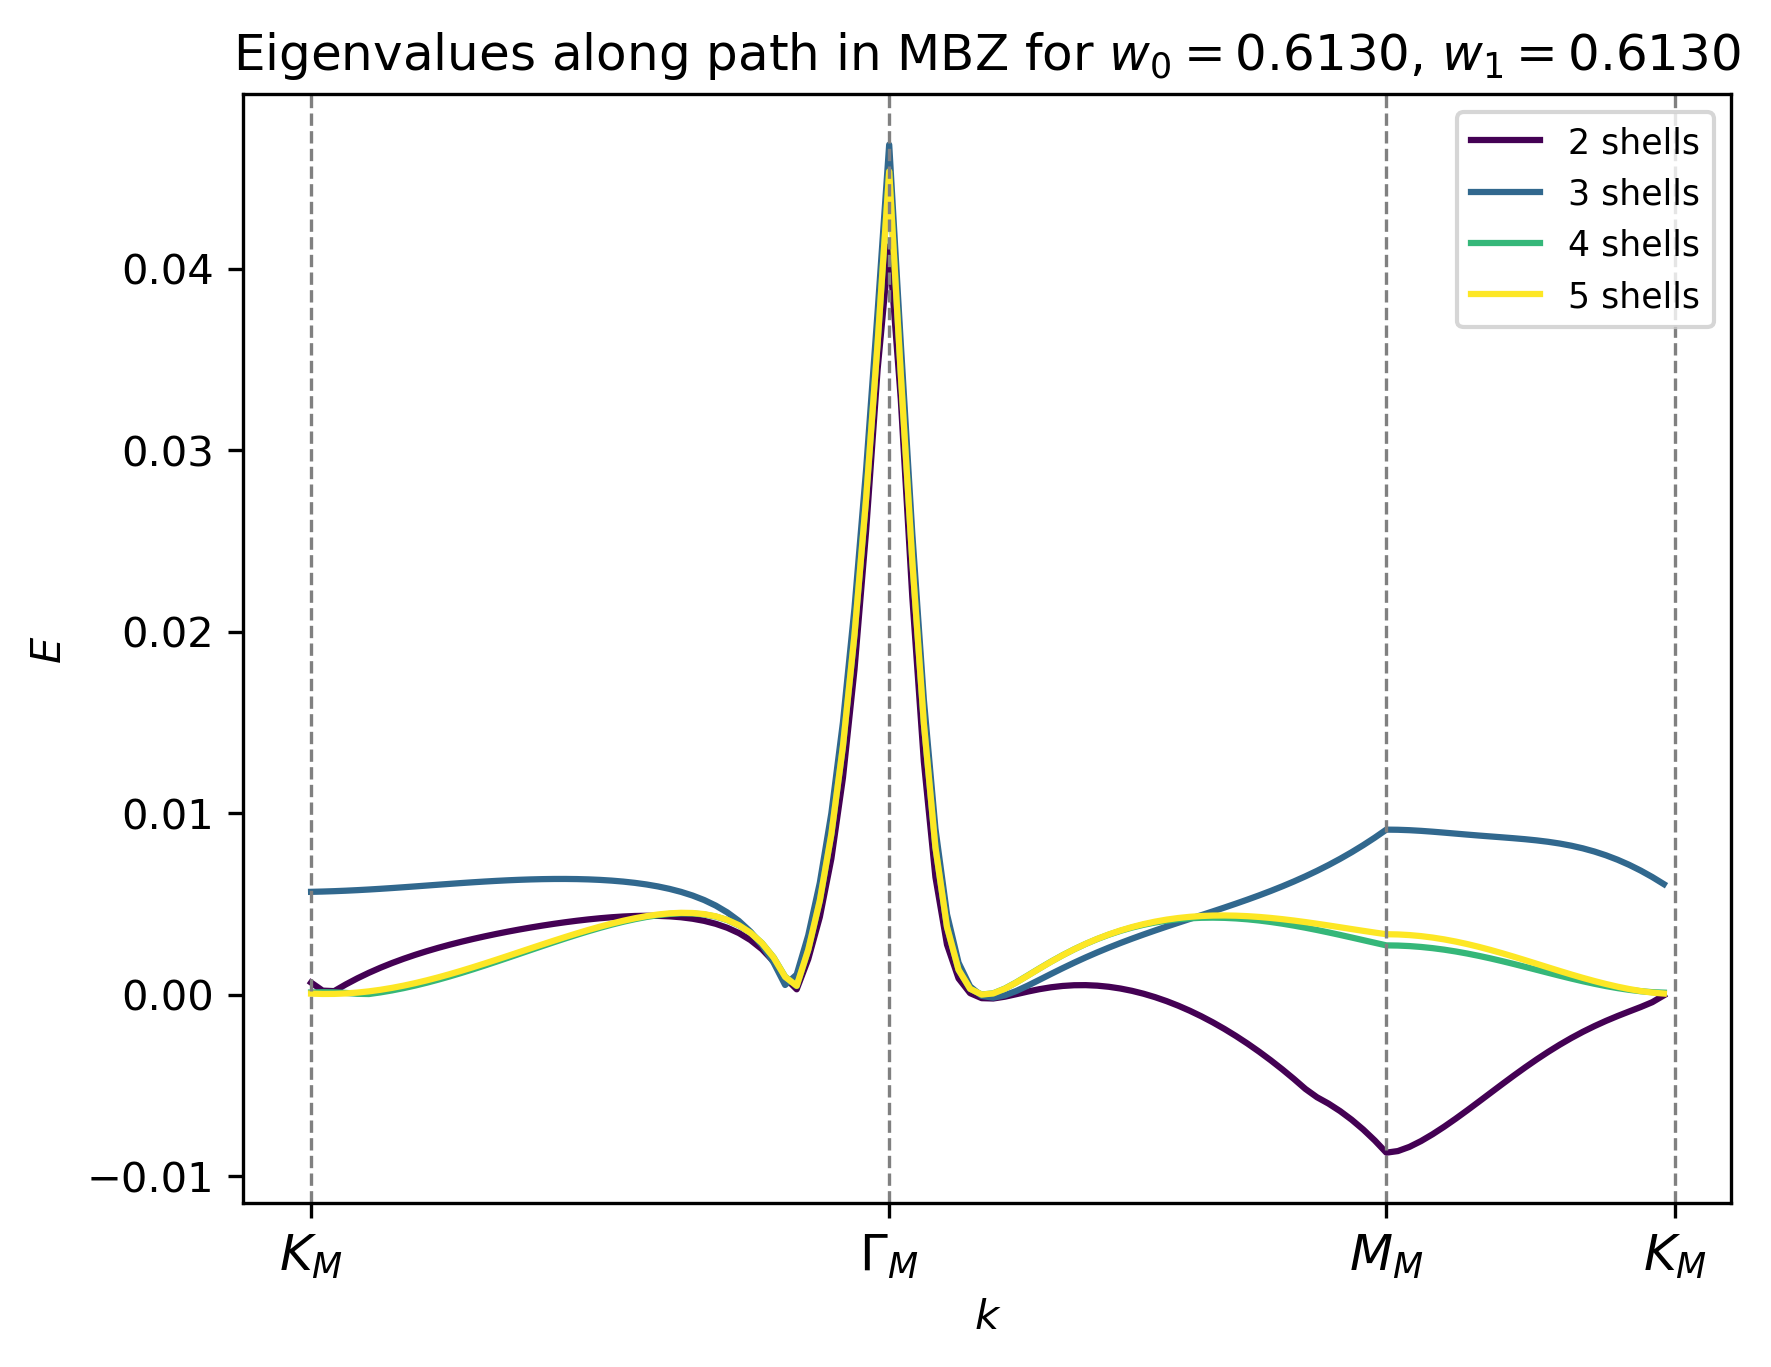

In [65]:
from matplotlib.cm import get_cmap

for w in [0.603  + 0.001*i for i in range(11)]:
    GM.plot_path_eigvals_colormap(50, w, w, [2, 3, 4, 5], Elimits=None, bands=(1, 0), colormap='viridis')

In [71]:
points = GM.gammaM_BZ(30, proportion=2)


all_eigvals = []
for p in tqdm(points):
    all_eigvals.append(np.linalg.eigvalsh(GM.get_gammaM_matrix(p, 0.606, 0.606, 5)))

middle_eigvals = [sorted(eigvals)[len(eigvals)//2] for eigvals in all_eigvals]

x = [p[0] for p in points] # + [p[0] for p in points]
y = [p[1] for p in points] # + [p[1] for p in points]
z = middle_eigvals # sixth_eigvals + seventh_eigvals # + second_lowest_eigvals


import plotly.graph_objects as go
# Create a 3D scatter plot
# fig = go.Figure(data=[go.Scatter3d(x=x, y=y, z=z, mode='markers', marker=dict(size=2, color=z, colorscale='Viridis'))])



# Extract coordinates for the vertical line at (x, y) = (0, 1)
line_x = [0, 0]  # x-coordinates of the vertical line
line_y = [1, 1]  # y-coordinates of the vertical line
line_z = [min(z), max(z)]  # z-coordinates span the range of z-values

# Create a 3D scatter plot


fig = go.Figure(data=[
    go.Scatter3d(
        x=x, y=y, z=z,
        mode='markers',
        marker=dict(size=4, color=z, colorscale='Viridis'),
    ),
    go.Scatter3d(
        x=line_x, y=line_y, z=line_z,
        mode='lines',
        line=dict(color='red', width=4),
        name='Vertical Line'
    )
])

# make the font size of the tickmarks and x y z labels 18
fig.update_layout(scene=dict(
                    xaxis_title='X',
                    yaxis_title='Y',
                    zaxis_title='Z'),
                    font=dict(
                        size=18,
                        color="RebeccaPurple"
                    ))


# Add titles and labels
fig.update_scenes(aspectratio = {'x': sqrt(3)/2, 'y': 1, 'z': 0.5}) # also works for me. Thank you! – 

fig.write_html("surface_plot_asdf.html")

# Show the plot
fig.show()

100%|██████████| 2791/2791 [00:07<00:00, 393.56it/s]


In [55]:

from tqdm import tqdm
def plot_bandwidth(N, w0, w1range, nshell):
    """
    Plots eigenvalues for multiple shells on the same plot, using a colormap for line colors.

    Parameters:
        N (int): Number of k-points along the path in the BZ.
        w0 (float): Parameter in the Hamiltonian.
        w1 (float): Parameter in the Hamiltonian.
        nshell_range (list or range): Range of shells to plot.
        Elimits (tuple): (Emin, Emax) tuple to set the y-axis limits.
        bands (tuple): (num_bands_above, num_bands_below) to specify bands to plot.
        colormap (str): Name of the matplotlib colormap to use.
    """
    fig, ax = plt.subplots(dpi=300)


    # path = GM.BZ_path(N)

    kpoints = GM.gammaM_BZ(N)

    bandwidths = []
    for w1 in tqdm(w1range):
        middle_eigvals = []
        for k in kpoints:
            eigvals = sorted(np.linalg.eigvalsh(GM.get_gammaM_matrix(k, w0, w1, nshell)))
            middle_eigvals.append(eigvals[len(eigvals)//2])
        bandwidths.append(max(middle_eigvals) - min(middle_eigvals))

    ax.scatter(w1range, bandwidths, color='blue')


100%|██████████| 100/100 [00:20<00:00,  4.87it/s]


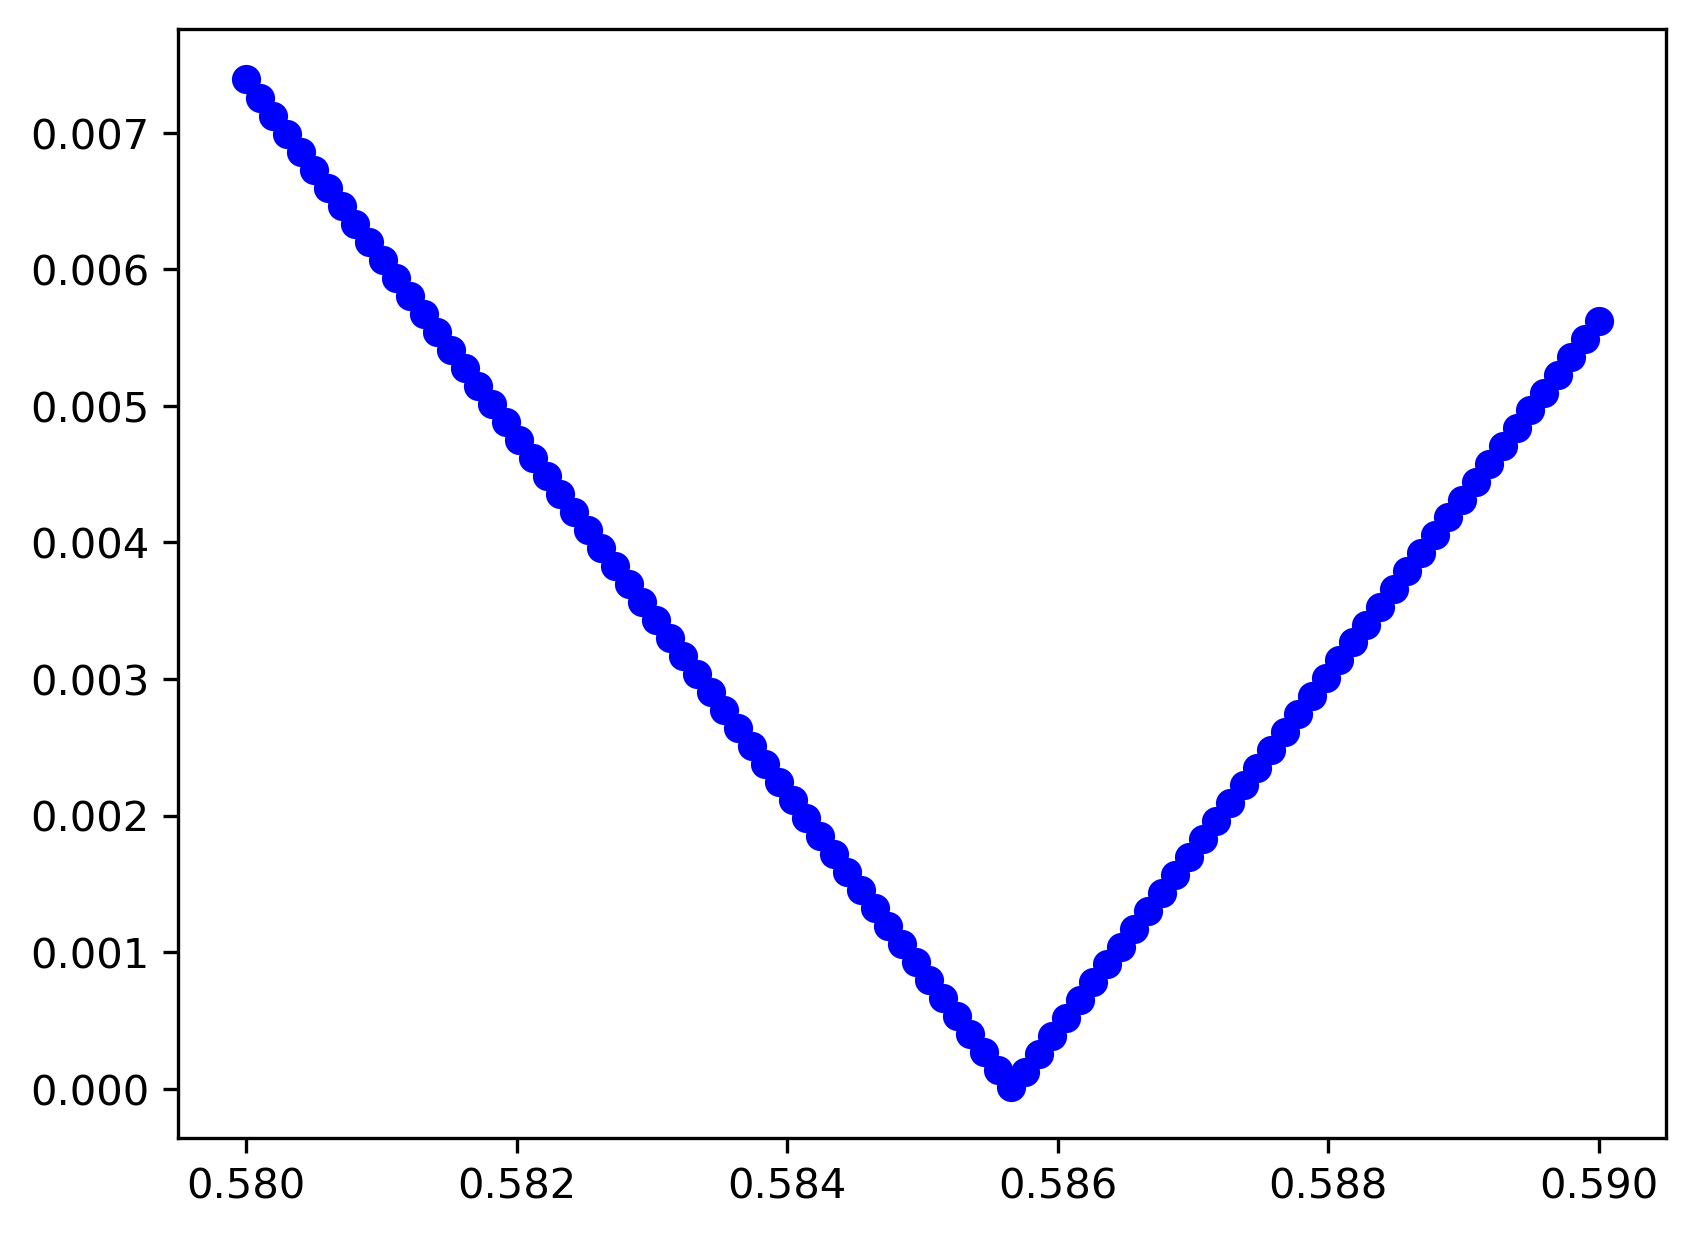

In [56]:
plot_bandwidth(3, 0, np.linspace(0.58, 0.59, 100), 6)

In [ ]:
0.606

In [60]:
points = GM.gammaM_BZ(18, proportion=1)


all_eigvals = []
for p in tqdm(points):
    all_eigvals.append(np.linalg.eigvalsh(GM.get_gammaM_matrix(p, 0.0, 0.58, 6)))

middle_eigvals = [sorted(eigvals)[len(eigvals)//2] for eigvals in all_eigvals]

x = [p[0] for p in points] # + [p[0] for p in points]
y = [p[1] for p in points] # + [p[1] for p in points]
z = middle_eigvals # sixth_eigvals + seventh_eigvals # + second_lowest_eigvals


import plotly.graph_objects as go
# Create a 3D scatter plot
fig = go.Figure(data=[go.Scatter3d(x=x, y=y, z=z, mode='markers', marker=dict(size=2, color=z, colorscale='Viridis'))])


# Add titles and labels
fig.update_scenes(aspectratio = {'x': sqrt(3)/2, 'y': 1, 'z': 0.5}) # also works for me. Thank you! – 


fig.write_html("surface_plot_asdf.html")

# Show the plot
fig.show()

100%|██████████| 1027/1027 [00:08<00:00, 122.66it/s]


In [63]:
points = GM.gammaM_BZ(18, proportion=1)


all_eigvals = []
for p in tqdm(points):
    all_eigvals.append(np.linalg.eigvalsh(GM.get_gammaM_matrix(p, 0.0, 0.5857, 6)))

middle_eigvals = [sorted(eigvals)[len(eigvals)//2] for eigvals in all_eigvals]

x = [p[0] for p in points] # + [p[0] for p in points]
y = [p[1] for p in points] # + [p[1] for p in points]
z = middle_eigvals # sixth_eigvals + seventh_eigvals # + second_lowest_eigvals


import plotly.graph_objects as go
# Create a 3D scatter plot
fig = go.Figure(data=[go.Scatter3d(x=x, y=y, z=z, mode='markers', marker=dict(size=4, color=z, colorscale='Viridis'))])

# make the font larger
fig.update_layout(font=dict(size=18))

# Add titles and labels
fig.update_scenes(aspectratio = {'x': sqrt(3)/2, 'y': 1, 'z': 0.5}) # also works for me. Thank you! – 


fig.write_html("surface_plot_5857.html")

# Show the plot
fig.show()

100%|██████████| 1027/1027 [00:06<00:00, 163.92it/s]


In [ ]:
GM.plot_path_eigvals(100, 0, 0.586, 1, Elimits=(-0.1, 0.1), bands=(1, 0))
GM.plot_path_eigvals(100, 0, 0.586, 2, Elimits=(-0.1, 0.1), bands=(1, 0))
GM.plot_path_eigvals(100, 0, 0.586, 3, Elimits=(-0.1, 0.1), bands=(1, 0))
GM.plot_path_eigvals(100, 0, 0.586, 4, Elimits=(-0.1, 0.1), bands=(1, 0))
GM.plot_path_eigvals(100, 0, 0.586, 5, Elimits=(-0.1, 0.1), bands=(1, 0))
GM.plot_path_eigvals(100, 0, 0.586, 6, Elimits=(-0.1, 0.1), bands=(1, 0))

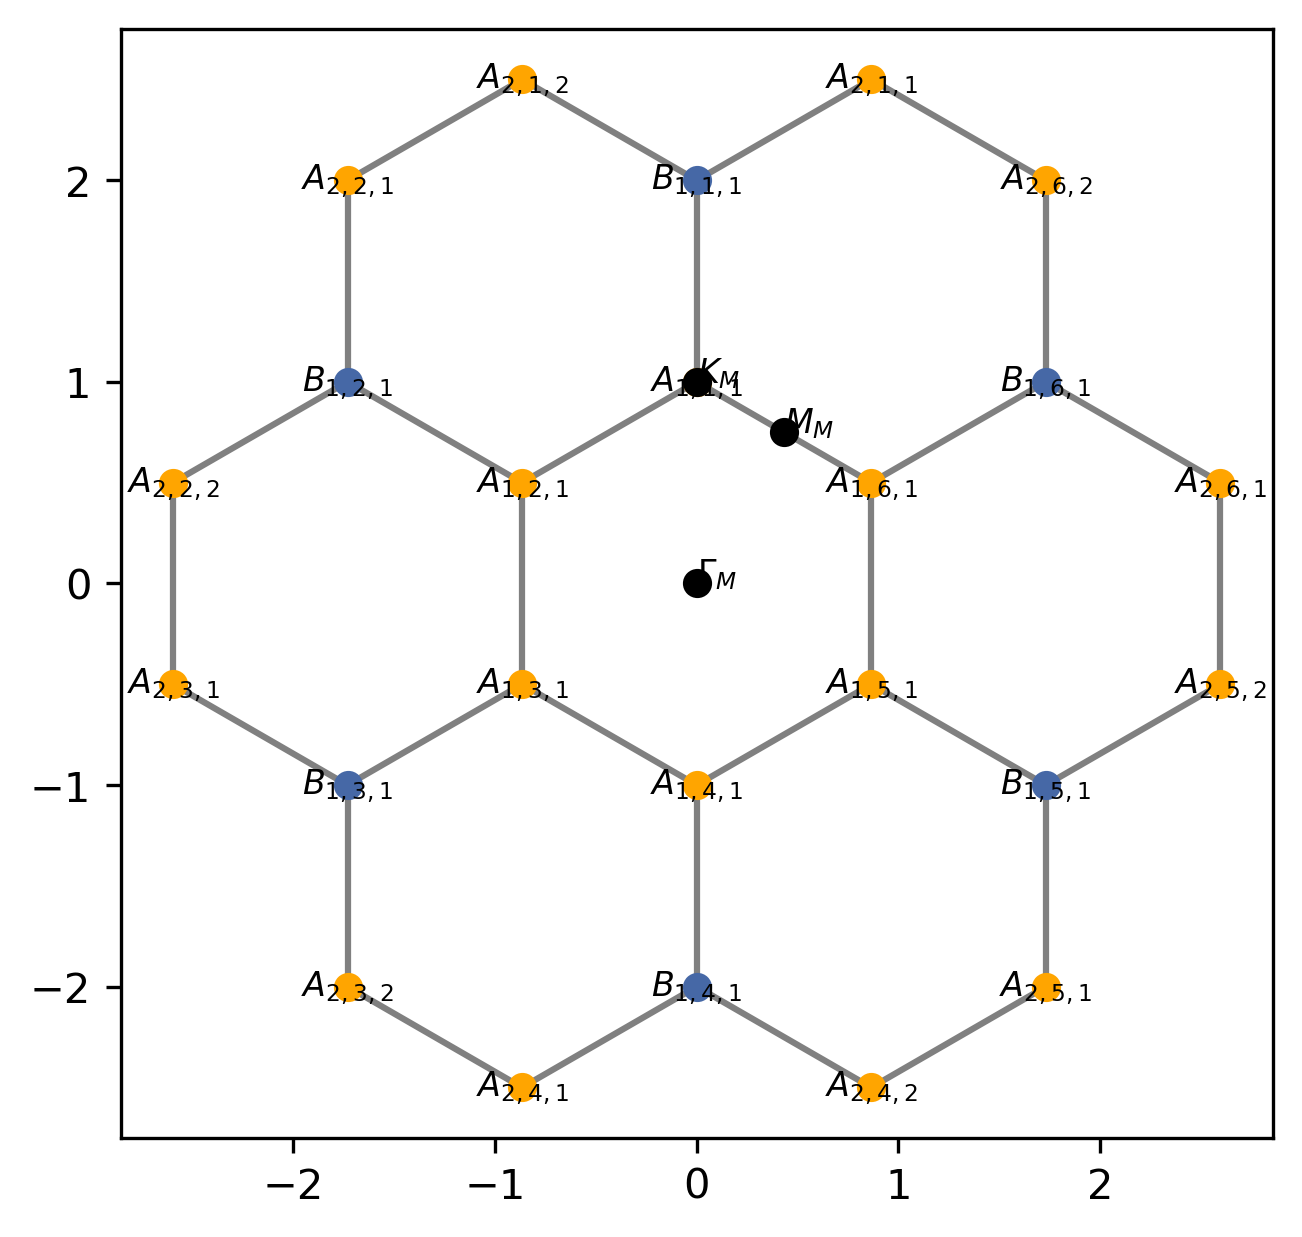

In [18]:
GM.create_site_plot(3, fontsize=8)

In [15]:
from tqdm import tqdm
def test_convergence():
    BZ = GM.gammaM_BZ(3)
    nshell_list = [1, 2, 3, 4, 5, 6, 7]
    w0 = 1/sqrt(3)
    w1 = 1/sqrt(3)

    nshell_groundtruth = 15
    groundtruth_middle_energies = []
    print("Calculating groundtruth")
    for k in tqdm(BZ):
        H = GM.get_gammaM_matrix(k, w0, w1, nshell_groundtruth)
        energies = sorted(np.linalg.eigvalsh(H))
        groundtruth_middle_energies.append(energies[len(energies)//2])

    max_errors = []
    for nshell in nshell_list:
        middle_energies = []
        print(f"nshell = {nshell}")
        for k in tqdm(BZ):
            H = GM.get_gammaM_matrix(k, w0, w1, nshell)
            energies = sorted(np.linalg.eigvalsh(H))
            middle_energies.append(energies[len(energies)//2])
        max_error = max(abs(np.array(groundtruth_middle_energies) - np.array(middle_energies)))
        max_errors.append(max_error)
    
    # Plot log(error) vs nshell
    plt.figure(dpi=300)
    plt.scatter(nshell_list, np.log(max_errors))
    plt.xlabel("Number of shells", fontsize=14)
    plt.ylabel("log(Max error)", fontsize=14)

Calculating groundtruth


100%|██████████| 37/37 [00:38<00:00,  1.05s/it]


nshell = 1


100%|██████████| 37/37 [00:00<00:00, 7926.31it/s]


nshell = 2


100%|██████████| 37/37 [00:00<00:00, 930.82it/s]


nshell = 3


100%|██████████| 37/37 [00:00<00:00, 1058.86it/s]


nshell = 4


100%|██████████| 37/37 [00:00<00:00, 356.84it/s]


nshell = 5


100%|██████████| 37/37 [00:00<00:00, 293.00it/s]


nshell = 6


100%|██████████| 37/37 [00:00<00:00, 150.37it/s]


nshell = 7


100%|██████████| 37/37 [00:01<00:00, 23.13it/s]


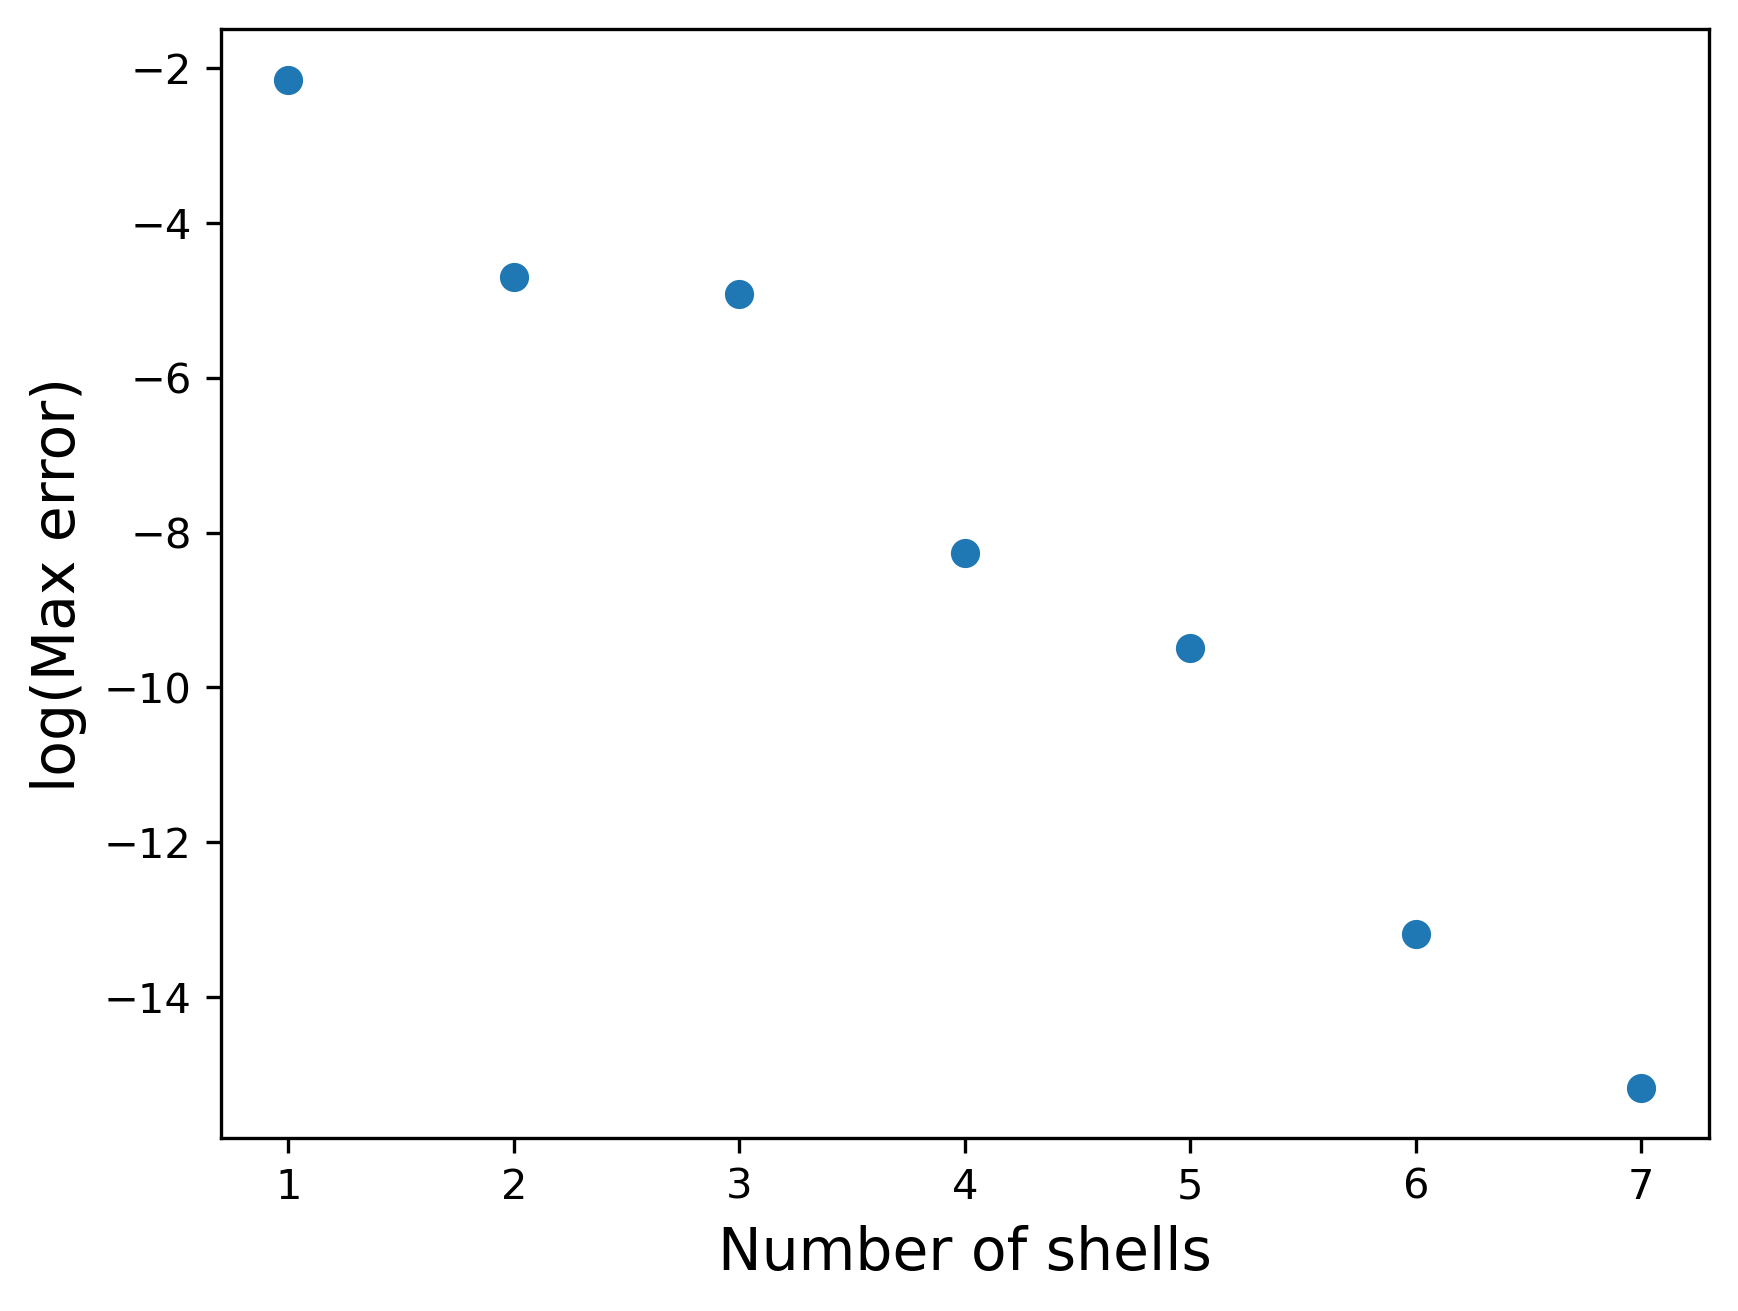

In [16]:
test_convergence()

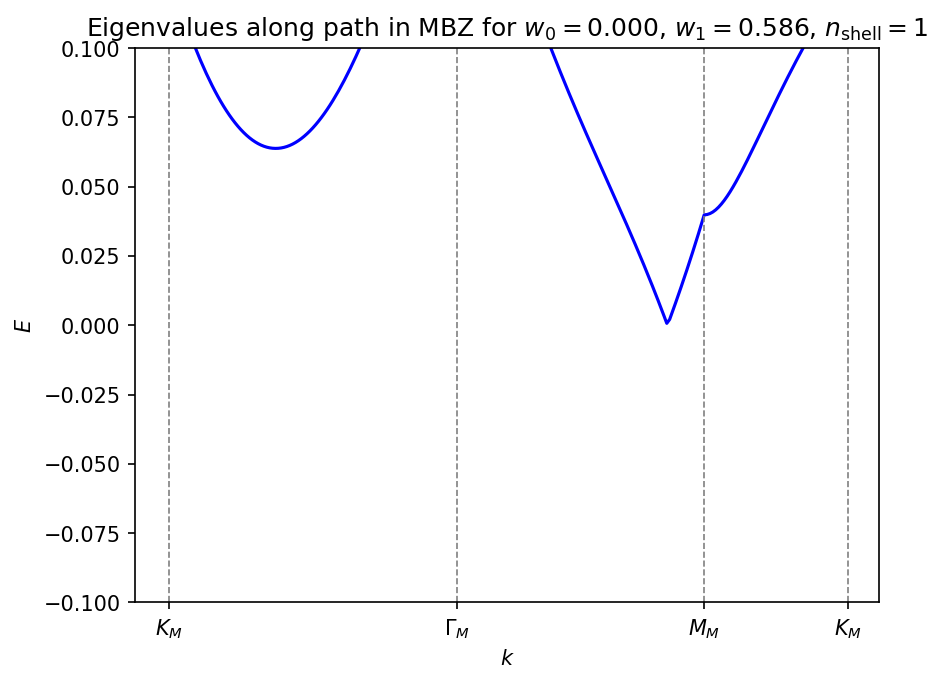

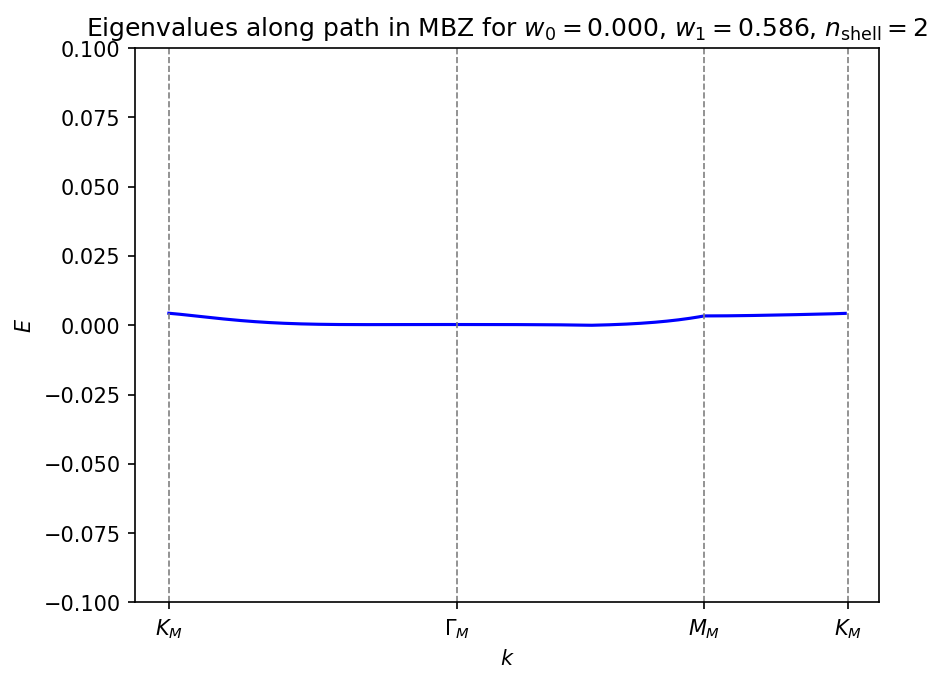

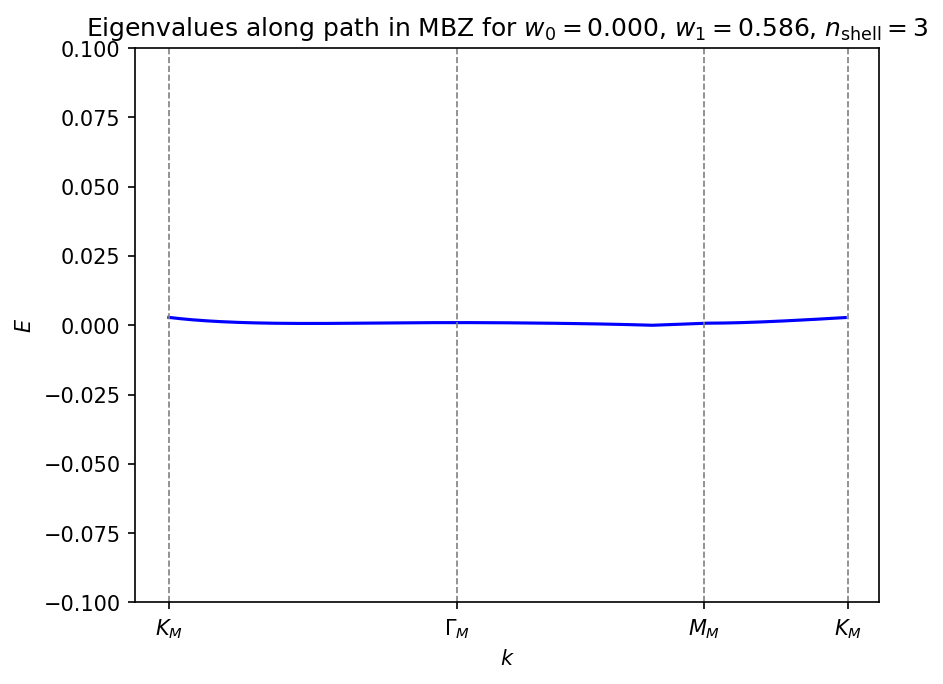

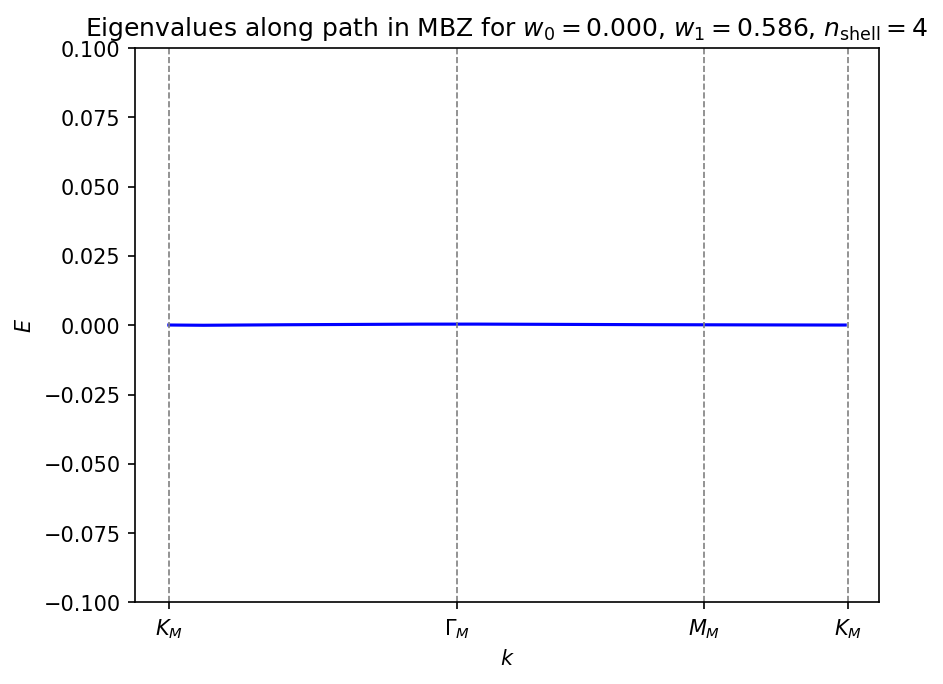

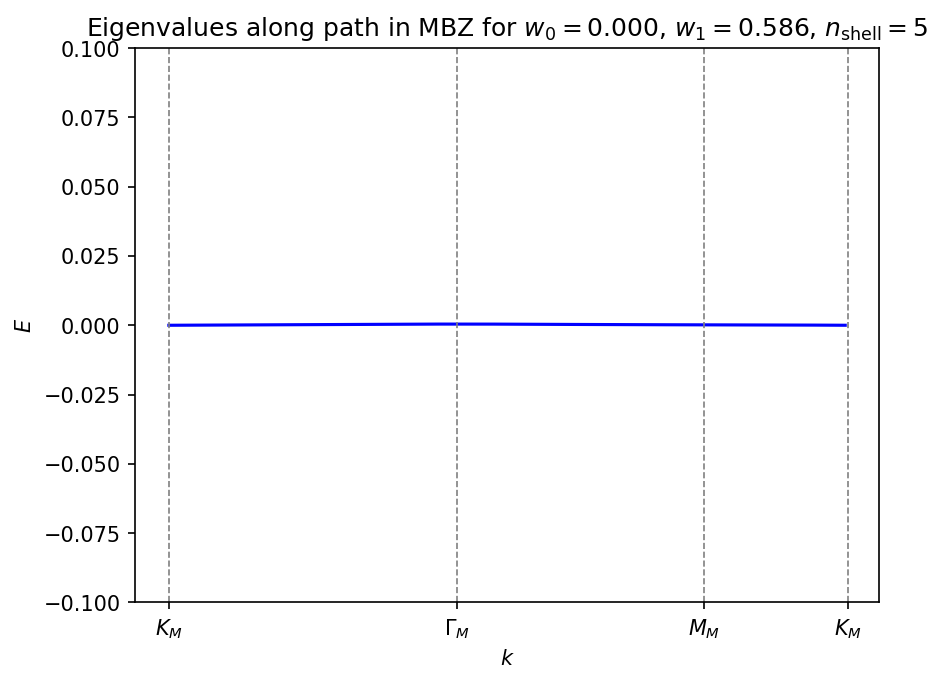

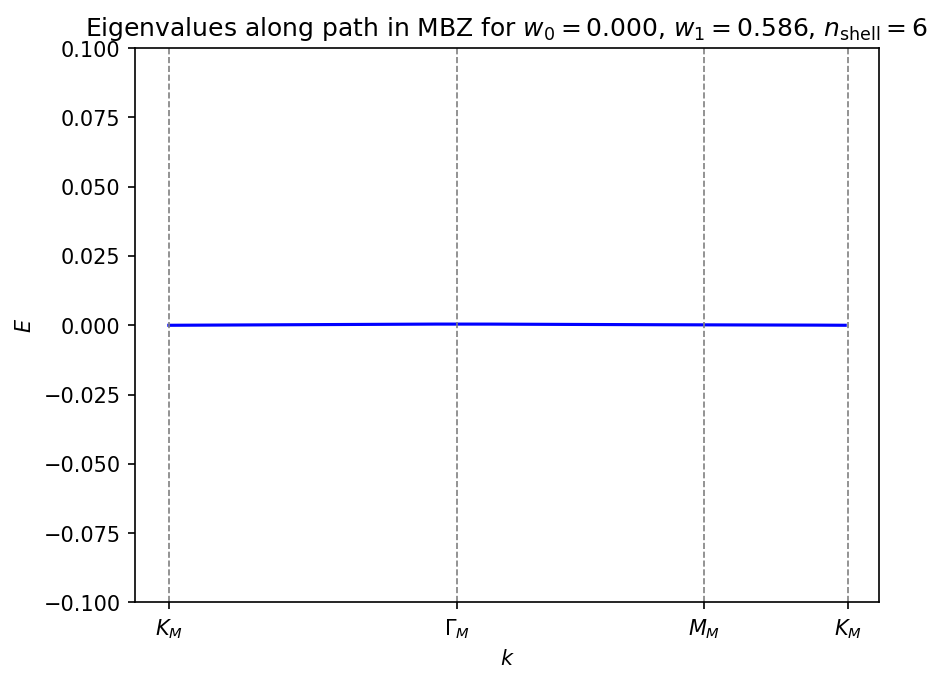

In [69]:
GM.plot_path_eigvals(100, 0, 0.586, 1, Elimits=(-0.1, 0.1), bands=(1, 0))
GM.plot_path_eigvals(100, 0, 0.586, 2, Elimits=(-0.1, 0.1), bands=(1, 0))
GM.plot_path_eigvals(100, 0, 0.586, 3, Elimits=(-0.1, 0.1), bands=(1, 0))
GM.plot_path_eigvals(100, 0, 0.586, 4, Elimits=(-0.1, 0.1), bands=(1, 0))
GM.plot_path_eigvals(100, 0, 0.586, 5, Elimits=(-0.1, 0.1), bands=(1, 0))
GM.plot_path_eigvals(100, 0, 0.586, 6, Elimits=(-0.1, 0.1), bands=(1, 0))

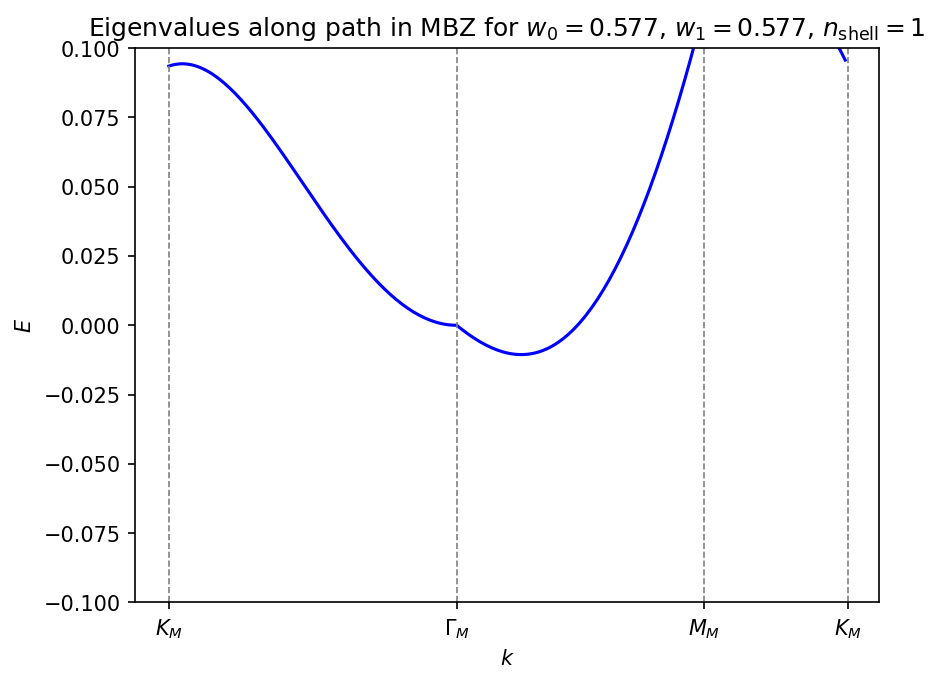

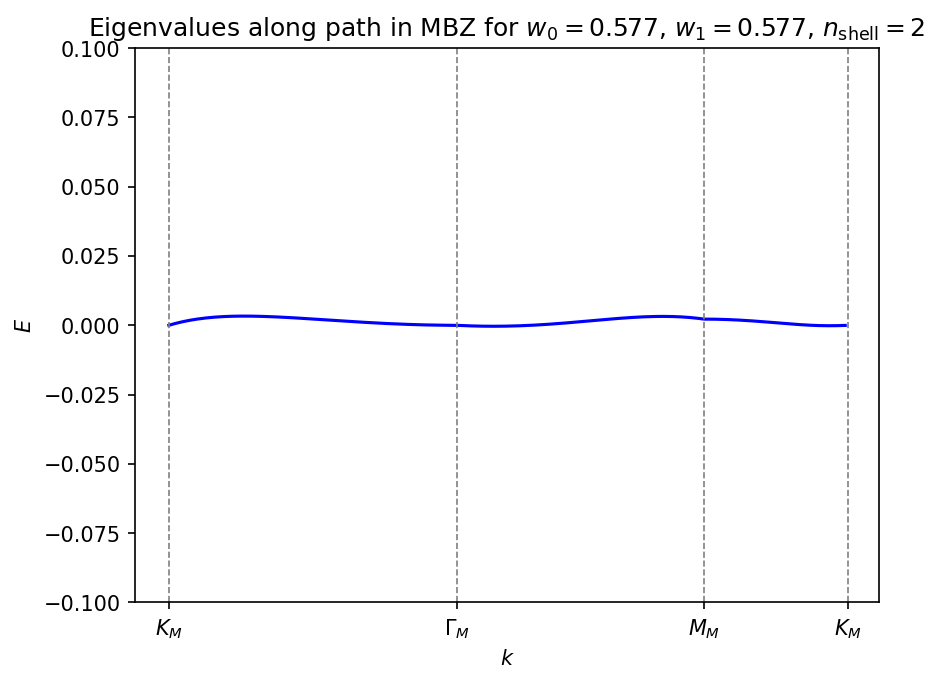

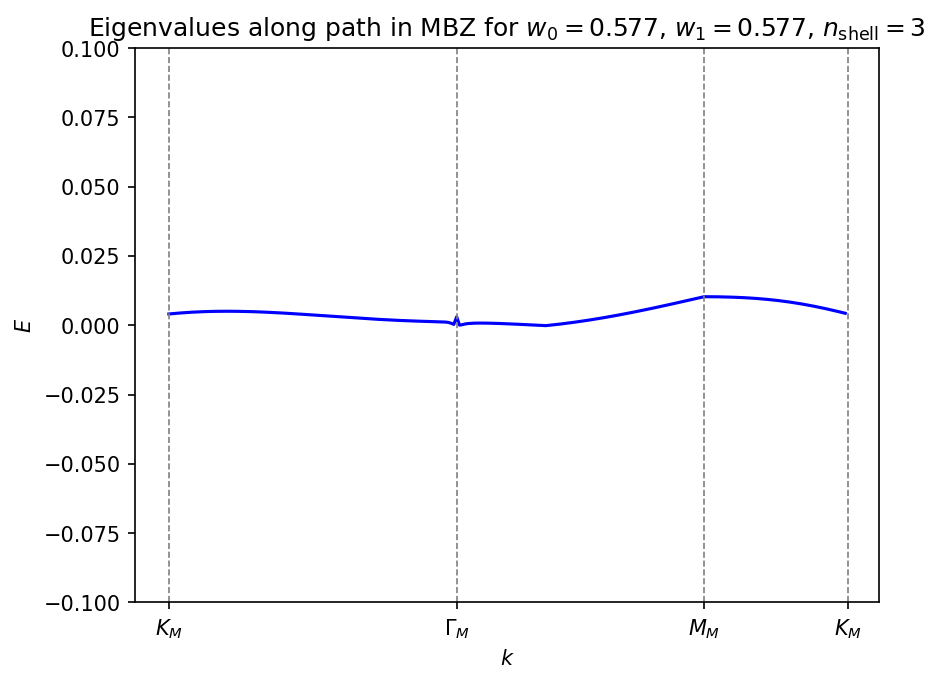

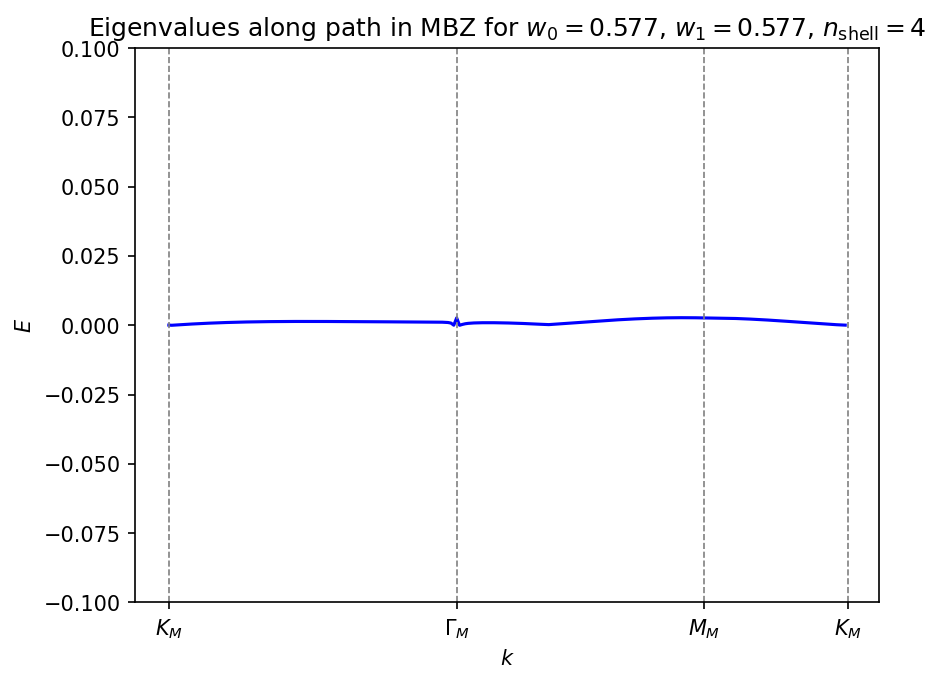

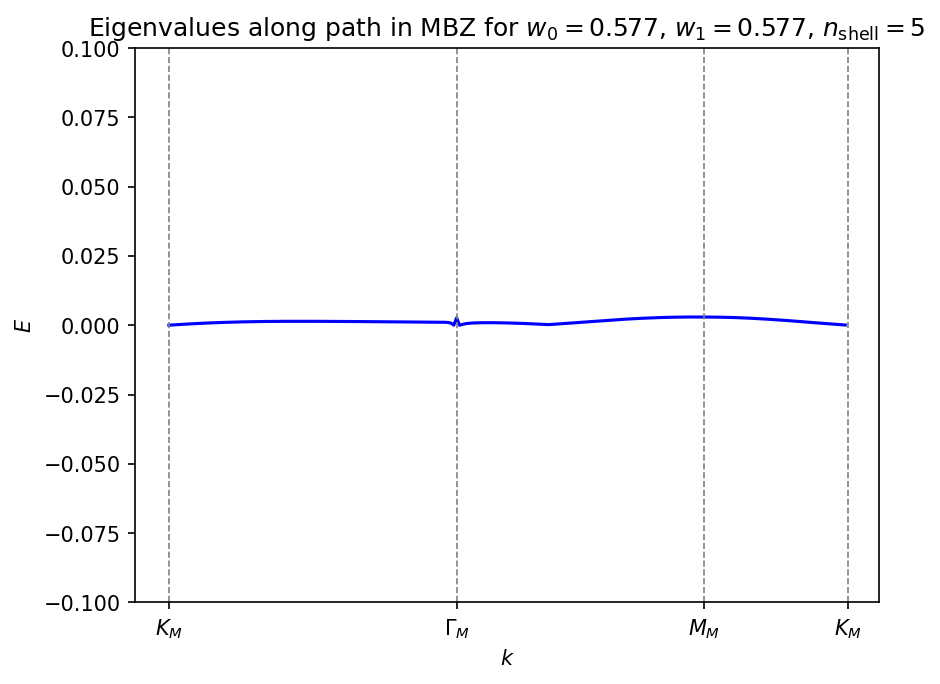

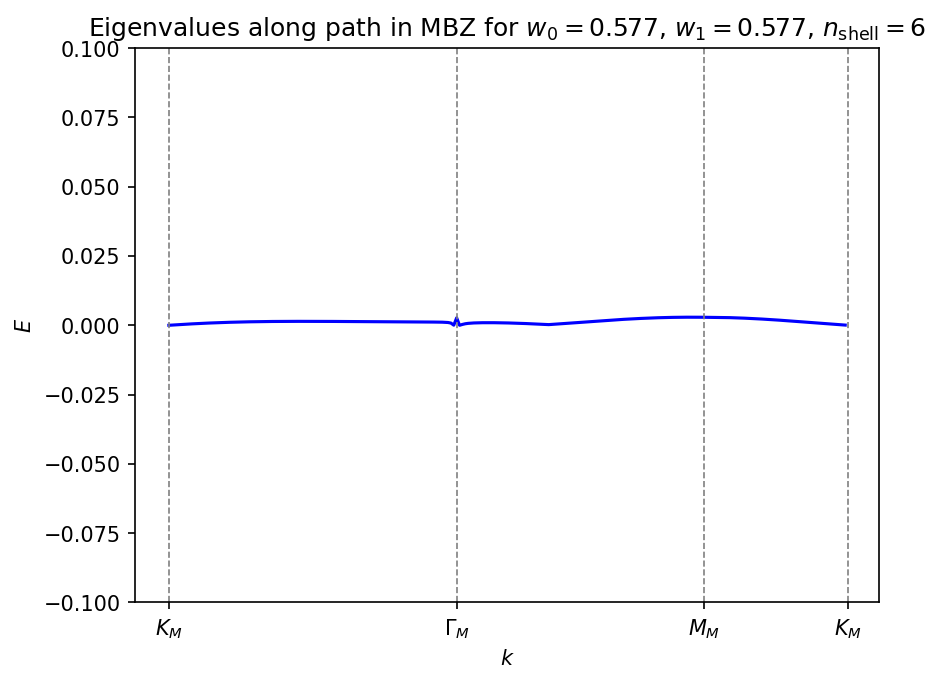

In [68]:
GM.plot_path_eigvals(100, 1/sqrt(3), 1/sqrt(3), 1, Elimits=(-0.1, 0.1), bands=(1, 0))
GM.plot_path_eigvals(100, 1/sqrt(3), 1/sqrt(3), 2, Elimits=(-0.1, 0.1), bands=(1, 0))
GM.plot_path_eigvals(100, 1/sqrt(3), 1/sqrt(3), 3, Elimits=(-0.1, 0.1), bands=(1, 0))
GM.plot_path_eigvals(100, 1/sqrt(3), 1/sqrt(3), 4, Elimits=(-0.1, 0.1), bands=(1, 0))
GM.plot_path_eigvals(100, 1/sqrt(3), 1/sqrt(3), 5, Elimits=(-0.1, 0.1), bands=(1, 0))
GM.plot_path_eigvals(100, 1/sqrt(3), 1/sqrt(3), 6, Elimits=(-0.1, 0.1), bands=(1, 0))

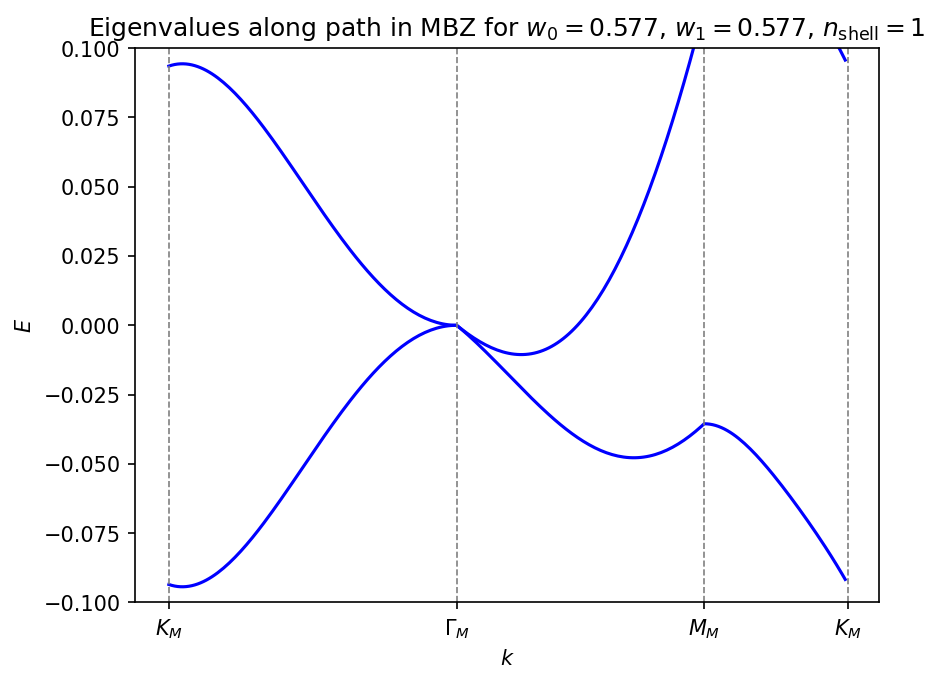

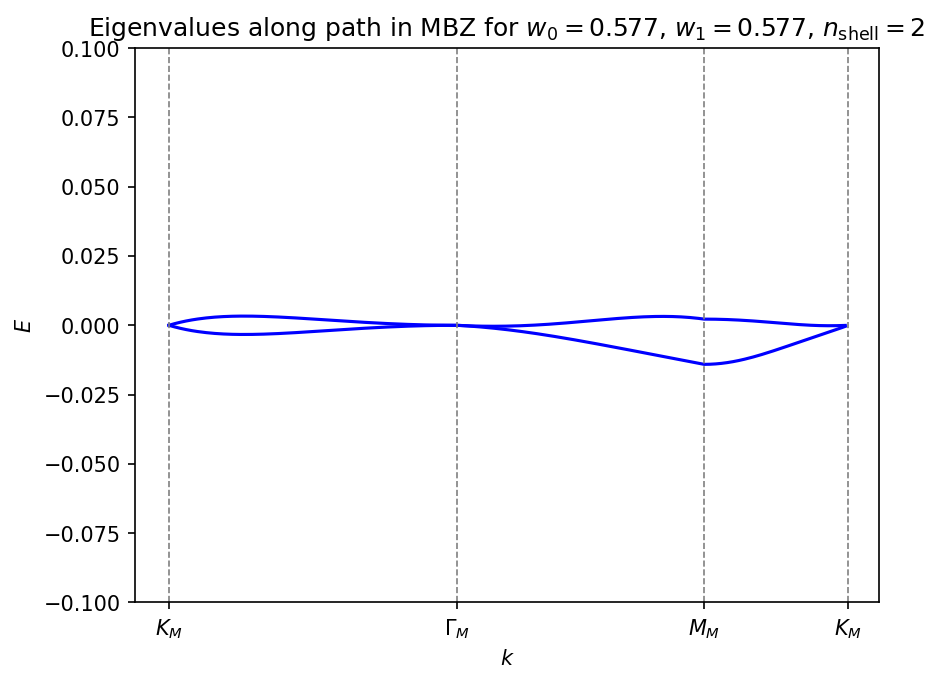

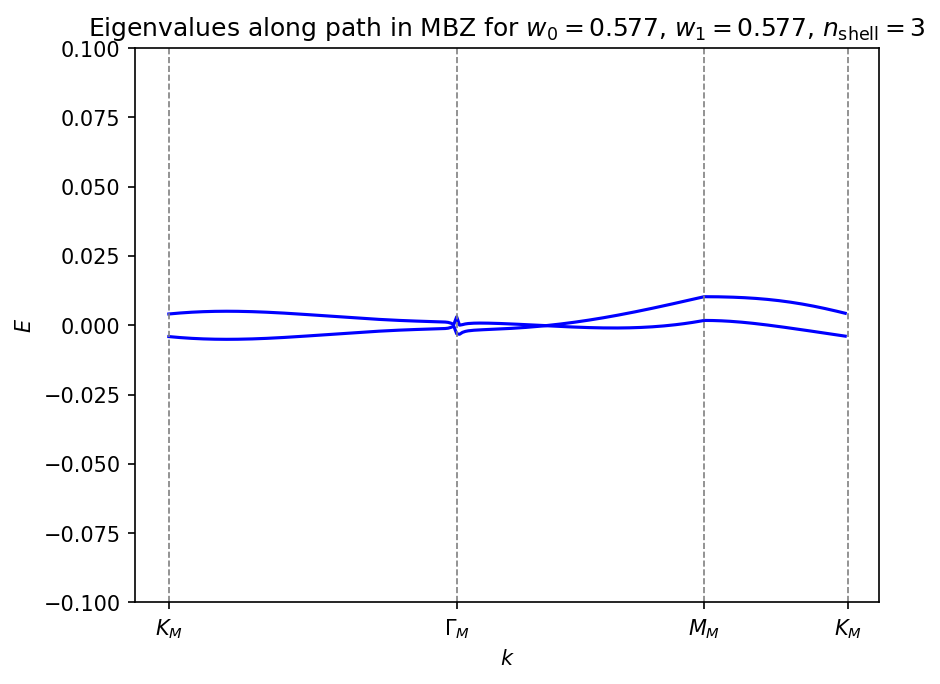

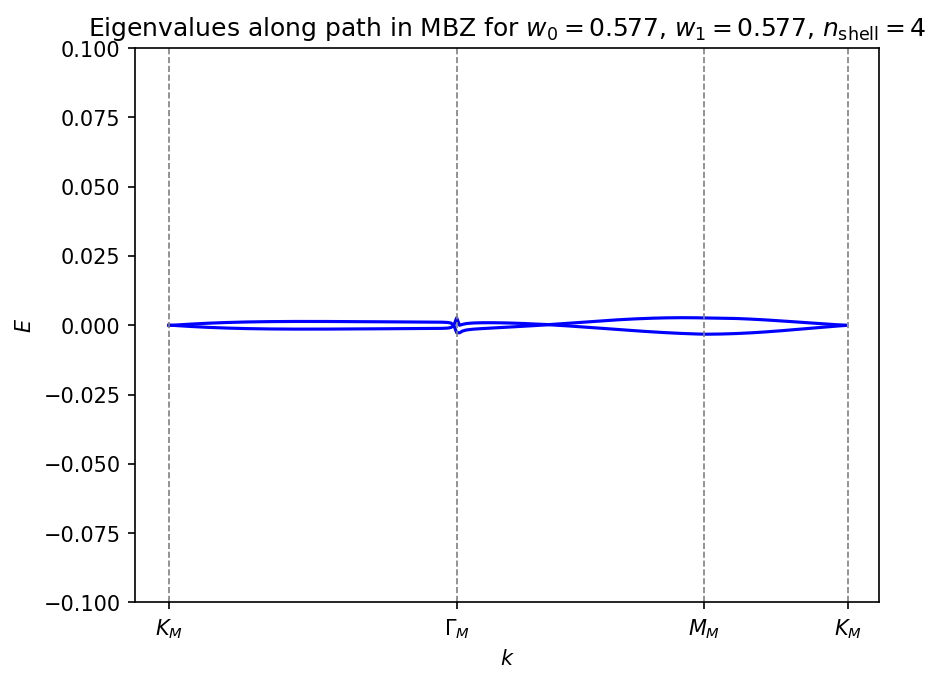

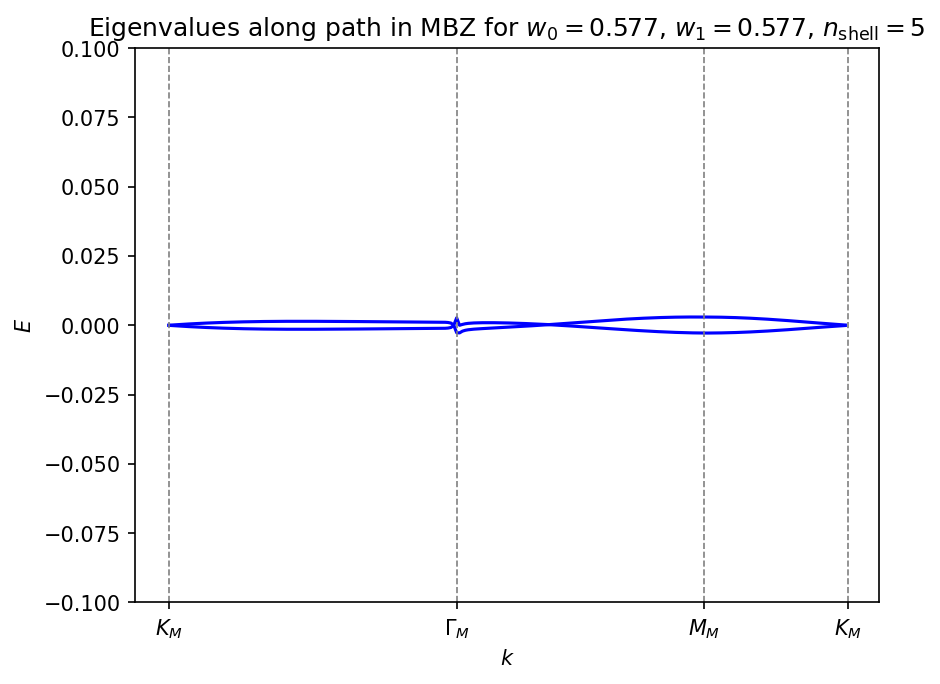

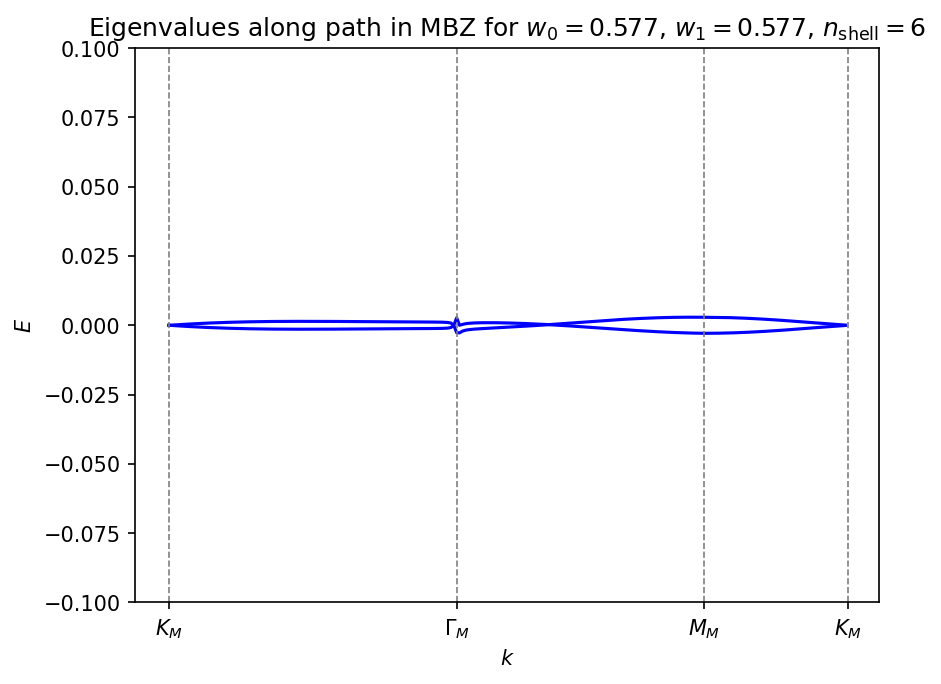

In [64]:
GM.plot_path_eigvals(100, 1/sqrt(3), 1/sqrt(3), 1, Elimits=(-0.1, 0.1), bands=(1, 1))
GM.plot_path_eigvals(100, 1/sqrt(3), 1/sqrt(3), 2, Elimits=(-0.1, 0.1), bands=(1, 1))
GM.plot_path_eigvals(100, 1/sqrt(3), 1/sqrt(3), 3, Elimits=(-0.1, 0.1), bands=(1, 1))
GM.plot_path_eigvals(100, 1/sqrt(3), 1/sqrt(3), 4, Elimits=(-0.1, 0.1), bands=(1, 1))
GM.plot_path_eigvals(100, 1/sqrt(3), 1/sqrt(3), 5, Elimits=(-0.1, 0.1), bands=(1, 1))
GM.plot_path_eigvals(100, 1/sqrt(3), 1/sqrt(3), 6, Elimits=(-0.1, 0.1), bands=(1, 1))

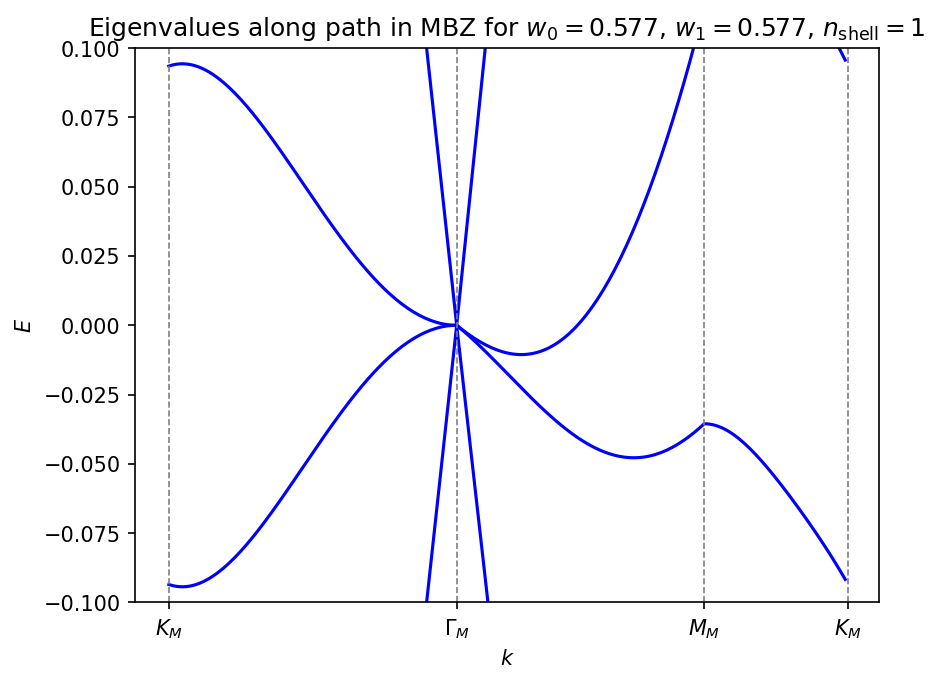

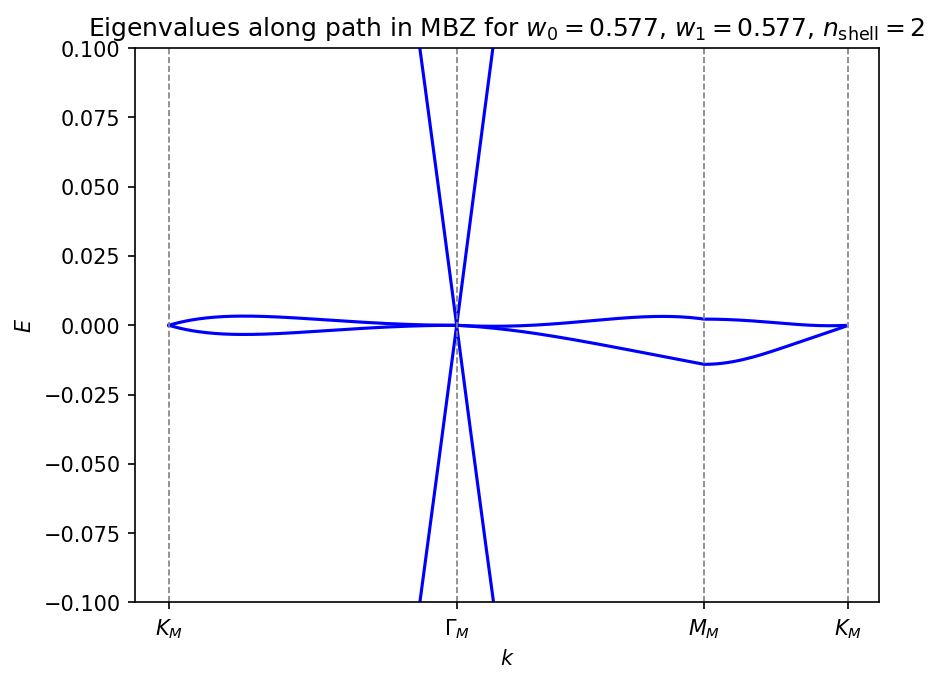

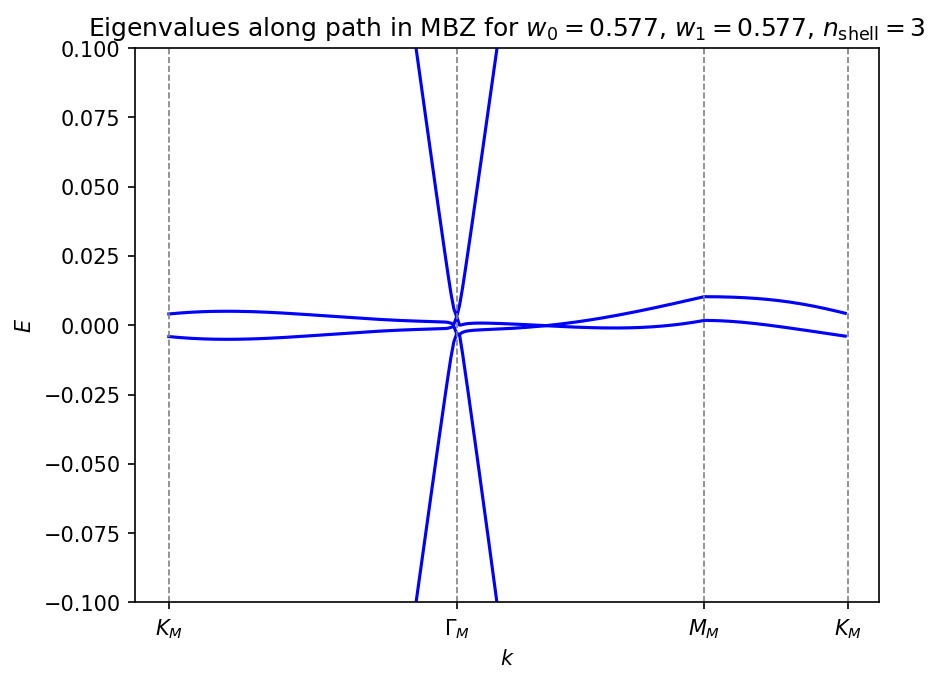

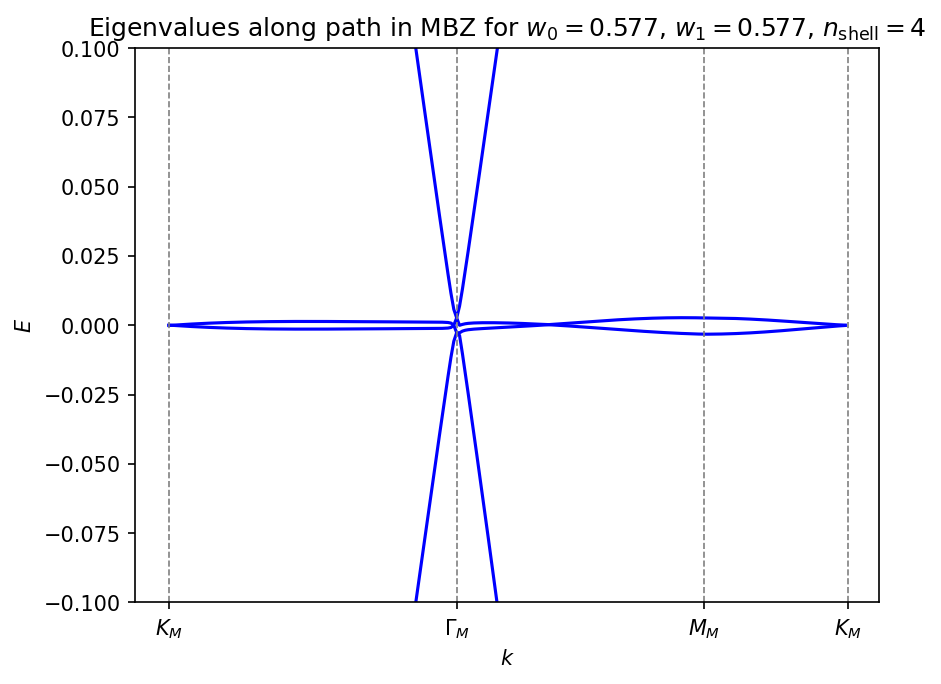

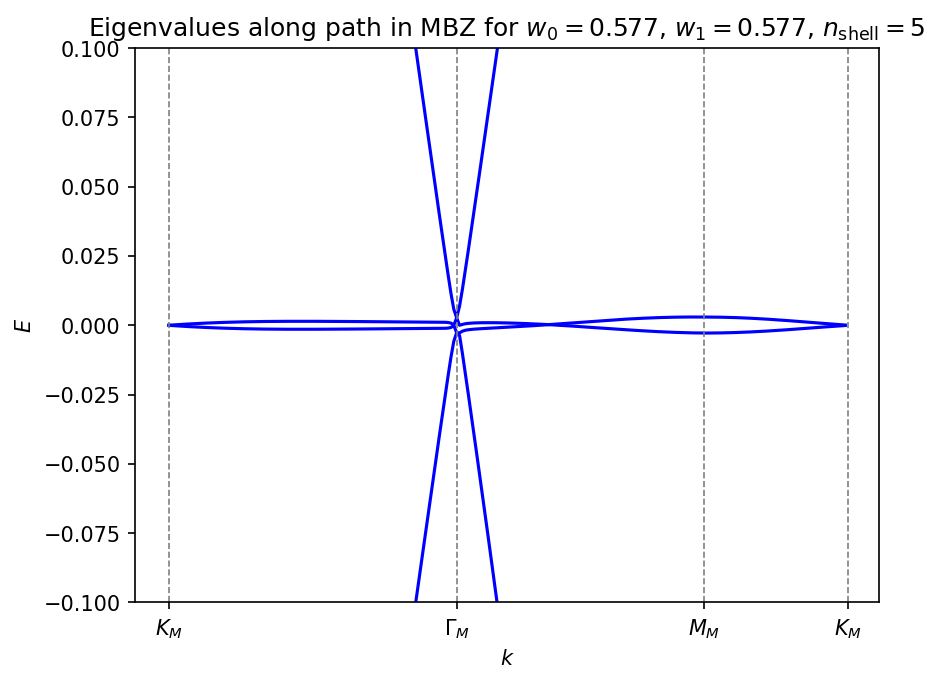

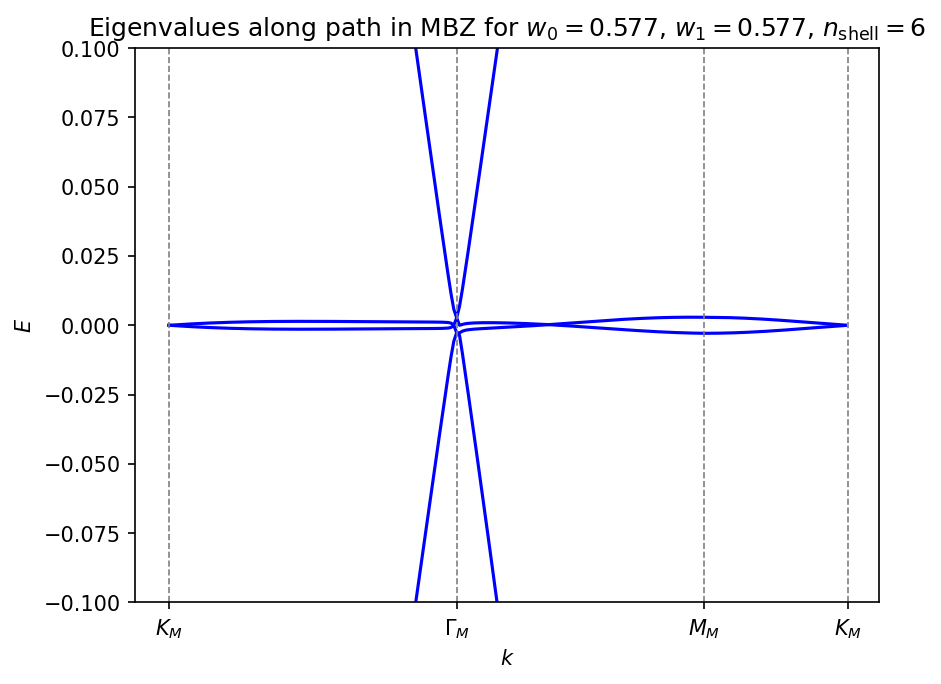

In [66]:
GM.plot_path_eigvals(100, 1/sqrt(3), 1/sqrt(3), 1, Elimits=(-0.1, 0.1), bands=(2, 2))
GM.plot_path_eigvals(100, 1/sqrt(3), 1/sqrt(3), 2, Elimits=(-0.1, 0.1), bands=(2, 2))
GM.plot_path_eigvals(100, 1/sqrt(3), 1/sqrt(3), 3, Elimits=(-0.1, 0.1), bands=(2, 2))
GM.plot_path_eigvals(100, 1/sqrt(3), 1/sqrt(3), 4, Elimits=(-0.1, 0.1), bands=(2, 2))
GM.plot_path_eigvals(100, 1/sqrt(3), 1/sqrt(3), 5, Elimits=(-0.1, 0.1), bands=(2, 2))
GM.plot_path_eigvals(100, 1/sqrt(3), 1/sqrt(3), 6, Elimits=(-0.1, 0.1), bands=(2, 2))

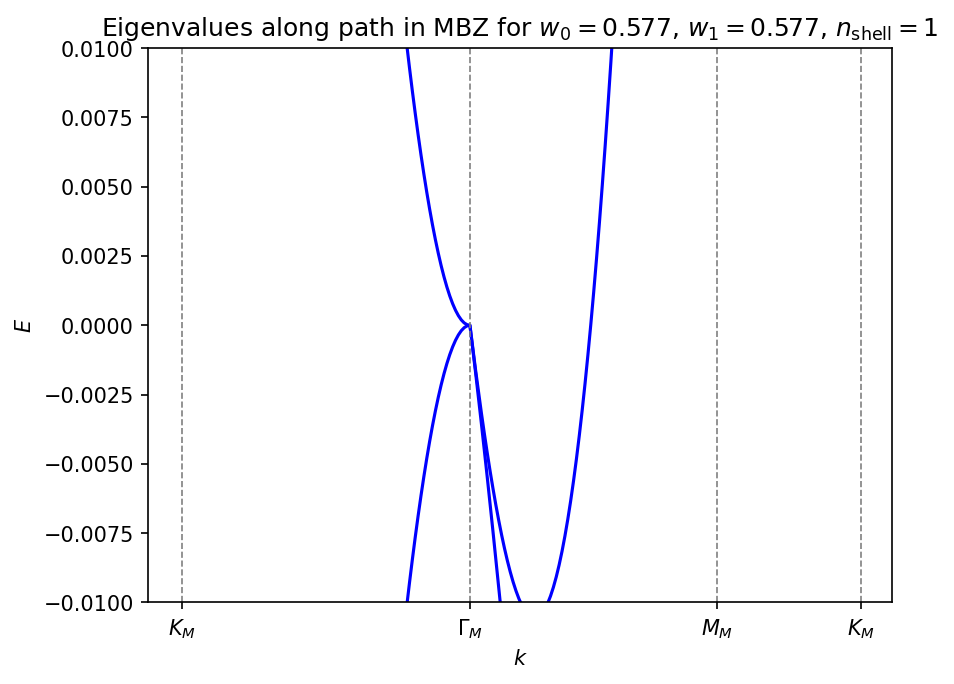

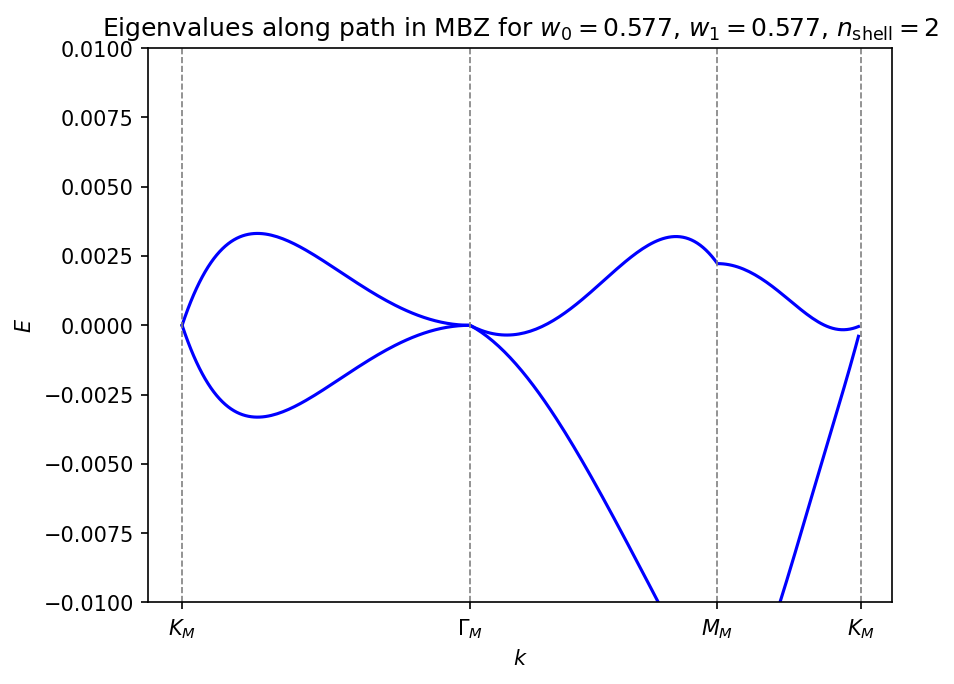

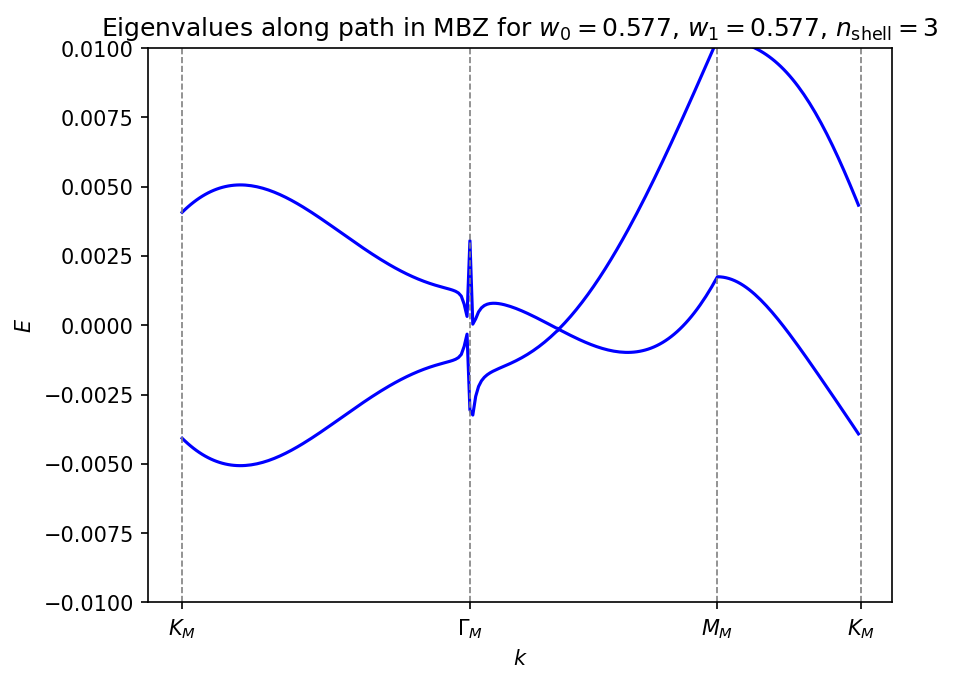

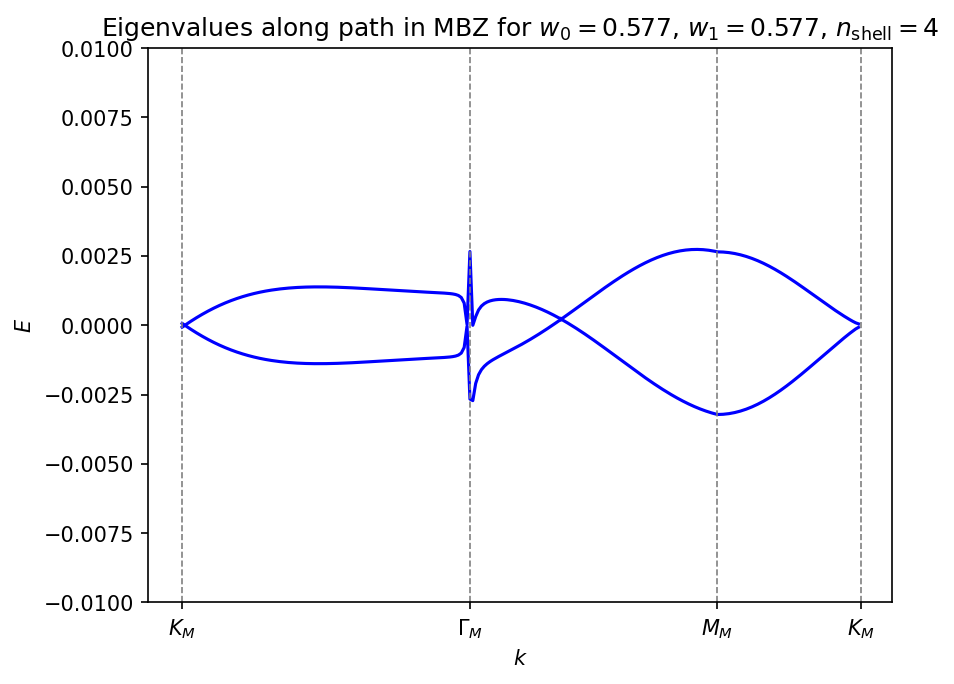

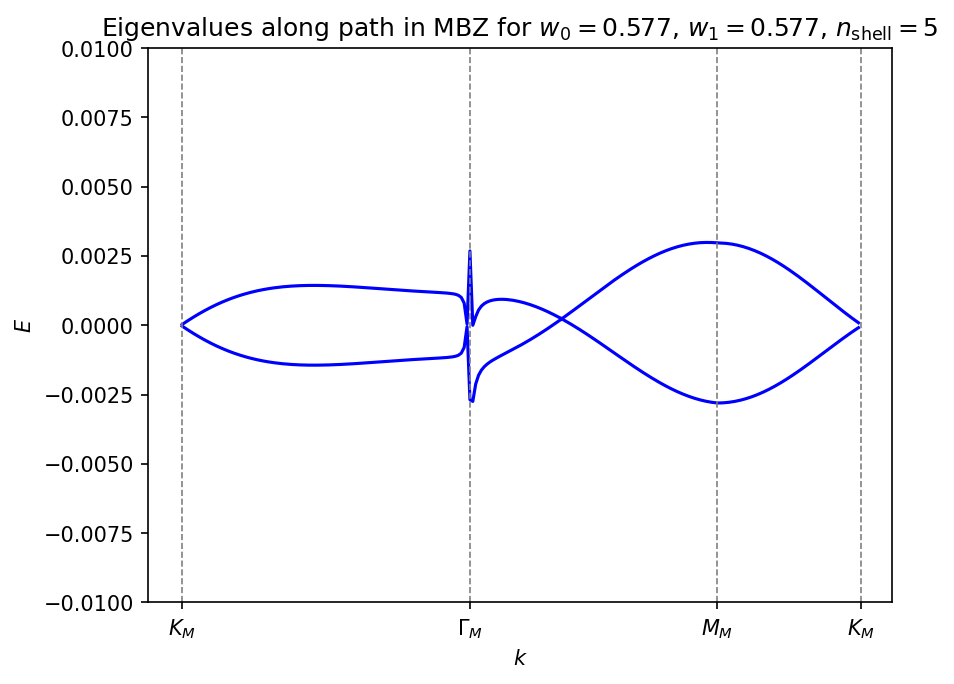

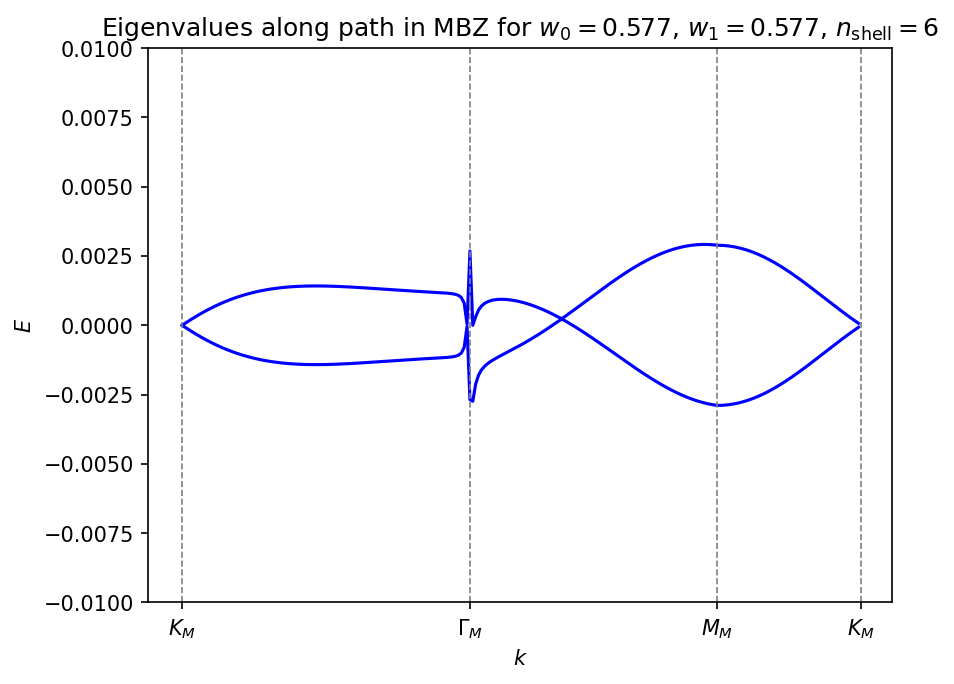

In [65]:
GM.plot_path_eigvals(100, 1/sqrt(3), 1/sqrt(3), 1, Elimits=(-0.01, 0.01), bands=(1, 1))
GM.plot_path_eigvals(100, 1/sqrt(3), 1/sqrt(3), 2, Elimits=(-0.01, 0.01), bands=(1, 1))
GM.plot_path_eigvals(100, 1/sqrt(3), 1/sqrt(3), 3, Elimits=(-0.01, 0.01), bands=(1, 1))
GM.plot_path_eigvals(100, 1/sqrt(3), 1/sqrt(3), 4, Elimits=(-0.01, 0.01), bands=(1, 1))
GM.plot_path_eigvals(100, 1/sqrt(3), 1/sqrt(3), 5, Elimits=(-0.01, 0.01), bands=(1, 1))
GM.plot_path_eigvals(100, 1/sqrt(3), 1/sqrt(3), 6, Elimits=(-0.01, 0.01), bands=(1, 1))

In [63]:
display(np.linalg.eigvalsh(GM.get_gammaM_matrix(np.array([0, 0]), 1/sqrt(3), 1/sqrt(3), 5)))
display(np.linalg.eigvalsh(GM.get_gammaM_matrix(np.array([0, 0.001]), 1/sqrt(3), 1/sqrt(3), 5)))
display(np.linalg.eigvalsh(GM.get_gammaM_matrix(np.array([0, 0.002]), 1/sqrt(3), 1/sqrt(3), 5)))

array([-5.574, -5.574, -5.574, -5.137, -5.137, -5.137, -5.124, -5.124,
       -5.124, -4.989, -4.989, -4.988, -4.986, -4.986, -4.986, -3.923,
       -3.921, -3.921, -3.755, -3.755, -3.745, -3.743, -3.736, -3.736,
       -3.267, -3.267, -3.267, -2.924, -2.9  , -2.9  , -2.854, -2.854,
       -2.825, -2.791, -2.791, -2.785, -2.662, -2.662, -2.662, -2.34 ,
       -2.189, -2.189, -1.524, -1.524, -1.523, -1.492, -1.492, -1.458,
       -1.345, -1.15 , -1.15 , -0.009, -0.003, -0.003,  0.003,  0.003,
        0.009,  1.15 ,  1.15 ,  1.345,  1.458,  1.492,  1.492,  1.523,
        1.524,  1.524,  2.189,  2.189,  2.34 ,  2.662,  2.662,  2.662,
        2.785,  2.791,  2.791,  2.825,  2.854,  2.854,  2.9  ,  2.9  ,
        2.924,  3.267,  3.267,  3.267,  3.736,  3.736,  3.743,  3.745,
        3.755,  3.755,  3.921,  3.921,  3.923,  4.986,  4.986,  4.986,
        4.988,  4.989,  4.989,  5.124,  5.124,  5.124,  5.137,  5.137,
        5.137,  5.574,  5.574,  5.574])

array([-5.575, -5.574, -5.573, -5.138, -5.137, -5.137, -5.125, -5.124,
       -5.123, -4.99 , -4.989, -4.988, -4.987, -4.986, -4.985, -3.923,
       -3.922, -3.921, -3.755, -3.755, -3.745, -3.743, -3.736, -3.735,
       -3.268, -3.267, -3.266, -2.924, -2.9  , -2.9  , -2.854, -2.854,
       -2.825, -2.792, -2.791, -2.785, -2.663, -2.662, -2.661, -2.34 ,
       -2.19 , -2.189, -1.525, -1.524, -1.523, -1.492, -1.491, -1.458,
       -1.345, -1.151, -1.15 , -0.009, -0.003, -0.002,  0.002,  0.003,
        0.009,  1.15 ,  1.151,  1.345,  1.458,  1.491,  1.492,  1.523,
        1.524,  1.525,  2.189,  2.19 ,  2.34 ,  2.661,  2.662,  2.663,
        2.785,  2.791,  2.792,  2.825,  2.854,  2.854,  2.9  ,  2.9  ,
        2.924,  3.266,  3.267,  3.268,  3.735,  3.736,  3.743,  3.745,
        3.755,  3.755,  3.921,  3.922,  3.923,  4.985,  4.986,  4.987,
        4.988,  4.989,  4.99 ,  5.123,  5.124,  5.125,  5.137,  5.137,
        5.138,  5.573,  5.574,  5.575])

array([-5.576, -5.574, -5.573, -5.139, -5.137, -5.136, -5.126, -5.124,
       -5.122, -4.99 , -4.989, -4.987, -4.987, -4.986, -4.984, -3.924,
       -3.922, -3.92 , -3.756, -3.754, -3.745, -3.743, -3.737, -3.735,
       -3.269, -3.267, -3.266, -2.925, -2.9  , -2.9  , -2.854, -2.854,
       -2.825, -2.792, -2.791, -2.785, -2.664, -2.662, -2.66 , -2.34 ,
       -2.19 , -2.188, -1.525, -1.524, -1.522, -1.492, -1.491, -1.458,
       -1.345, -1.151, -1.149, -0.009, -0.003, -0.002,  0.002,  0.003,
        0.009,  1.149,  1.151,  1.345,  1.458,  1.491,  1.492,  1.522,
        1.524,  1.525,  2.188,  2.19 ,  2.34 ,  2.66 ,  2.662,  2.664,
        2.785,  2.791,  2.792,  2.825,  2.854,  2.854,  2.9  ,  2.9  ,
        2.925,  3.266,  3.267,  3.269,  3.735,  3.737,  3.743,  3.745,
        3.754,  3.756,  3.92 ,  3.922,  3.924,  4.984,  4.986,  4.987,
        4.987,  4.989,  4.99 ,  5.122,  5.124,  5.126,  5.136,  5.137,
        5.139,  5.573,  5.574,  5.576])

In [22]:
hexagon_generic = GM.get_gammaM_matrix(np.array([0, 0]), 1/sqrt(3), 1/sqrt(3), 1)

In [23]:
hexagon

array([[ 0.   +0.j ,  0.   +1.j ,  0.577+0.j , -0.289-0.5j,  0.   +0.j ,
         0.   +0.j ,  0.   +0.j ,  0.   +0.j ,  0.   +0.j ,  0.   +0.j ,
         0.577+0.j , -0.289+0.5j],
       [ 0.   -1.j ,  0.   +0.j , -0.289+0.5j,  0.577+0.j ,  0.   +0.j ,
         0.   +0.j ,  0.   +0.j ,  0.   +0.j ,  0.   +0.j ,  0.   +0.j ,
        -0.289-0.5j,  0.577+0.j ],
       [ 0.577+0.j , -0.289-0.5j,  0.   +0.j ,  0.866+0.5j,  0.577+0.j ,
         0.577+0.j ,  0.   +0.j ,  0.   +0.j ,  0.   +0.j ,  0.   +0.j ,
         0.   +0.j ,  0.   +0.j ],
       [-0.289+0.5j,  0.577+0.j ,  0.866-0.5j,  0.   +0.j ,  0.577+0.j ,
         0.577+0.j ,  0.   +0.j ,  0.   +0.j ,  0.   +0.j ,  0.   +0.j ,
         0.   +0.j ,  0.   +0.j ],
       [ 0.   +0.j ,  0.   +0.j ,  0.577+0.j ,  0.577+0.j ,  0.   +0.j ,
         0.866-0.5j,  0.577+0.j , -0.289+0.5j,  0.   +0.j ,  0.   +0.j ,
         0.   +0.j ,  0.   +0.j ],
       [ 0.   +0.j ,  0.   +0.j ,  0.577+0.j ,  0.577+0.j ,  0.866+0.5j,
         0.   +0.j , -

In [19]:

def get_hexagon_matrix(k, w0, w1):
    # following BSRL1
    def dotsigma(v):
        sigmax = np.array([[0, 1], [1, 0]])
        sigmay = np.array([[0, -1j], [1j, 0]])
        return v[0] * sigmax + v[1] * sigmay
    
    def Tj(j, w0, w1):
        # The T matrices in BSRL are hermitian.
        sigma0 = np.identity(2)
        sigmax = np.array([[0, 1], [1, 0]])
        sigmay = np.array([[0, -1j], [1j, 0]])
        return w0 * sigma0 + w1 * (np.cos(2*np.pi*(j-1)/3) * sigmax + np.sin(2*np.pi*(j-1)/3) * sigmay)

    q1 = np.array([0, 1])
    q2 = np.array([-sqrt(3)/2, -1/2])
    q3 = np.array([sqrt(3)/2, -1/2])

    T1 = Tj(1, w0, w1)
    T2 = Tj(2, w0, w1)
    T3 = Tj(3, w0, w1)

    mat = np.zeros((12, 12), dtype=complex)

    # Diagonal terms
    mat[0:2, 0:2] = dotsigma(k - q1)
    mat[2:4, 2:4] = dotsigma(k + q3)
    mat[4:6, 4:6] = dotsigma(k - q2)
    mat[6:8, 6:8] = dotsigma(k + q1)
    mat[8:10, 8:10] = dotsigma(k - q3)
    mat[10:12, 10:12] = dotsigma(k + q2)

    # Off-diagonal terms
    mat[2:4, 4:6] = T1
    mat[4:6, 2:4] = T1
    mat[8:10, 10:12] = T1
    mat[10:12, 8:10] = T1

    mat[0:2, 2:4] = T2
    mat[2:4, 0:2] = T2
    mat[6:8, 8:10] = T2
    mat[8:10, 6:8] = T2

    mat[4:6, 6:8] = T3
    mat[6:8, 4:6] = T3
    mat[10:12, 0:2] = T3
    mat[0:2, 10:12] = T3    

    return mat

In [ ]:

# Define parameters
w_ratios = [1, 0.9, 0.95, 0.8, 0.7, 0.6, 0.5, 0.4]
x = np.linspace(-np.pi, np.pi, 500)
k_labels = ["$K_M$", "$\\Gamma_M$", "$M_M$", "$K_M$", "$K_M$"]  # Labels for tick positions

# Define x-coordinates of labeled points
k_points = [-np.pi, -np.pi/2, 0, np.pi/2, np.pi]

# Generate sample data for the plots (replace this with your actual data)
def sample_data(x, ratio):
    return np.sin(x) * ratio, np.cos(x) * ratio / 2

# Create subplots
fig, axes = plt.subplots(2, 4, figsize=(12, 6), sharex=True, sharey=True)

for i, ax in enumerate(axes.flat):
    ratio = w_ratios[i]
    
    # Generate sample data
    y1, y2 = sample_data(x, ratio)
    
    # Plot the data
    ax.plot(x, y1, color='blue')
    ax.plot(x, y2, color='blue')
    
    # Add dashed vertical lines for labeled points
    for k in k_points:
        ax.axvline(k, color='gray', linestyle='dashed', linewidth=0.8)
    
    # Set title for each subplot
    ax.set_title(f"$w_0/w_1={ratio}$", fontsize=10)
    
    # Add x-axis labels on the bottom row
    if i >= 4:
        ax.set_xticks(k_points)
        ax.set_xticklabels(k_labels)
    
    # Set y-axis label
    if i % 4 == 0:
        ax.set_ylabel("Energy $(v_F k_0)$")

# Adjust layout
fig.tight_layout()
plt.show()

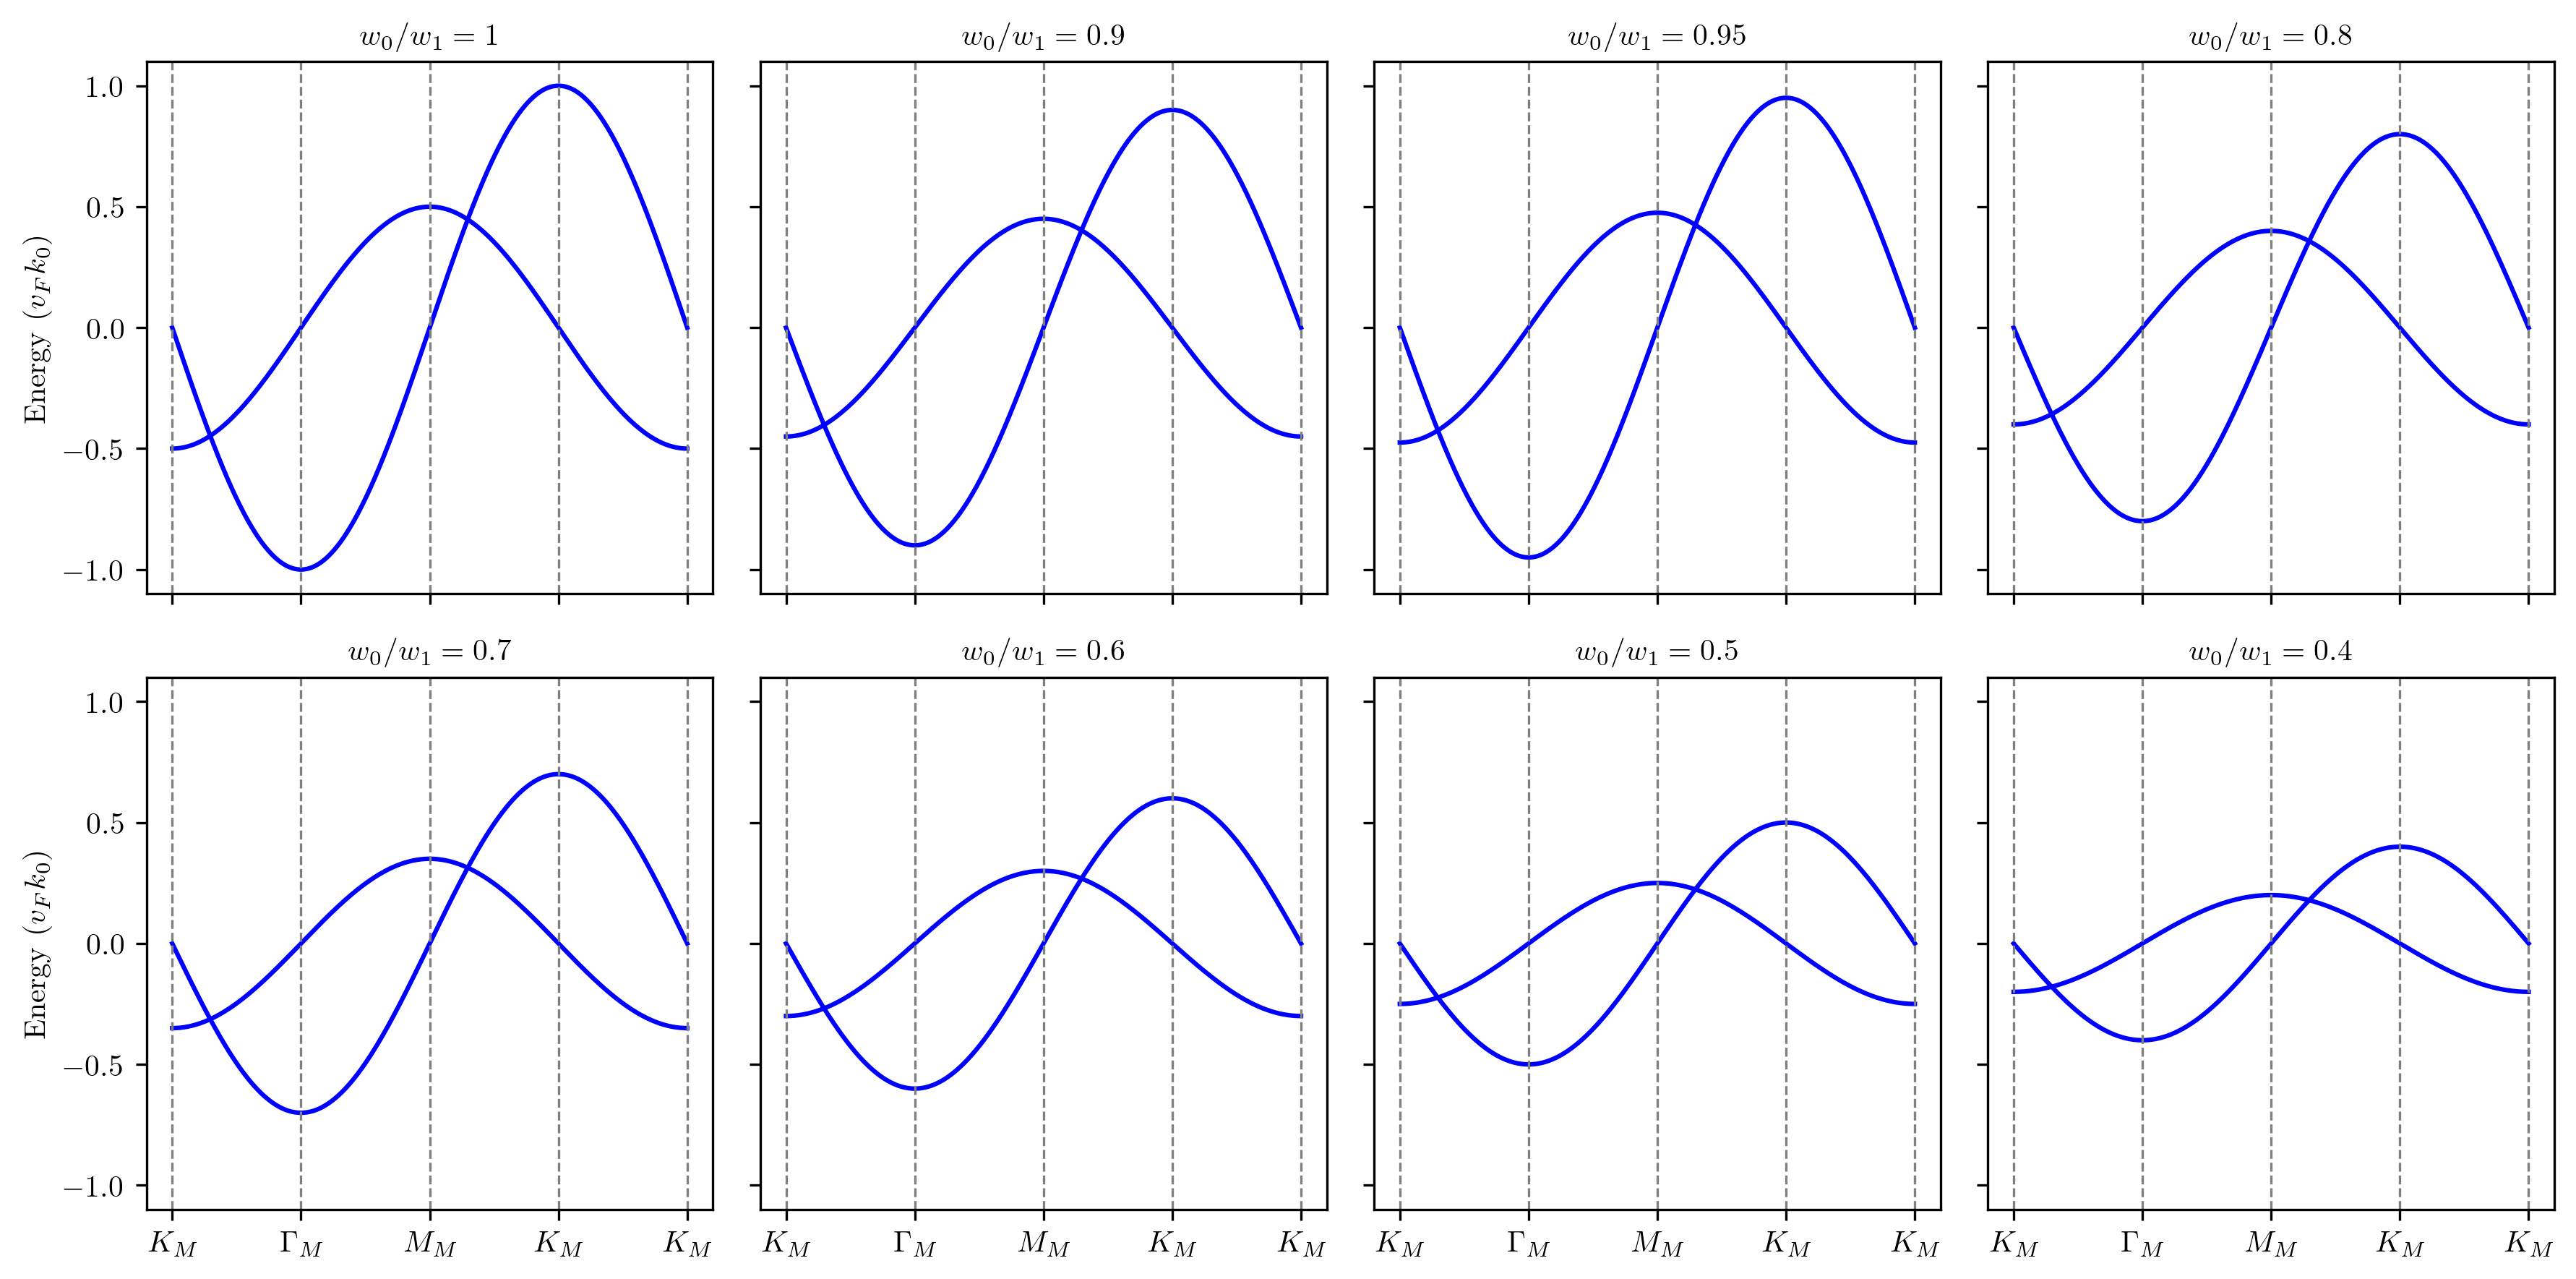

In [178]:
import matplotlib.pyplot as plt
import numpy as np

# Define parameters
w_ratios = [1, 0.9, 0.95, 0.8, 0.7, 0.6, 0.5, 0.4]
x = np.linspace(-np.pi, np.pi, 500)
k_labels = ["$K_M$", "$\\Gamma_M$", "$M_M$", "$K_M$", "$K_M$"]  # Labels for tick positions

# Define x-coordinates of labeled points
k_points = [-np.pi, -np.pi/2, 0, np.pi/2, np.pi]

# Generate sample data for the plots (replace this with your actual data)
def sample_data(x, ratio):
    return np.sin(x) * ratio, np.cos(x) * ratio / 2

# Create subplots
fig, axes = plt.subplots(2, 4, figsize=(12, 6), sharex=True, sharey=True)

for i, ax in enumerate(axes.flat):
    ratio = w_ratios[i]
    
    # Generate sample data
    y1, y2 = sample_data(x, ratio)
    
    # Plot the data
    ax.plot(x, y1, color='blue')
    ax.plot(x, y2, color='blue')
    
    # Add dashed vertical lines for labeled points
    for k in k_points:
        ax.axvline(k, color='gray', linestyle='dashed', linewidth=0.8)
    
    # Set title for each subplot
    ax.set_title(f"$w_0/w_1={ratio}$", fontsize=10)
    
    # Add x-axis labels on the bottom row
    if i >= 4:
        ax.set_xticks(k_points)
        ax.set_xticklabels(k_labels)
    
    # Set y-axis label
    if i % 4 == 0:
        ax.set_ylabel("Energy $(v_F k_0)$")

# Adjust layout
fig.tight_layout()
plt.show()


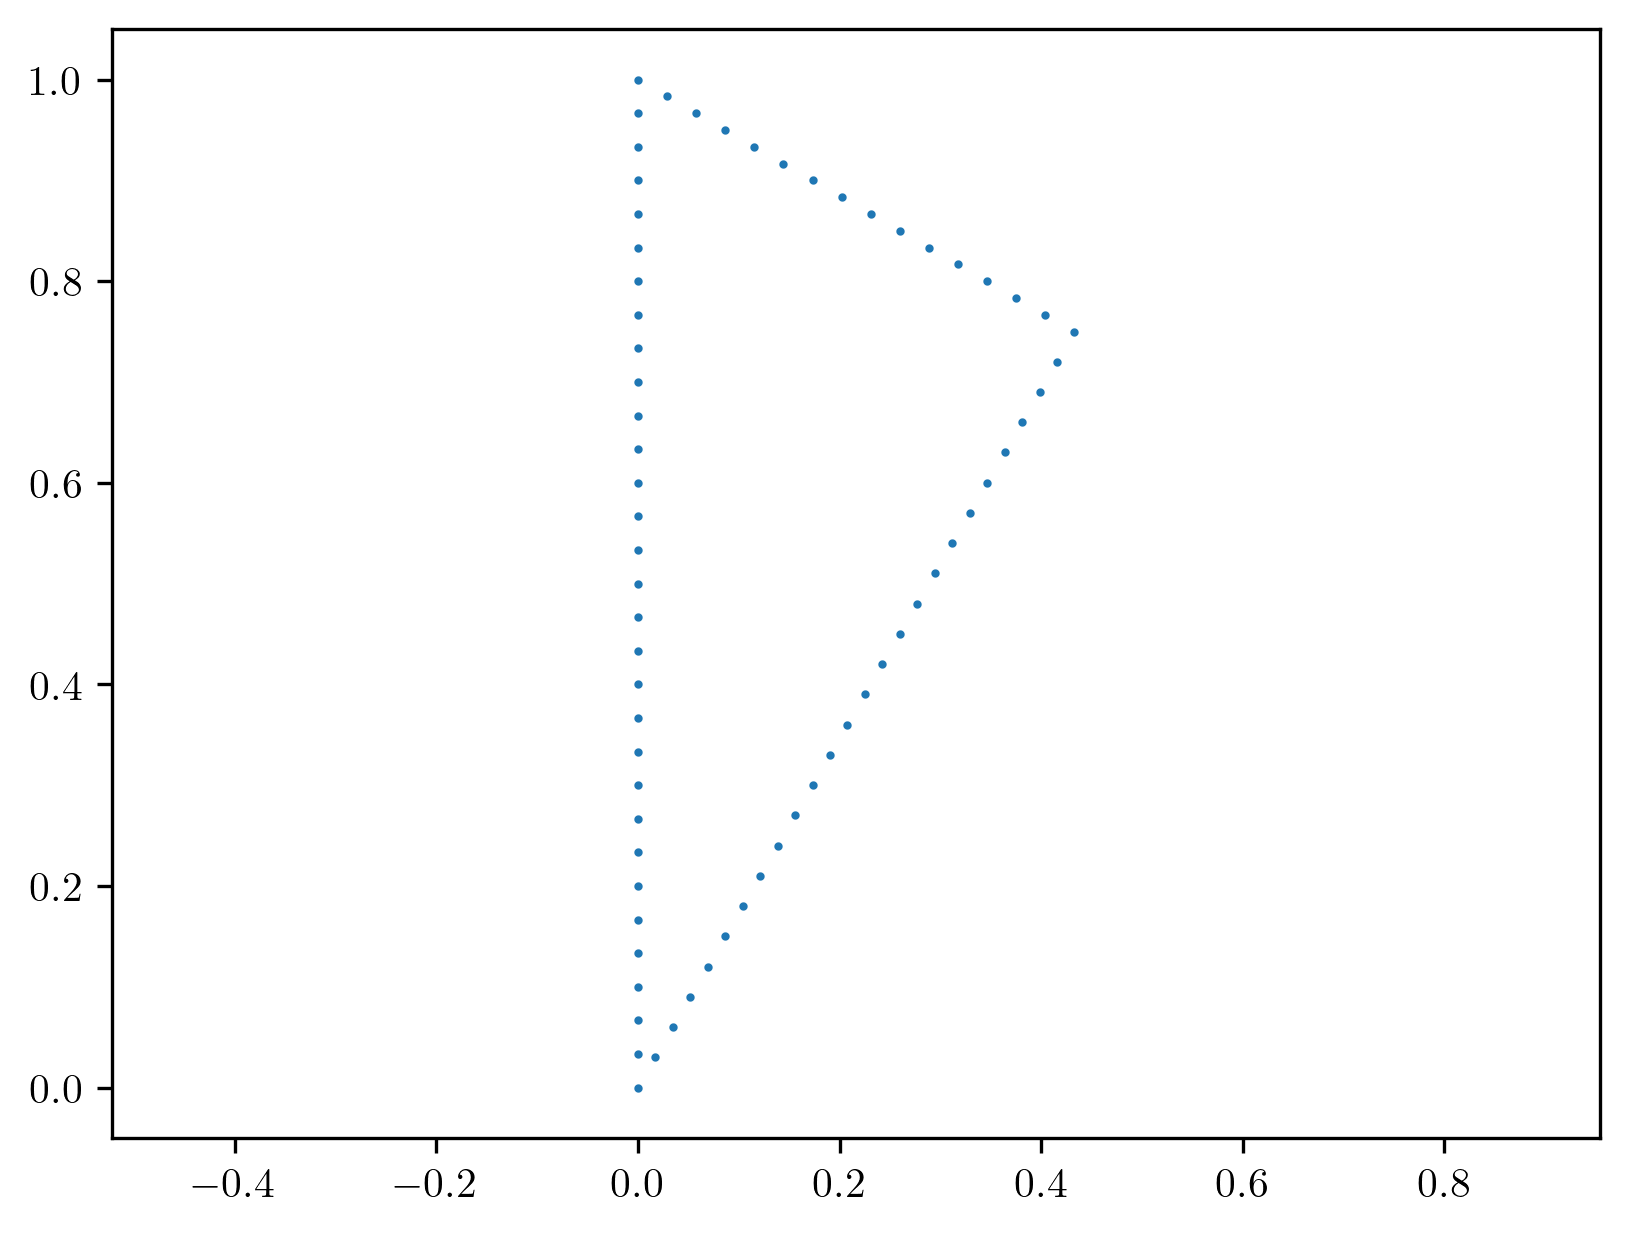

In [57]:
plt.rcParams['figure.dpi']=300
# all_points = gammaM_BZ(30)
all_points = BZ_path(30)
plt.plot([p[0] for p in all_points], [p[1] for p in all_points], 'o', markersize=1)
plt.axis('equal')
plt.show()


In [21]:

def get_hexagon_matrix(k, w0, w1):
    # following BSRL1

    q1 = np.array([0, 1])
    q2 = np.array([-sqrt(3)/2, -1/2])
    q3 = np.array([sqrt(3)/2, -1/2])

    T1 = Tj(1, w0, w1)
    T2 = Tj(2, w0, w1)
    T3 = Tj(3, w0, w1)

    mat = np.zeros((12, 12), dtype=complex)

    # Diagonal terms
    mat[0:2, 0:2] = dotsigma(k - q1)
    mat[2:4, 2:4] = dotsigma(k + q3)
    mat[4:6, 4:6] = dotsigma(k - q2)
    mat[6:8, 6:8] = dotsigma(k + q1)
    mat[8:10, 8:10] = dotsigma(k - q3)
    mat[10:12, 10:12] = dotsigma(k + q2)

    # Off-diagonal terms
    mat[2:4, 4:6] = T1
    mat[4:6, 2:4] = T1
    mat[8:10, 10:12] = T1
    mat[10:12, 8:10] = T1

    mat[0:2, 2:4] = T2
    mat[2:4, 0:2] = T2
    mat[6:8, 8:10] = T2
    mat[8:10, 6:8] = T2

    mat[4:6, 6:8] = T3
    mat[6:8, 4:6] = T3
    mat[10:12, 0:2] = T3
    mat[0:2, 10:12] = T3    

    return mat

In [4]:
points = GM.gammaM_BZ(4, proportion=3)


all_eigvals = [np.linalg.eigvalsh(GM.get_gammaM_matrix(p, 0.0, 0.64, 12)) for p in points]
# positive_eigvals = [[e for e in eigvals if e >= 0] for eigvals in all_eigvals]
# lowest_eigvals = [min(eigvals) for eigvals in positive_eigvals]
# second_lowest_eigvals = [sorted(eigvals)[1] for eigvals in positive_eigvals]
# lowest_eigvals = [min(np.abs(eigvals)) for eigvals in all_eigvals]

# sixth_eigvals = [sorted(eigvals)[5] for eigvals in all_eigvals]
#seventh_eigvals = [sorted(eigvals)[6] for eigvals in all_eigvals]
middle_eigvals = [sorted(eigvals)[len(eigvals)//2] for eigvals in all_eigvals]

x = [p[0] for p in points] # + [p[0] for p in points]
y = [p[1] for p in points] # + [p[1] for p in points]
z = middle_eigvals # sixth_eigvals + seventh_eigvals # + second_lowest_eigvals


import plotly.graph_objects as go
# Create a 3D scatter plot
fig = go.Figure(data=[go.Scatter3d(x=x, y=y, z=z, mode='markers', marker=dict(size=2, color=z, colorscale='Viridis'))])


# Add titles and labels
fig.update_scenes(aspectratio = {'x': sqrt(3)/2, 'y': 1, 'z': 0.5}) # also works for me. Thank you! – 



fig.write_html("surface_plot_asdf.html")

# Show the plot
fig.show()

In [22]:
from scipy.interpolate import griddata


points = GM.gammaM_BZ(100)
all_eigvals = [np.linalg.eigvalsh(get_hexagon_matrix(p, 1/sqrt(3), 1/sqrt(3))) for p in points]
# positive_eigvals = [[e for e in eigvals if e >= 0] for eigvals in all_eigvals]
# lowest_eigvals = [min(eigvals) for eigvals in positive_eigvals]
# second_lowest_eigvals = [sorted(eigvals)[1] for eigvals in positive_eigvals]
# lowest_eigvals = [min(np.abs(eigvals)) for eigvals in all_eigvals]
sixth_eigvals = [sorted(eigvals)[5] for eigvals in all_eigvals]
seventh_eigvals = [sorted(eigvals)[6] for eigvals in all_eigvals]

x = [p[0] for p in points] # + [p[0] for p in points]
y = [p[1] for p in points] # + [p[1] for p in points]
z = seventh_eigvals # + second_lowest_eigvals



# Define a grid to interpolate over
grid_x, grid_y = np.linspace(min(x), max(x), 100), np.linspace(min(y), max(y), 100)
grid_x, grid_y = np.meshgrid(grid_x, grid_y)

# Interpolate z values on the grid
grid_z = griddata((x, y), z, (grid_x, grid_y), method='cubic')

# Create a surface plot
fig = go.Figure(data=[go.Surface(z=grid_z, x=grid_x, y=grid_y, colorscale='Viridis')])

# Add titles and labels
fig.update_scenes(aspectratio = {'x': sqrt(3)/2, 'y': 1, 'z': 0.5}) # also works for me. Thank you! – 



fig.write_html("surface_plot.html")

# Show the plot
fig.show()




NameError: name 'Tj' is not defined